# Datasety

pip install pandas, plotly, scikit-learn

In [2]:
# pip install pandas plotly scikit-learn ucimlrepo
# pip install -U "qiskit>=2.0" "qiskit-ibm-runtime>=0.37"
# potom restart kernel 


from ucimlrepo import fetch_ucirepo
import numpy as np
from numpy.polynomial.legendre import legval, legroots
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, load_iris, fetch_openml, load_digits
import io, zipfile, urllib.request
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer

import tensorflow as tf
from sklearn.datasets import make_hastie_10_2
from sklearn.datasets import make_gaussian_quantiles
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

def make_concentric_hypershells(n_samples=5000, d=7, n_shells=5, box=1.0 ,noise=0.01,seed=0,return_meta=False,):
    """
    Hypershelly v R^d:
      - medzi shellmi je "medzera" bez bodov
      - hrúbka shellu == šírka medzery
      - automaticky sa to škáluje tak, aby sa n_shells zmestilo do L2 gule s r_max = box*sqrt(d)
    """
    assert d >= 2
    assert n_shells >= 1
    rng = np.random.default_rng(seed)

    r_max = float(box) * np.sqrt(d)

    # Nech máme: shell(šírka=w) + gap(šírka=w) opakovane.
    # Posledný gap už nemusí existovať, ale shell musí vojsť do r_max.
    # Outer radius posledného shellu: (2*n_shells)*w  <= r_max  =>  w = r_max / (2*n_shells)
    w = r_max / (2.0 * n_shells)        # w = thick = gap
    thick = w
    gap = w

    # pre shell i (0..n_shells-1):
    # inner = (2*i)*w, outer = (2*i+1)*w, potom gap: ((2*i+1)*w .. (2*i+2)*w)
    shell_ids = rng.integers(0, n_shells, size=n_samples)
    y = (shell_ids % 2).astype(np.int64)

    r_inner = (2.0 * shell_ids) * w
    r_outer = (2.0 * shell_ids + 1.0) * w

    # uniform v hrúbke shellu (po radiále)
    radii = rng.uniform(r_inner, r_outer).astype(np.float32)

    # uniform smer na hypersfére
    v = rng.normal(0.0, 1.0, size=(n_samples, d)).astype(np.float32)
    v = v / (np.linalg.norm(v, axis=1, keepdims=True) + 1e-12)

    X = v * radii[:, None]

    if noise and noise > 0.0:
        X = X + rng.normal(0.0, noise, size=X.shape).astype(np.float32)

    if return_meta:
        r_edges = np.stack(
            [[(2*i)*w, (2*i+1)*w, (2*i+2)*w] for i in range(n_shells)],
            axis=0
        ).astype(np.float32)  # (n_shells,3): [shell_inner, shell_outer, gap_outer]
        meta = {
            "r_max": float(r_max),
            "w": float(w),
            "thick": float(thick),
            "gap": float(gap),
            "r_edges": r_edges,
            "box": float(box),
        }
        return X.astype(np.float32), y, meta

    return X.astype(np.float32), y


RNG = 123


def _rng(seed):
    return np.random.default_rng(seed)

def _ensure_dim(X, d, rng, extra_scale=1.0):
    """Ak má X menej stĺpcov než d, doplní gaussovské dimenzie.
    Ak má viac, zoberie prvých d.
    """
    n, p = X.shape
    if p == d:
        return X
    if p > d:
        return X[:, :d]
    extra = rng.normal(0, extra_scale, size=(n, d - p))
    return np.hstack([X, extra])

def _maybe_flip(y, noise, rng):
    if noise <= 0:
        return y
    flip = rng.random(y.shape[0]) < noise
    return np.bitwise_xor(y, flip.astype(np.int64))


def make_concentric_cylinders(n_samples=5000, d=5, n_shells=7, r_min=1.0, gap=0.7, axial_scale=2.0, noise=0.01, seed=0):
    """Kruhové prstence v (x1,x2), rozťahané pozdĺž zvyšných osí (valce)."""
    assert d >= 2
    rng = _rng(seed)
    theta = rng.uniform(0, 2 * np.pi, size=n_samples)
    shell_ids = rng.integers(0, n_shells, size=n_samples)
    radii = (r_min + shell_ids * gap) + rng.normal(0, noise, size=n_samples)
    x1 = radii * np.cos(theta)
    x2 = radii * np.sin(theta)
    base = np.stack([x1, x2], axis=1)
    X = _ensure_dim(base, d, rng, extra_scale=axial_scale)
    y = (shell_ids % 2).astype(np.int64)
    y = _maybe_flip(y, noise, rng)
    return X.astype(np.float32), y



def make_mini_madelon(n_samples=5000, n_features=6, n_informative=3,n_redundant=0, n_repeated=0, class_sep=1.0, flip_y=0.02,random_state=RNG):
    """
    Binary classification s pár informatívnymi featuremi a zvyškom šumu.
    Drž n_features ≤ 10 podľa tvojho zadania.
    """
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_classes=2,
        n_clusters_per_class=2,
        class_sep=class_sep,
        flip_y=flip_y,
        shuffle=True,
        random_state=random_state
    )
    return X.astype(np.float32), y.astype(np.int64)


def make_spirals_nd_full2(
    n_samples=5000,
    d=4,                      # informatívne dimenzie špirály
    turns=3.0,
    radial_noise=0.01,
    noise=0.01,
    seed=0,
    center_gap_power=0.5,
    edge_stretch_power=0.6,
    r_min=0.02,
    extra_dims=4,             # <-- X neinformatívnych osí navyše
    extra_dist="uniform",      # "normal" | "uniform"
    extra_scale=1.0,          # mierka neinformatívnych čísiel
):
    assert d >= 2
    assert extra_dims >= 0
    rng = _rng(seed)

    n1 = n_samples // 2
    n2 = n_samples - n1

    t1 = rng.uniform(0, 2 * np.pi * turns, size=n1).astype(np.float32)
    t2 = (t1 + np.pi).astype(np.float32)

    s1 = (t1 / (2 * np.pi * turns)).astype(np.float32)

    # radius: center-gap + edge-stretch + center hole
    u = np.power(s1, center_gap_power).astype(np.float32)
    r = (1.0 - np.power(1.0 - u, edge_stretch_power)).astype(np.float32)
    r = (r_min + (1.0 - r_min) * r).astype(np.float32)

    r1 = r
    r2 = r

    n_pairs = d // 2
    freqs = np.arange(1, n_pairs + 1, dtype=np.float32)

    def embed(r, t):
        T = t[:, None].astype(np.float32)
        R = r[:, None].astype(np.float32)
        X = np.empty((t.shape[0], d), dtype=np.float32)

        for p in range(n_pairs):
            w = freqs[p]
            X[:, 2*p]   = R[:, 0] * np.cos(w * T[:, 0])
            X[:, 2*p+1] = R[:, 0] * np.sin(w * T[:, 0])

        if d % 2 == 1:
            w_last = np.float32(n_pairs + 1)
            X[:, -1] = R[:, 0] * np.cos(w_last * T[:, 0])

        return X.astype(np.float32)

    x1 = embed(r1, t1)
    x2 = embed(r2, t2)

    X = np.vstack([x1, x2]).astype(np.float32)

    # šum na informatívnych dimenziách (pôvodné správanie)
    X = X + rng.normal(0, radial_noise, size=X.shape).astype(np.float32)

    # neinformatívne dimenzie navyše (nezávislé náhodné čísla)
    if extra_dims > 0:
        if extra_dist == "normal":
            X_extra = rng.normal(0, extra_scale, size=(n_samples, extra_dims)).astype(np.float32)
        elif extra_dist == "uniform":
            X_extra = rng.uniform(-extra_scale, extra_scale, size=(n_samples, extra_dims)).astype(np.float32)
        else:
            raise ValueError("extra_dist musí byť 'normal' alebo 'uniform'")
        X = np.hstack([X, X_extra]).astype(np.float32)

    y = np.array([0] * n1 + [1] * n2, dtype=np.int64)
    y = _maybe_flip(y, noise, rng)
    return X, y


def _balanced_from_sampler_with_gaps(label_fn, draw_fn, n_samples=5000, rng=None):
    """
    label_fn(X) vracia:
      - 0/1 pre body v pasoch
      - -1 pre body v medzerach (zahodia sa)
    """
    rng = np.random.default_rng(rng)
    need = n_samples // 2
    Xpos_chunks, Xneg_chunks = [], []
    chunk = max(10000, n_samples)

    while True:
        Xc = draw_fn(chunk)
        yc = label_fn(Xc).astype(int)

        valid = (yc >= 0)
        if np.any(valid):
            Xv = Xc[valid]
            yv = yc[valid]
            if np.any(yv == 1):
                Xpos_chunks.append(Xv[yv == 1])
            if np.any(yv == 0):
                Xneg_chunks.append(Xv[yv == 0])

        npos = sum(a.shape[0] for a in Xpos_chunks)
        nneg = sum(a.shape[0] for a in Xneg_chunks)
        if npos >= need and nneg >= need:
            break

        if npos < need // 4 or nneg < need // 4:
            chunk *= 2

    Xpos = np.concatenate(Xpos_chunks, axis=0)[:need]
    Xneg = np.concatenate(Xneg_chunks, axis=0)[:need]
    X = np.vstack([Xpos, Xneg])
    y = np.concatenate([np.ones(need, dtype=int), np.zeros(need, dtype=int)])

    perm = rng.permutation(n_samples)
    return X[perm], y[perm]


# skuska, nahrada d=8 za d=5, freq=7 za freq=10
def make_stripes_with_gaps(n_samples=5000,d=5,freq=10,band_frac=0.7, s_scale=3.0, random_state=42):
    """
    - pasy maju (priblizne) rovnaku hrubku v projekcii s = X@u
    - medzi pasmi je medzera bez bodov
    - stabilne napriec dimenziami (ziadne /sqrt(d), ziadne CDF)
    """
    if not (0.0 < band_frac < 1.0):
        raise ValueError("band_frac musi byt v (0,1).")
    if s_scale <= 0:
        raise ValueError("s_scale musi byt > 0.")

    rng = np.random.default_rng(random_state)

    u = rng.normal(size=d)
    u /= (np.linalg.norm(u) + 1e-12)

    def draw_fn(m):
        return rng.uniform(-1.0, 1.0, size=(m, d))

    # Var(Xi)=1/3 pre U(-1,1); pre jednotkove u: Var(X@u)=1/3
    sigma = np.sqrt(1.0 / 3.0)
    a = s_scale * sigma

    gap_frac = 1.0 - band_frac
    gap_left = 0.5 * gap_frac
    gap_right = gap_left + band_frac  # pas je v strede periody

    def label_fn(X):
        s = X @ u

        in_range = np.abs(s) <= a
        y = np.full(X.shape[0], -1, dtype=int)  # default: medzera (zahod)

        if not np.any(in_range):
            return y

        # linearne mapovanie projekcie do [0,1] s pevnym rozsahom => konstantna "hrubka" v s
        t = (s[in_range] + a) / (2.0 * a)
        t = np.clip(t, 0.0, 1.0 - 1e-12)

        w = freq * t
        k = np.floor(w).astype(int)       # 0..freq-1
        r = w - k                         # v [0,1)

        in_band = (r >= gap_left) & (r < gap_right)  # polootvorene kvôli okrajom
        idx = np.flatnonzero(in_range)[in_band]
        y[idx] = (k[in_band] % 2).astype(int)

        return y

    return _balanced_from_sampler_with_gaps(label_fn, draw_fn, n_samples, rng)


def _balanced_from_sampler_with_reject(label_fn, draw_fn, n_samples=5000, rng=None):
    """
    label_fn(X) vracia:
      - 0/1 pre akceptovane body
      - -1 pre body v 'medzerach' (reject)
    """
    rng = np.random.default_rng(rng)
    need = n_samples // 2
    Xpos_chunks, Xneg_chunks = [], []
    chunk = max(10000, n_samples)

    while True:
        Xc = draw_fn(chunk)
        yc = label_fn(Xc).astype(int)

        ok = (yc >= 0)
        if np.any(ok):
            Xv = Xc[ok]
            yv = yc[ok]
            if np.any(yv == 1):
                Xpos_chunks.append(Xv[yv == 1])
            if np.any(yv == 0):
                Xneg_chunks.append(Xv[yv == 0])

        npos = sum(a.shape[0] for a in Xpos_chunks)
        nneg = sum(a.shape[0] for a in Xneg_chunks)
        if npos >= need and nneg >= need:
            break

        if npos < need // 4 or nneg < need // 4:
            chunk *= 2

    Xpos = np.concatenate(Xpos_chunks, axis=0)[:need]
    Xneg = np.concatenate(Xneg_chunks, axis=0)[:need]
    X = np.vstack([Xpos, Xneg])
    y = np.concatenate([np.ones(need, dtype=int), np.zeros(need, dtype=int)])

    perm = rng.permutation(n_samples)
    return X[perm], y[perm]

# X_np,y_np = make_spherical_legendre(d=9, degree=11, gap_s=0.11)
def make_spherical_legendre(n_samples=5000,d=9,degree=11,gap_s=0.11,random_state=42):
    rng = np.random.default_rng(random_state)

    v = rng.normal(size=d)
    v /= np.linalg.norm(v) + 1e-12

    # Legendre series koeficienty pre P_degree
    c = np.zeros(degree + 1)
    c[degree] = 1.0

    # korene P_degree v [-1,1] => hranice pasov
    roots = legroots(c)  # tvar (degree,)

    def draw_fn(m):
        Z = rng.normal(size=(m, d))
        return Z / (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12)

    def label_fn(X):
        s = X @ v  # v [-1,1]

        if gap_s > 0 and roots.size > 0:
            # reject bodov blizko hociktoreho korena => medzery medzi pasmi
            dist = np.min(np.abs(s[:, None] - roots[None, :]), axis=1)
            in_gap = dist < gap_s
        else:
            in_gap = np.zeros(s.shape[0], dtype=bool)

        y = np.full(s.shape[0], -1, dtype=int)  # -1 = medzera
        ok = ~in_gap
        if np.any(ok):
            p = legval(s[ok], c)
            y[ok] = (p > 0).astype(int)
        return y

    return _balanced_from_sampler_with_reject(label_fn, draw_fn, n_samples, rng)

def make_checkerboard_nd(n_per_class=2500, dim=2, squares=6, jitter=0.01, seed=0, gap_frac=0.05,return_XY=False, noise=0.01, n_irrelevant=1):
    rng = np.random.default_rng(seed)
    n = 2 * n_per_class
    cell = 2.0 / squares
    gap = float(gap_frac)
    gap_lo, gap_hi = gap, 1.0 - gap

    def mask_keep(X):
        u = ((X + 1.0) / cell) % 1.0  # (B, dim)
        return np.all((u > gap_lo) & (u < gap_hi), axis=1)

    X_list, need = [], n
    batch = max(2048, n)
    while need > 0:
        cand = rng.uniform(-1.0, 1.0, size=(batch, dim)).astype(np.float32)
        m = mask_keep(cand)
        if np.any(m):
            take = cand[m]
            X_list.append(take)
            need -= take.shape[0]
    XY = np.concatenate(X_list, axis=0)[:n]

    if jitter and jitter > 0.0:
        XY = XY + rng.normal(0.0, jitter, size=XY.shape).astype(np.float32)
        m = mask_keep(XY)
        XY = XY[m]
        if XY.shape[0] < n:
            need2 = n - XY.shape[0]
            X_list2 = [XY]
            while need2 > 0:
                cand = rng.uniform(-1.0, 1.0, size=(batch, dim)).astype(np.float32)
                cand = cand + rng.normal(0.0, jitter, size=cand.shape).astype(np.float32)
                m2 = mask_keep(cand)
                if np.any(m2):
                    take2 = cand[m2]
                    X_list2.append(take2)
                    need2 -= take2.shape[0]
            XY = np.concatenate(X_list2, axis=0)[:n]
        else:
            XY = XY[:n]

    idx = np.floor((XY + 1.0) / cell).astype(int)  # (N, dim)
    y = (np.sum(idx, axis=1) % 2).astype(np.float32)
    if noise and noise > 0.0:
        flip = rng.random(y.shape[0]) < noise
        y[flip] = 1.0 - y[flip]

    Xang = ((XY + 1.0) * 0.5 * np.pi).astype(np.float32)

    # + irrelevant features (uniform random), minimal change
    if n_irrelevant and n_irrelevant > 0:
        irr = rng.uniform(0.0, np.pi, size=(Xang.shape[0], n_irrelevant)).astype(np.float32)
        Xang = np.concatenate([Xang, irr], axis=1)

    if return_XY:
        return Xang, y, XY

    return Xang, y


datasety = {
    "make_concentric_cylinders" : make_concentric_cylinders,
    "make_checkerboard_nd":make_checkerboard_nd,
    "make_concentric_hypershells": make_concentric_hypershells,
    "make_spherical_legendre" : make_spherical_legendre,
    "make_stripes_with_gaps" : make_stripes_with_gaps,
    "make_spirals_nd_full2" : make_spirals_nd_full2,
}

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import plotly.io as pio

def plot_3d_features_with_labels(X, y, *, renderer=None, marker_size=4, opacity=0.85, axis_labels=("x1", "x2", "x3"), title=None):
    """
    Interactive 3D scatter plot for X (n,3) colored by class labels y (n,).
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()

    if X.ndim != 2 or X.shape[1] != 3:
        raise ValueError(f"X must have shape (n_samples, 3). Got: {X.shape}")
    if y.shape[0] != X.shape[0]:
        raise ValueError(f"y must have length {X.shape[0]}. Got: {y.shape}")

    if renderer is not None:
        pio.renderers.default = renderer  # e.g. "browser", "notebook", "vscode"

    df = pd.DataFrame(X, columns=list(axis_labels))
    df["class"] = y.astype(str)

    fig = px.scatter_3d(
        df,
        x=axis_labels[0], y=axis_labels[1], z=axis_labels[2],
        color="class",
        symbol="class",
        opacity=opacity,
        title=title
    )
    fig.update_traces(marker=dict(size=marker_size))
    fig.update_layout(scene=dict(
        xaxis_title=axis_labels[0],
        yaxis_title=axis_labels[1],
        zaxis_title=axis_labels[2],
    ))
    # fig.show()
    return fig


2026-02-27 22:31:15.460009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Overene datasety

tieto by som pouzil na realny hardver + nejaky jeden systeticky so 2mi neuronmi, ostatne bude stacit 1 neuron

z kazdeho zoberiem 50 testovacich vzoriek, a kazdu zbehnem 5 krat zatial = 20 min casu
- budem mat minimalne 3 ucty po 10 min, taze malo by to byt pohoda

In [3]:
# pip install pandas scikit-learn openpyxl xlrd>=2.0.1 fastparquet openml seaborn

def MNIST_digits(n_components=10):
    X, y = load_digits(return_X_y=True)
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    # X, _, y, _ = train_test_split(X, y, train_size=5000, random_state=0, stratify=y)
    print(X.shape)
    return X, y

def MNIST_fashion(n_components=10): # trva ale dlhsie kus 
    (x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.fashion_mnist.load_data()
    X = np.concatenate([x_tr, x_te], axis=0).astype("float32") / 255.0
    X = X.reshape(X.shape[0], -1)  # (70000, 784)
    y = np.concatenate([y_tr, y_te], axis=0).astype("int32")  # (70000,)
    
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    print(X.shape)
    X, _, y, _ = train_test_split(X, y, train_size=5000, random_state=0, stratify=y)
    return X,y

def breast_cancer(n_components=None):
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name="target")  # 0 = malignant, 1 = benign
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    print("Shape X:", X.shape)
    return X, y

def letter_recognition(n_components=None): # vela tried fest dopice (od A-Z )
    ds = fetch_openml(name="letter", version=1, as_frame=True)
    X = ds.data.to_numpy()
    y = LabelEncoder().fit_transform(ds.target.to_numpy())
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    print(X.shape)
    return X, y

def load_breast_cancer_wisconsin_original():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
    cols = [
        "id",
        "clump_thickness",
        "uniformity_cell_size",
        "uniformity_cell_shape",
        "marginal_adhesion",
        "single_epithelial_cell_size",
        "bare_nuclei",
        "bland_chromatin",
        "normal_nucleoli",
        "mitoses",
        "class",
    ]
    df = pd.read_csv(url, header=None, names=cols, na_values=["?"]).dropna()
    df["class"] = df["class"].astype(int).map({2: 0, 4: 1})  # benign/malignant
    X = df.drop(columns=["id", "class"]).astype(np.float32).to_numpy()
    y = df["class"].to_numpy(np.int32)
    return X, y

def breast_w(): # Breast Cancer Wisconsin (Original) – 9 featurov
    ds = fetch_openml(name="breast-w", version=1, as_frame=True)
    X = ds.data.astype(np.float32)                     # (699, 9)
    y = (ds.target.astype(str) == "malignant").astype(np.int64)  # {0,1}
    X = SimpleImputer(strategy="median").fit_transform(X)
    return X,y

def aids_prediction(n_components=None):
    aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
    X = aids_clinical_trials_group_study_175.data.features 
    y = aids_clinical_trials_group_study_175.data.targets 
    # print(aids_clinical_trials_group_study_175.metadata) 
    # print(aids_clinical_trials_group_study_175.variables) 
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    y = np.array(y.cid)
    return X, y

def differentiated_thyroid_cancer_recurrence(n_components=None):
    ds = fetch_ucirepo(id=915)

    X = ds.data.features.copy()
    y = ds.data.targets.copy()

    # 1) Features: všetky string/categorical -> čísla (one-hot)
    X = pd.get_dummies(X, dummy_na=False)  # všetko bude int/uint (0/1) + pôvodné numerické stĺpce

    # 2) Targety: "no/yes" -> 0/1, ostatné stringy -> label-encoding
    y = y.replace({"no": 0, "yes": 1, "No": 0, "Yes": 1, "NO": 0, "YES": 1}).copy()
    for col in y.columns:
        if y[col].dtype == "object":
            y[col] = pd.factorize(y[col])[0]  # 0..K-1

    # ak je len jeden target stĺpec, sprav z neho 1D vektor
    if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
        y = y.iloc[:, 0]
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    return X,y

def taiwan_credit_scoring():
    taiwan = fetch_openml(name='default-of-credit-card-clients', version=1, as_frame=True, parser='auto')
    X, y = taiwan.data, taiwan.target
    return X,y

def fetch_pima_openml():
    X, y = fetch_openml(data_id=43483, return_X_y=True, as_frame=False)

    return X, y



# X,y = MNIST_digits(n_components=15)
# X,y = letter_recognition() # 16 featur, a 20K vzoriek no, 30 tried
# X,y = breast_cancer(n_components=20) #aj (8,8) da 100
# X_np,y_np = differentiated_thyroid_cancer_recurrence(n_components=5) # musim 5 dat kamo, boo inak overfiting 
# X,y = breast_w()  # toto je dobre, ale kus overfiting, taze pozor no 
# X,y = load_breast_cancer_wisconsin_original() # toto je este lepsie no, ale tiez overfiting 

# X,y = aids_prediction(n_components=17) # neviem 
# no neviem , mam tam overfit celkom na tych dvoch 

# X,y = taiwan_credit_scoring() # nakoniec nie asi, je tam velky nepomer, neda viac ako ten nepomer pojebany 

# X,y = aids_prediction(n_components=17)
# X,y = differentiated_thyroid_cancer_recurrence(n_components=12)

# mozno toto este, ale iba 4 epochy, 0 cached, , 83% testovacia 
X_np, y_np = fetch_pima_openml()

# Klasika

In [80]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import openml
import numpy as np
RANDOM_STATE = 123123
import os
from urllib.request import urlretrieve
from sklearn.datasets import load_iris, make_classification, make_moons, make_circles
from itertools import combinations_with_replacement
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml

RNG = 123

# X,y = Datasets.breast_cancer() # dobre (8,8) tu da 100%

# X,y = Datasets.UCI_Bank_Marketing() # (8,8) da 91%
# X,y = aids_prediction(n_components=None)
# X,y = differentiated_thyroid_cancer_recurrence(n_components=12)
import os
import numpy as np
from urllib.request import urlretrieve

def fetch_pima(data_dir="./data/pima"):
    """
    Pima Indians Diabetes (8 featov + label 0/1).
    Stiahne a cachne dataset do data_dir.
    """
    os.makedirs(data_dir, exist_ok=True)
    path = os.path.join(data_dir, "pima.csv")

    if not os.path.exists(path):
        urls = [
            # raw GitHub mirror (CSV bez hlavičky, 9 stĺpcov)
            "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv",
            # alternatívny mirror (tiež obsahuje .data)
            "https://rioultf.users.greyc.fr/uci/files/pima-indians-diabetes/pima-indians-diabetes.data",
        ]  # :contentReference[oaicite:1]{index=1}

        last_err = None
        for url in urls:
            try:
                print("[pima] downloading:", url)
                urlretrieve(url, path)
                break
            except Exception as e:
                last_err = e
        else:
            raise RuntimeError(f"[pima] download failed from all mirrors. last error: {last_err}")

    data = np.loadtxt(path, delimiter=",", dtype=np.float32)
    X = data[:, :8]
    y = data[:, 8].astype(np.int64)
    return X, y

def fetch_pima_openml():
    X, y = fetch_openml(data_id=43483, return_X_y=True, as_frame=False)
    # X, y = fetch_openml(data_id=43582, return_X_y=True, as_frame=False)
    # 46254
    # X, y = fetch_openml(data_id=46254, return_X_y=True, as_frame=True)
    # X, y = fetch_openml(data_id=43384, return_X_y=True, as_frame=False)
    # 43582
    # 43483
    # y = X.iloc[:, -1].to_numpy()
    # X = X.iloc[:, :-1].to_numpy()
    # X = X.astype(np.float32)
    
    # le = LabelEncoder()
    # y = le.fit_transform(y).astype(np.int64)
    # y = y.astype(np.int64)
    return X, y

X, y = fetch_pima_openml()

vals, counts = np.unique(y, return_counts=True)
print(list(zip(vals, counts)))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X.shape)
y = y.astype(np.int64)
clf = make_pipeline(
    StandardScaler(),
    MLPClassifier(
                # hidden_layer_sizes=(128, 64),
                #  hidden_layer_sizes=(8,8),
                # hidden_layer_sizes=(32,32),
                hidden_layer_sizes=(16,16),
                #  hidden_layer_sizes=( int(23+(23*22)/2) ,8),
                #  hidden_layer_sizes=( int(23+(23*22)/2) ,64),
                # hidden_layer_sizes=(128),
                # hidden_layer_sizes=(128, 8),
                # hidden_layer_sizes=(128,32),
                # hidden_layer_sizes=(200,16), #
                # hidden_layer_sizes=(128,16),
                # hidden_layer_sizes=(80,16),
                # hidden_layer_sizes=(50,16), #
                # hidden_layer_sizes=(200,200),
                  activation="relu",
                  solver="adam",
                  # alpha=1e-4,
                #   batch_size=2,
                #   batch_size=8,
                  batch_size=16,
                #   batch_size=32,
                  learning_rate_init=1e-3,
                #   max_iter=500,
                    # max_iter=100,
                  max_iter=50,
                  early_stopping=False,
                  # n_iter_no_change=100,
                  random_state=42,
                  verbose=False)
)

clf.fit(X_train, y_train)
train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc  = accuracy_score(y_val,  clf.predict(X_val))

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test  accuracy: {test_acc:.4f}")


[(np.float64(0.0), np.int64(500)), (np.float64(1.0), np.int64(268))]
(768, 8)
Train accuracy: 0.8909
Test  accuracy: 0.8571


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


# Zobrazenie datasetov vo 3D

In [ ]:
X,y = make_concentric_cylinders(d=3)
plot_3d_features_with_labels(X,y)

In [13]:
X,y = make_checkerboard_nd()
plot_3d_features_with_labels(X,y)

In [14]:
X,y = make_concentric_hypershells(d=3)
plot_3d_features_with_labels(X,y)

In [16]:
X,y = make_stripes_with_gaps(d=3)
plot_3d_features_with_labels(X,y)

In [21]:
X,y = make_spirals_nd_full2(d=2, extra_dims=1)
print(X.shape)
plot_3d_features_with_labels(X,y)

(5000, 3)


# Model

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import itertools
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchquantum as tq
import torchquantum.functional as tqf


# ----------------- helper: indexy pre <Zi> a <ZiZj> -----------------
def build_z_and_zz_indices(n_qubits: int, device) -> Tuple[torch.Tensor, torch.Tensor, int]:
    pairs = list(itertools.combinations(range(n_qubits), 2))
    if len(pairs) == 0:
        pair_i = torch.empty(0, device=device, dtype=torch.long)
        pair_j = torch.empty(0, device=device, dtype=torch.long)
    else:
        pair_i = torch.tensor([p[0] for p in pairs], device=device, dtype=torch.long)
        pair_j = torch.tensor([p[1] for p in pairs], device=device, dtype=torch.long)
    T = n_qubits + len(pairs)
    return pair_i, pair_j, T


# ----------------- analytické eigény pre Z a ZZ -----------------
def build_z_eigs(n_qubits: int, device):
    dim = 1 << n_qubits
    idx = torch.arange(dim, device=device, dtype=torch.long).unsqueeze(1)          # (2^N,1)
    bitpos = torch.arange(n_qubits, device=device, dtype=torch.long).unsqueeze(0) # (1,N)
    bits = ((idx >> bitpos) & 1).float()                                          # (2^N,N)
    z_eigs = 1.0 - 2.0 * bits                                                     # (2^N,N)
    return z_eigs

def probs_from_qdev(qdev: tq.QuantumDevice) -> torch.Tensor:
    st = qdev.states
    if st.dim() > 2:
        st = st.reshape(st.shape[0], -1)  # (bsz, 2^N)
    probs = (st.abs() ** 2).real
    return probs


def expvals_z_and_zz_from_probs(probs: torch.Tensor,
                               z_eigs: torch.Tensor,
                               zz_eigs: Optional[torch.Tensor]):
    # analyticky z pravdepodobností (diferencovateľné)
    expZ = probs @ z_eigs  # (bsz, N)
    if zz_eigs is not None and zz_eigs.numel() > 0:
        expZZ = probs @ zz_eigs  # (bsz, num_pairs)
        return torch.cat([expZ, expZZ], dim=1)
    return expZ


@torch.no_grad()
def expvals_z_and_zz_from_counts(probs: torch.Tensor,
                                n_qubits: int,
                                pair_i: torch.Tensor,
                                pair_j: torch.Tensor,
                                shots: int,
                                readout_p: float = 0.01) -> torch.Tensor:
    """
    Vypočíta expvaly zo shotov (implicitne z counts), s voliteľným readout bit-flip errorom.
    Všetko na GPU, plne vektorové.

    probs: (bsz, 2^N)
    return: (bsz, T) kde T = N + N*(N-1)//2
    """
    # (bsz, shots) vzorkované bitstringy ako integer indexy 0..2^N-1
    idx = torch.multinomial(probs, num_samples=shots, replacement=True)  # long

    if readout_p is not None and readout_p > 0.0:
        # vygeneruj flip masku (bsz, shots) ako bitset cez jednu rand alokáciu
        # flips: (bsz, shots, N) bool
        flips = (torch.rand((idx.shape[0], idx.shape[1], n_qubits), device=idx.device) < readout_p)
        bitpos = torch.arange(n_qubits, device=idx.device, dtype=torch.long)  # (N,)
        mask = (flips.to(torch.long) << bitpos).sum(dim=-1)  # (bsz, shots)
        idx = idx ^ mask

    bitpos = torch.arange(n_qubits, device=idx.device, dtype=torch.long)  # (N,)
    bits = ((idx.unsqueeze(-1) >> bitpos) & 1).to(torch.bool)  # (bsz, shots, N)

    dtype = probs.dtype
    expZ = 1.0 - 2.0 * bits.to(dtype).mean(dim=1)  # (bsz, N)

    if pair_i.numel() > 0:
        xor_ij = bits[..., pair_i] ^ bits[..., pair_j]  # (bsz, shots, num_pairs)
        expZZ = 1.0 - 2.0 * xor_ij.to(dtype).mean(dim=1)  # (bsz, num_pairs)
        return torch.cat([expZ, expZZ], dim=1)

    return expZ



def expvals_z_and_zz_analytical(qdev: tq.QuantumDevice,
                               z_eigs: torch.Tensor,
                               zz_eigs: Optional[torch.Tensor]):
    st = qdev.states
    if st.dim() > 2:
        st = st.reshape(st.shape[0], -1)              # (bsz, 2^N)
    probs = (st.abs() ** 2).real                      # (bsz, 2^N)
    expZ = probs @ z_eigs                             # (bsz, N)
    if zz_eigs is not None and zz_eigs.numel() > 0:
        expZZ = probs @ zz_eigs                       # (bsz, num_pairs)
        return torch.cat([expZ, expZZ], dim=1)        # (bsz, T)
    return expZ


# ----------------- 1) reuploading ansatz -----------------
class ReuploadingAnsatz(tq.QuantumModule):
    def __init__(self, n_qubits: int, depth: int):
        super().__init__()
        self.n_qubits = int(n_qubits)
        self.depth = int(depth)

        N = self.n_qubits
        p = 0

        if N == 2:
            pairs_even = [(0, 1)]
            pairs_odd  = [(0, 1)]
        else:
            pairs_even = [(i, i + 1) for i in range(0, N - 1, 2)]
            pairs_odd  = [(i, i + 1) for i in range(1, N - 1, 2)]

        enc_a_idx = torch.empty((depth, N), dtype=torch.long)
        enc_b_idx = torch.empty((depth, N), dtype=torch.long)
        enc_c_idx = torch.empty((depth, N), dtype=torch.long)
        rzz_layers = [[] for _ in range(depth)]  # [(q1,q2,pidx), ...]

        for d in range(depth):
            for q in range(N):
                enc_a_idx[d, q] = p; p += 1
                enc_b_idx[d, q] = p; p += 1
                enc_c_idx[d, q] = p; p += 1

            use_pairs = pairs_even if (d % 2) == 0 else pairs_odd
            for (i, j) in use_pairs:
                rzz_layers[d].append((i, j, p))
                p += 1

        tail = []  # [(q, pidx_rz, pidx_rx)]
        for q in range(N):
            pidx_rz = p; p += 1
            pidx_rx = p; p += 1
            tail.append((q, pidx_rz, pidx_rx))

        self.P = int(p)

        self.register_buffer("enc_a_idx", enc_a_idx, persistent=False)
        self.register_buffer("enc_b_idx", enc_b_idx, persistent=False)
        self.register_buffer("enc_c_idx", enc_c_idx, persistent=False)
        self.rzz_layers = rzz_layers
        self.tail = tail

    @staticmethod
    def _expand_param_per_sample(theta_u: torch.Tensor, B: int):
        # theta_u: (U,) -> (B*U,)
        U = theta_u.numel()
        return theta_u.unsqueeze(0).expand(B, U).reshape(B * U)

    @tq.static_support
    def forward(self, qdev: tq.QuantumDevice, x_flat: torch.Tensor, theta_U: torch.Tensor):
        """
        x_flat:  (B*U, N)
        theta_U: (U, P)
        """
        BU, N = x_flat.shape
        U = theta_U.shape[0]
        B = BU // U

        half_pi = 0.5 * math.pi
        half_pi_t = torch.tensor(half_pi, device=x_flat.device, dtype=x_flat.dtype)

        # for d in range(self.depth):
        #     for q in range(N):
        #         a = theta_U[:, self.enc_a_idx[d, q]]  # (U,)
        #         b = theta_U[:, self.enc_b_idx[d, q]]
        #         c = theta_U[:, self.enc_c_idx[d, q]]

        #         a_bu = self._expand_param_per_sample(a, B)
        #         b_bu = self._expand_param_per_sample(b, B)
        #         c_bu = self._expand_param_per_sample(c, B)

        #         tqf.rx(qdev, wires=q, params=c_bu)
        #         tqf.rz(qdev, wires=q, params=x_flat[:, q])     # data reupload
        #         tqf.rx(qdev, wires=q, params=b_bu)
        #         tqf.rz(qdev, wires=q, params=a_bu - half_pi_t)

        #     for (q1, q2, pidx) in self.rzz_layers[d]:
        #         th = theta_U[:, pidx]
        #         th_bu = self._expand_param_per_sample(th, B)
        #         tqf.rzz(qdev, wires=[q1, q2], params=th_bu)

        # for (q, pidx_rz, pidx_rx) in self.tail:
        #     th_rz = self._expand_param_per_sample(theta_U[:, pidx_rz], B)
        #     th_rx = self._expand_param_per_sample(theta_U[:, pidx_rx], B)
        #     tqf.rz(qdev, wires=q, params=th_rz)
        #     tqf.rx(qdev, wires=q, params=th_rx)
        # --- pomocná funkcia: aplikuj 1Q unitary s inou maticou pre každý batch prvok ---
        # ----------------- tvoja vektorová verzia, len zmeň aplikáciu u_1q a u_tail -----------------
        device = theta_U.device
        U = theta_U.shape[0]
        half_pi_t_dev = half_pi_t.to(device=device)

        for d in range(self.depth):
            idx_a = self.enc_a_idx[d].to(device=device, dtype=torch.long)  # (N,)
            idx_b = self.enc_b_idx[d].to(device=device, dtype=torch.long)  # (N,)
            idx_c = self.enc_c_idx[d].to(device=device, dtype=torch.long)  # (N,)

            a_uN = theta_U.index_select(1, idx_a)  # (U, N)
            b_uN = theta_U.index_select(1, idx_b)  # (U, N)
            c_uN = theta_U.index_select(1, idx_c)  # (U, N)

            a_buN = torch.stack([self._expand_param_per_sample(a_uN[:, q], B) for q in range(N)], dim=1)  # (BU,N)
            b_buN = torch.stack([self._expand_param_per_sample(b_uN[:, q], B) for q in range(N)], dim=1)  # (BU,N)
            c_buN = torch.stack([self._expand_param_per_sample(c_uN[:, q], B) for q in range(N)], dim=1)  # (BU,N)

            batch = a_buN.shape[0]  # BU
            # x_flat už u teba je (BU,N), takže netreba expand; nechám kompatibilne:
            x_buN = x_flat[:, :N]
            if x_buN.shape[0] != batch:
                raise RuntimeError(f"Batch mismatch: params batch={batch}, x batch={x_buN.shape[0]}")

            m_rx_c = tqf.rx_matrix(c_buN.reshape(-1, 1)).reshape(batch, N, 2, 2)
            m_rz_x = tqf.rz_matrix(x_buN.reshape(-1, 1)).reshape(batch, N, 2, 2)
            m_rx_b = tqf.rx_matrix(b_buN.reshape(-1, 1)).reshape(batch, N, 2, 2)
            m_rz_a = tqf.rz_matrix((a_buN - half_pi_t_dev).reshape(-1, 1)).reshape(batch, N, 2, 2)

            u_1q = m_rz_a @ m_rx_b @ m_rz_x @ m_rx_c  # (BU, N, 2, 2)

            for q in range(N):
                tqf.qubitunitaryfast(qdev, wires=q, params=u_1q[:, q])

            # --- rzz časť nechaj pôvodnú (rovnaká logika ako tvoja) ---
            rzz = self.rzz_layers[d]
            if len(rzz) > 0:
                pidxs = torch.tensor([pidx for (_, _, pidx) in rzz], device=device, dtype=torch.long)  # (L,)
                th_uL = theta_U.index_select(1, pidxs)  # (U, L)
                th_bu_list = [self._expand_param_per_sample(th_uL[:, i], B) for i in range(th_uL.shape[1])]

                for i, (q1, q2, _) in enumerate(rzz):
                    tqf.rzz(qdev, wires=[q1, q2], params=th_bu_list[i])

        # --- tail: tiež aplikuj batched unitary priamo ---
        if len(self.tail) > 0:
            pidx_rz = torch.tensor([p for (_, p, _) in self.tail], device=device, dtype=torch.long)  # (T,)
            pidx_rx = torch.tensor([p for (_, _, p) in self.tail], device=device, dtype=torch.long)  # (T,)

            th_rz_uT = theta_U.index_select(1, pidx_rz)  # (U, T)
            th_rx_uT = theta_U.index_select(1, pidx_rx)  # (U, T)

            th_rz_buT = torch.stack([self._expand_param_per_sample(th_rz_uT[:, i], B) for i in range(th_rz_uT.shape[1])], dim=1)  # (BU,T)
            th_rx_buT = torch.stack([self._expand_param_per_sample(th_rx_uT[:, i], B) for i in range(th_rx_uT.shape[1])], dim=1)  # (BU,T)

            batch = th_rz_buT.shape[0]  # BU
            T = th_rz_buT.shape[1]

            m_rz = tqf.rz_matrix(th_rz_buT.reshape(-1, 1)).reshape(batch, T, 2, 2)
            m_rx = tqf.rx_matrix(th_rx_buT.reshape(-1, 1)).reshape(batch, T, 2, 2)

            u_tail = m_rx @ m_rz  # (BU, T, 2, 2)

            for i, (q, _, _) in enumerate(self.tail):
                tqf.qubitunitaryfast(qdev, wires=q, params=u_tail[:, i])


# ----------------- 3) QuantumLayer: autograd pre in_w/in_b, PSR pre params_U -----------------
class QuantumLayerTQ(nn.Module):
    def __init__(self, in_dim: int, units: int, depth: int, seed: int = 0,
                 shots: Optional[int] = None, readout_error: float = 0.01,
                 simulate_sampling: bool = False):
        super().__init__()
        torch.manual_seed(seed)

        self.in_dim = int(in_dim)
        self.n_qubits = self.in_dim
        self.units = int(units)
        self.depth = int(depth)
        self.shots = shots
        self.readout_error = float(readout_error)
        self.simulate_sampling = bool(simulate_sampling)



        # per-neuron affine na vstup (U,N)
        self.in_w = nn.Parameter(torch.randn(self.units, self.in_dim) * 0.05 + 1.0)
        self.in_b = nn.Parameter(torch.zeros(self.units, self.in_dim))

        self.ansatz = ReuploadingAnsatz(self.n_qubits, self.depth)
        self.P = self.ansatz.P

        # θ pre každý neurón: (U,P)
        self.params_U = nn.Parameter(self._init_theta(self.units, self.P, self.n_qubits))

        # measurement caches
        self.register_buffer("pair_i", torch.empty(0, dtype=torch.long), persistent=False)
        self.register_buffer("pair_j", torch.empty(0, dtype=torch.long), persistent=False)
        self.register_buffer("z_eigs", torch.empty(0), persistent=False)
        self.register_buffer("zz_eigs", torch.empty(0), persistent=False)
        self.T = None

        # reuse QuantumDevice
        self.qdev: Optional[tq.QuantumDevice] = None
        self._qdev_devstr: Optional[str] = None

    def _init_theta(self, U: int, P: int, N: int):
        theta = torch.randn(U, P) * 0.05

        a_idx = self.ansatz.enc_a_idx.reshape(-1).tolist()
        b_idx = self.ansatz.enc_b_idx.reshape(-1).tolist()
        c_idx = self.ansatz.enc_c_idx.reshape(-1).tolist()

        half_pi = 0.5 * math.pi
        theta[:, a_idx] = half_pi + torch.randn(U, len(a_idx)) * 0.05
        bvals = half_pi + torch.randn(U, len(b_idx)) * 0.05
        theta[:, b_idx] = bvals
        theta[:, c_idx] = -bvals

        rzz_sigma = 1.0 / math.sqrt(N)
        for d in range(self.depth):
            for (_, _, pidx) in self.ansatz.rzz_layers[d]:
                theta[:, pidx] = torch.randn(U) * rzz_sigma

        tail_indices = []
        for (_, pidx_rz, pidx_rx) in self.ansatz.tail:
            tail_indices += [pidx_rz, pidx_rx]
        theta[:, tail_indices] = half_pi + torch.randn(U, len(tail_indices)) * 0.05
        return theta

    def _ensure_measure_cache(self, device):
        if self.z_eigs.numel() == 0 or self.z_eigs.device != device:
            self.z_eigs = build_z_eigs(self.n_qubits, device=device)
            pair_i, pair_j, T = build_z_and_zz_indices(self.n_qubits, device=device)
            self.pair_i, self.pair_j, self.T = pair_i, pair_j, T
            if pair_i.numel() > 0:
                self.zz_eigs = self.z_eigs[:, pair_i] * self.z_eigs[:, pair_j]  # (2^N, num_pairs)
            else:
                self.zz_eigs = torch.empty(0, device=device)

    def _ensure_qdev(self, x: torch.Tensor):
        devstr = "cuda" if x.is_cuda else "cpu"
        if self.qdev is None or self._qdev_devstr != devstr:
            self.qdev = tq.QuantumDevice(n_wires=self.n_qubits, device=devstr)
            self._qdev_devstr = devstr

    def forward_analytic_from_xflat(self, x_flat: torch.Tensor, B: int, theta_U: torch.Tensor):
        self._ensure_measure_cache(x_flat.device)
        self._ensure_qdev(x_flat)

        BU = x_flat.shape[0]
        U = theta_U.shape[0]

        assert self.qdev is not None
        self.qdev.reset_states(BU)
        self.ansatz(self.qdev, x_flat, theta_U)

        probs = probs_from_qdev(self.qdev)  # (BU, 2^N)

        shots = self.shots
        if shots is not None and shots <= 0:
            shots = None

        if shots is None:
            # ideálne (analytické) expvaly
            e_flat = expvals_z_and_zz_from_probs(probs, self.z_eigs, self.zz_eigs)  # (BU,T) alebo (BU,N)
            return e_flat.view(B, U, self.T)
        
        # --- simulate sampling: bez multinomial, len gaussian shot-noise okolo mean ---
        if self.simulate_sampling:
            e_mean = expvals_z_and_zz_from_probs(probs, self.z_eigs, self.zz_eigs)  # (BU,T)
            # zahrň priemer readout erroru (rovnako ako v ST vetve nižšie)
            p = self.readout_error
            if p > 0.0:
                a = 1.0 - 2.0 * p
                a2 = a * a
                e_mean = e_mean.clone()
                e_mean[:, :self.n_qubits] *= a
                if self.pair_i.numel() > 0:
                    e_mean[:, self.n_qubits:] *= a2

            shots_f = float(shots)
            sigma = torch.sqrt(torch.clamp(1.0 - e_mean * e_mean, min=0.0) / shots_f)
            e_sim = e_mean + torch.randn_like(e_mean) * sigma

            if torch.is_grad_enabled():
                e_flat = e_mean + (e_sim - e_mean).detach()
            else:
                e_flat = e_sim

            return e_flat.view(B, U, self.T)


        # --- shots/counts path + readout error ---
        e_shot = expvals_z_and_zz_from_counts(
            probs=probs,
            n_qubits=self.n_qubits,
            pair_i=self.pair_i,
            pair_j=self.pair_j,
            shots=int(shots),
            readout_p=self.readout_error,
        )  # (BU, T)

        # ak sme v tréningu (grad enabled), zachovaj autograd cez analytiku (ST estimator),
        # ale forward hodnota bude zo shotov (counts)
        if torch.is_grad_enabled():
            e_ideal = expvals_z_and_zz_from_probs(probs, self.z_eigs, self.zz_eigs)  # (BU,T)

            # aby backward zodpovedal priemeru readout erroru:
            p = self.readout_error
            if p > 0.0:
                a = 1.0 - 2.0 * p
                a2 = a * a
                e_ideal = e_ideal.clone()
                e_ideal[:, :self.n_qubits] *= a
                if self.pair_i.numel() > 0:
                    e_ideal[:, self.n_qubits:] *= a2

            e_flat = e_ideal + (e_shot - e_ideal).detach()
        else:
            e_flat = e_shot

        return e_flat.view(B, U, self.T)


    def forward_analytic(self, x: torch.Tensor, theta_override: Optional[torch.Tensor] = None):
        """
        x: (B,N)
        theta_override: (U,P) – keď dáš detach, autograd nepôjde do params_U (PSR to doráta)
        return E: (B,U,T)
        """
        B, N = x.shape
        assert N == self.in_dim
        U = self.units
        BU = B * U

        Z = x[:, None, :] * self.in_w[None, :, :] + self.in_b[None, :, :]  # (B,U,N)
        x_flat = Z.reshape(BU, N)

        theta_U = theta_override if theta_override is not None else self.params_U
        return self.forward_analytic_from_xflat(x_flat, B, theta_U)


# ----------------- 4) hybrid MLP -----------------
class HybridQMLP(nn.Module):
    def __init__(self, input_dim: int, q_units: int, q_depth: int, num_classes: int,
                 mlp_hidden=(32,), seed: int = 0,
                 shots: Optional[int] = None, readout_error: float = 0.01,
                 simulate_sampling: bool = False):
        super().__init__()
        self.q = QuantumLayerTQ(in_dim=input_dim, units=q_units, depth=q_depth, seed=seed,
                                shots=shots, readout_error=readout_error, simulate_sampling=simulate_sampling)


        N = input_dim
        T = N + (N * (N - 1)) // 2
        in_feats = q_units * T

        layers = []
        prev = in_feats
        for h in mlp_hidden:
            # layers += [nn.Linear(prev, int(h)), nn.ReLU()]
            layers += [nn.Linear(prev, int(h)), nn.ReLU(), nn.Dropout(p=0.1)]

            prev = int(h)
        layers += [nn.Linear(prev, int(num_classes))]
        self.mlp = nn.Sequential(*layers)

    def forward(self, x, E_override=None):
        if E_override is None:
            E = self.q.forward_analytic(x)
        else:
            E = E_override
        feats = E.reshape(x.size(0), -1)
        return self.mlp(feats), E


# ===================== SPSA (BATCHED): 1 veľký quantum forward pre všetky iterácie naraz =====================
@torch.no_grad()
def spsa_grad_qparams_and_inwb_batched(
    model: "HybridQMLP",
    x: torch.Tensor,
    y: torch.Tensor,
    iters: int,
    c: float = 0.02,
    gamma: float = 0.0,   # ak chceš "rôzne c" per iter: napr. gamma=0.101 (Robbins-Monro style)
):
    """
    SPSA gradient pre params_U + in_w + in_b, ale zbatched:
    - vygeneruje K perturbácií (delta_k)
    - spraví JEDEN veľký forward pre všetky (+) aj (-) naraz  -> 2K variantov
    - per iter: diff_k = mean_b[(L+ - L-)/(2*c_k)]
    - gradient: g = mean_k[ diff_k * delta_k ]  (pre ±1 platí 1/delta = delta)

    Návrat: (grad_theta(U,P), grad_w(U,N), grad_b(U,N))
    """
    K = int(iters)
    assert K > 0

    q = model.q
    B, N = x.shape
    U, P = q.params_U.shape

    theta0 = q.params_U.detach()
    w0 = q.in_w.detach()
    b0 = q.in_b.detach()

    D_theta = theta0.numel()
    D_w = w0.numel()
    D_b = b0.numel()
    D = D_theta + D_w + D_b

    dev = theta0.device
    dtype = theta0.dtype

    v0 = torch.cat([theta0.reshape(-1), w0.reshape(-1), b0.reshape(-1)]).to(dev, dtype)

    # deltas: (K, D) v {-1, +1}
    deltas = torch.empty((K, D), device=dev, dtype=dtype).bernoulli_(0.5)
    deltas = deltas * 2.0 - 1.0

    # c_k (K,)
    if gamma and gamma != 0.0:
        k = torch.arange(1, K + 1, device=dev, dtype=dtype)
        c_vec = c / (k ** gamma)
    else:
        c_vec = torch.full((K,), float(c), device=dev, dtype=dtype)

    # v_plus/v_minus: (K, D)
    v_plus  = v0.unsqueeze(0) + c_vec.unsqueeze(1) * deltas
    v_minus = v0.unsqueeze(0) - c_vec.unsqueeze(1) * deltas

    # stack (+ potom -): (2K, D)
    v_pm = torch.cat([v_plus, v_minus], dim=0)

    # unpack -> theta_pm: (2K, U, P), w_pm/b_pm: (2K, U, N)
    off = 0
    theta_pm = v_pm[:, off:off + D_theta].view(2 * K, U, P); off += D_theta
    w_pm     = v_pm[:, off:off + D_w].view(2 * K, U, N);     off += D_w
    b_pm     = v_pm[:, off:off + D_b].view(2 * K, U, N)

    # sprav "mega-unit" dim: U_ext = (2K)*U
    U_ext = 2 * K * U
    theta_ext = theta_pm.reshape(U_ext, P)   # (U_ext, P)
    w_ext     = w_pm.reshape(U_ext, N)       # (U_ext, N)
    b_ext     = b_pm.reshape(U_ext, N)       # (U_ext, N)

    # Z_ext: (B, U_ext, N) a flatten pre quantum: (B*U_ext, N)
    Z_ext = x[:, None, :] * w_ext[None, :, :] + b_ext[None, :, :]
    xflat_ext = Z_ext.reshape(B * U_ext, N)

    # JEDEN veľký quantum forward: (B, U_ext, T)
    E_ext = q.forward_analytic_from_xflat(xflat_ext, B, theta_ext)  # (B, U_ext, T)

    # reshapy: (B, 2K, U, T) -> MLP potrebuje (batch, U*T)
    E_ext = E_ext.view(B, 2 * K, U, q.T)
    feats = E_ext.reshape(B * (2 * K), -1)          # (B*2K, U*T)
    logits = model.mlp(feats)                       # (B*2K, C)

    y_pm = y[:, None].expand(B, 2 * K).reshape(-1)  # (B*2K,)
    losses = F.cross_entropy(logits, y_pm, reduction="none").view(B, 2 * K)  # (B,2K)

    loss_plus  = losses[:, :K]      # (B,K)
    loss_minus = losses[:, K:]      # (B,K)

    # diff[b,k] = (L+ - L-)/(2*c_k)
    diff = (loss_plus - loss_minus) / (2.0 * c_vec.unsqueeze(0))  # (B,K)
    diff_mean = diff.mean(dim=0)                                   # (K,)

    # g_k = diff_mean[k] * delta_k  ; g = mean_k g_k
    g = (diff_mean.unsqueeze(1) * deltas).mean(dim=0)              # (D,)

    # unpack gradient
    off = 0
    g_theta = g[off:off + D_theta].view(U, P); off += D_theta
    g_w     = g[off:off + D_w].view(U, N);     off += D_w
    g_b     = g[off:off + D_b].view(U, N)

    return g_theta, g_w, g_b


# ----------------- 5) PSR gradient pre params_U (NEZNIŽUJEME počet forwardov) -----------------
@torch.no_grad()
def psr_grad_paramsU_slow(q_layer: QuantumLayerTQ,
                          x: torch.Tensor,
                          delta_E: torch.Tensor,
                          shift: float = math.pi / 2):
    """
    delta_E: (B,U,T) = dL/dE
    return grads: (U,P)
    Počet forwardov: 2*U*P (presne ako tvoja pomalšia verzia).
    Zrýchlenie je z recyklácie qdev + cache + reuse x_flat.
    """
    base = q_layer.params_U.detach()
    U, P = base.shape
    grads = torch.zeros_like(base)

    # reuse x_flat (PSR nepotrebuje grad cez in_w/in_b)
    B, N = x.shape
    Z = x[:, None, :] * q_layer.in_w[None, :, :] + q_layer.in_b[None, :, :]  # (B,U,N)
    x_flat = Z.reshape(B * U, N).detach()

    for u in range(U):
        for p in range(P):
            th_plus = base.clone()
            th_minus = base.clone()
            th_plus[u, p] += shift
            th_minus[u, p] -= shift

            E_plus = q_layer.forward_analytic_from_xflat(x_flat, B, th_plus)   # (B,U,T)
            E_minus = q_layer.forward_analytic_from_xflat(x_flat, B, th_minus)

            dE = 0.5 * (E_plus - E_minus)  # (B,U,T)
            grads[u, p] = (delta_E * dE).sum()

    return grads

# ===================== NOVÉ: PSR pre in_w a in_b (gradient cez vstupné uhly z = x*w + b) =====================
@torch.no_grad()
def psr_grad_in_wb_batched(q_layer: QuantumLayerTQ,
                           x: torch.Tensor,
                           delta_E: torch.Tensor,
                           shift: float = math.pi / 2):
    """
    Vypočíta gradienty pre in_w (U,N) a in_b (U,N) iba pomocou PSR.
    delta_E: (B,U,T) = dL/dE z klasickej časti (MLP).
    Návrat:
      grad_w: (U,N)
      grad_b: (U,N)
    """
    base_theta = q_layer.params_U.detach()
    B, N = x.shape
    U, P = base_theta.shape
    T = q_layer.T

    # základné vstupné uhly pre každý "unit": Z = x*w + b
    Z = (x[:, None, :] * q_layer.in_w[None, :, :] + q_layer.in_b[None, :, :]).detach()  # (B,U,N)

    # pre každý qubit n: vyrobíme (+shift) a (-shift) verziu => K = 2N variantov na unit
    K = 2 * N
    dev = Z.device
    dtype = Z.dtype

    # shift_mat: (K,N), kde riadok 2n má +shift v stĺpci n, riadok 2n+1 má -shift v stĺpci n
    shift_mat = torch.zeros((K, N), device=dev, dtype=dtype)
    idx = torch.arange(N, device=dev)
    shift_mat[2 * idx, idx] = shift
    shift_mat[2 * idx + 1, idx] = -shift

    # rozšír Z na (B,U,K,N) a pridaj shift
    Z_ext = Z.unsqueeze(2) + shift_mat.view(1, 1, K, N)                              # (B,U,K,N)
    x_flat_ext = Z_ext.reshape(B * (U * K), N)                                       # (B*U*K, N)

    # theta_ext: (U*K, P) – každému variantu prislúcha rovnaké theta ako jeho pôvodnému unit-u
    theta_ext = base_theta.repeat_interleave(K, dim=0).contiguous()                  # (U*K, P)

    # 1 veľký forward: (B, U*K, T) -> (B, U, K, T)
    E_ext = q_layer.forward_analytic_from_xflat(x_flat_ext, B, theta_ext)            # (B, U*K, T)
    E_ext = E_ext.view(B, U, K, T)                                                   # (B,U,K,T)

    # dE/dz_n = 0.5*(E(z+)-E(z-)) pre každý n
    E_plus  = E_ext[:, :, 0::2, :]                                                   # (B,U,N,T)
    E_minus = E_ext[:, :, 1::2, :]                                                   # (B,U,N,T)
    dE_dz = 0.5 * (E_plus - E_minus)                                                 # (B,U,N,T)

    # g_z[b,u,n] = sum_t delta_E[b,u,t] * dE_dz[b,u,n,t]
    g_z = torch.einsum("but,bunt->bun", delta_E, dE_dz)                              # (B,U,N)

    # dL/db[u,n] = sum_b g_z[b,u,n]
    grad_b = g_z.sum(dim=0)                                                          # (U,N)

    # dL/dw[u,n] = sum_b x[b,n] * g_z[b,u,n]
    grad_w = torch.einsum("bn,bun->un", x, g_z)                                      # (U,N)

    return grad_w, grad_b


def apply_grad_dropout_(g: torch.Tensor, drop_p: float, scale: bool = True) -> torch.Tensor:
    """
    In-place maskovanie gradientu.
    g: tensor grad
    drop_p: pravdepodobnosť vynulovania prvku (0..1)
    scale: ak True, tak zvyšok škáluje 1/(1-drop_p) (inverted dropout)
    """
    if drop_p is None or drop_p <= 0.0:
        return g
    keep_p = 1.0 - float(drop_p)
    if keep_p <= 0.0:
        g.zero_()
        return g
    # maska v {0,1} s P(1)=keep_p
    mask = (torch.rand_like(g) < keep_p).to(g.dtype)
    if scale:
        mask = mask / keep_p
    g.mul_(mask)
    return g


def mlp_l1_l2_penalty(model: nn.Module, l1: float = 0.0, l2: float = 0.0) -> torch.Tensor:
    if (l1 is None or l1 == 0.0) and (l2 is None or l2 == 0.0):
        return torch.tensor(0.0, device=next(model.parameters()).device)

    l1 = float(l1 or 0.0)
    l2 = float(l2 or 0.0)

    p_l1 = 0.0
    p_l2 = 0.0
    for p in model.mlp.parameters():
        if not p.requires_grad:
            continue
        if l1 != 0.0:
            p_l1 = p_l1 + p.abs().sum()
        if l2 != 0.0:
            p_l2 = p_l2 + (p * p).sum()

    return l1 * p_l1 + l2 * p_l2



def train_step(model: HybridQMLP,
               optimizer: torch.optim.Optimizer,
               x: torch.Tensor,
               y: torch.Tensor,
               spsa_iters: int = 0,
               spsa_c: float = 0.02,
               q_grad_drop_p: float = 0.0,   
               q_grad_drop_scale: bool = True):
    optimizer.zero_grad(set_to_none=True)

    with torch.no_grad():
        E = model.q.forward_analytic(x)  # (B,U,T)

    use_spsa = (spsa_iters is not None and int(spsa_iters) > 0)

    E_leaf = E.detach().requires_grad_(not use_spsa)
    logits, _ = model(x, E_override=E_leaf)
    # loss = F.cross_entropy(logits, y)
    # loss.backward()
    base_loss = F.cross_entropy(logits, y)
    loss = base_loss + mlp_l1_l2_penalty(model, l1=1e-6, l2=1e-4)
    loss.backward()


    if use_spsa:
        with torch.no_grad():
            g_theta, g_w, g_b = spsa_grad_qparams_and_inwb_batched(
                model=model,
                x=x,
                y=y,
                iters=int(spsa_iters),
                c=float(spsa_c),
                gamma=0.0,
            )
            # --- NOVÉ: gradient-dropout ---
            apply_grad_dropout_(g_theta, q_grad_drop_p, scale=q_grad_drop_scale)
            apply_grad_dropout_(g_w,     q_grad_drop_p, scale=q_grad_drop_scale)
            apply_grad_dropout_(g_b,     q_grad_drop_p, scale=q_grad_drop_scale)

            model.q.params_U.grad = g_theta
            model.q.in_w.grad = g_w
            model.q.in_b.grad = g_b
    else:
        delta_E = E_leaf.grad.detach()
        with torch.no_grad():
            g_theta = psr_grad_paramsU_batched(model.q, x, delta_E)
            g_w, g_b = psr_grad_in_wb_batched(model.q, x, delta_E)

            # --- NOVÉ: gradient-dropout ---
            apply_grad_dropout_(g_theta, q_grad_drop_p, scale=q_grad_drop_scale)
            apply_grad_dropout_(g_w,     q_grad_drop_p, scale=q_grad_drop_scale)
            apply_grad_dropout_(g_b,     q_grad_drop_p, scale=q_grad_drop_scale)

            model.q.params_U.grad = g_theta
            model.q.in_w.grad = g_w
            model.q.in_b.grad = g_b

    optimizer.step()
    return base_loss.detach(), logits.detach()
    # return loss.detach(), logits.detach()



@torch.no_grad()
def eval_epoch(model: HybridQMLP, loader: DataLoader, device: str):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        E = model.q.forward_analytic(xb, theta_override=model.q.params_U.detach())
        logits, _ = model(xb, E_override=E)

        loss = F.cross_entropy(logits, yb, reduction="sum")
        pred = logits.argmax(dim=1)
        total_correct += (pred == yb).sum().item()
        total_loss += loss.item()
        total_n += yb.numel()

    return total_loss / max(total_n, 1), total_correct / max(total_n, 1)

@torch.no_grad()
def psr_grad_paramsU_batched(q_layer: QuantumLayerTQ,
                            x: torch.Tensor,
                            delta_E: torch.Tensor,
                            shift: float = math.pi / 2):
    """
    delta_E: (B,U,T) = dL/dE (z base forwardu)
    return grads: (U,P)
    """
    base = q_layer.params_U.detach()
    B, N = x.shape
    U, P = base.shape
    K = 2 * P  # plus/minus pre každý parameter

    # x -> Z (B,U,N), potom replikuj U-dim na U*K (B, U*K, N)
    Z = (x[:, None, :] * q_layer.in_w[None, :, :] + q_layer.in_b[None, :, :]).detach()
    Z_ext = Z.repeat_interleave(K, dim=1)                 # (B, U*K, N)
    x_flat_ext = Z_ext.reshape(B * U * K, N)              # (B*U*K, N)

    # theta_ext: (U*K, P) = base skopírované K-krát na každý u, s jedným posunom
    theta_ext = base.repeat_interleave(K, dim=0).clone()  # (U*K, P)

    dev = base.device
    u_idx = torch.arange(U, device=dev).repeat_interleave(P)  # (U*P,)
    p_idx = torch.arange(P, device=dev).repeat(U)             # (U*P,)
    r_plus = u_idx * K + 2 * p_idx
    r_minus = r_plus + 1

    theta_ext[r_plus,  p_idx] += shift
    theta_ext[r_minus, p_idx] -= shift

    # 1 veľký forward: (B, U*K, T)
    E_ext = q_layer.forward_analytic_from_xflat(x_flat_ext, B, theta_ext)

    # usporiadaj na (B, U, P, 2, T) -> dE/dtheta = 0.5*(+ - -)
    E_ext = E_ext.view(B, U, P, 2, q_layer.T)
    dE = 0.5 * (E_ext[..., 0, :] - E_ext[..., 1, :])      # (B, U, P, T)

    # grads[u,p] = sum_{b,t} delta_E[b,u,t] * dE[b,u,p,t]
    grads = torch.einsum("but,bupt->up", delta_E, dE)
    return grads



def set_optimizer_lr_(opt: torch.optim.Optimizer, lr: float):
    for pg in opt.param_groups:
        pg["lr"] = float(lr)

def get_optimizer_lr(opt: torch.optim.Optimizer) -> float:
    return float(opt.param_groups[0]["lr"])



@torch.no_grad()
def build_E_cache(model: HybridQMLP, X: torch.Tensor, batch_size: int = 256):
    """
    Vypočíta E pre všetky X po batchoch (kvôli pamäti).
    Vracia:
      feats: (N, U*T) float32/float...
    """
    model.eval()
    device = X.device

    feats_list = []
    for i in range(0, X.size(0), batch_size):
        xb = X[i:i+batch_size].to(device, non_blocking=True)
        E = model.q.forward_analytic(xb, theta_override=model.q.params_U.detach())  # (B,U,T)
        feats = E.reshape(E.size(0), -1)  # (B, U*T)
        feats_list.append(feats.detach().cpu())
    feats_all = torch.cat(feats_list, dim=0)
    return feats_all


class CachedFeatsDataset(torch.utils.data.Dataset):
    def __init__(self, feats: torch.Tensor, y: torch.Tensor):
        self.feats = feats
        self.y = y

    def __len__(self):
        return self.feats.size(0)

    def __getitem__(self, idx):
        return self.feats[idx], self.y[idx]


def train_step_mlp_only(model: HybridQMLP,
                        optimizer: torch.optim.Optimizer,
                        feats: torch.Tensor,
                        y: torch.Tensor):
    """
    feats: (B, U*T) už cached
    """
    optimizer.zero_grad(set_to_none=True)
    logits = model.mlp(feats)
    # loss = F.cross_entropy(logits, y)
    # loss.backward()
    base_loss = F.cross_entropy(logits, yb)
    loss = base_loss + mlp_l1_l2_penalty(model, l1=1e-6, l2=1e-4)
    loss.backward()
    optimizer.step()
    return base_loss.detach(), logits.detach()
    # return loss.detach(), logits.detach()


@torch.no_grad()
def eval_epoch_cached(model: HybridQMLP, loader: DataLoader, device: str):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    for feats, yb in loader:
        feats = feats.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model.mlp(feats)
        loss = F.cross_entropy(logits, yb, reduction="sum")
        pred = logits.argmax(dim=1)

        total_correct += (pred == yb).sum().item()
        total_loss += loss.item()
        total_n += yb.numel()

    return total_loss / max(total_n, 1), total_correct / max(total_n, 1)


def aulc_unnormalized(vals):
    # unnormalized AULC = suma hodnôt cez epochy (bez delenia počtom epoch)
    return float(sum(vals))



from torch.utils.data import random_split



if __name__ == "__main__":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    # X_np, y_np = make_concentric_hypershells()
    # X_np,y_np = MNIST_digits(n_components=15)
    # X_np,y_np = letter_recognition(n_components=15)
    # X_np,y_np = breast_cancer(n_components=20) # vyskusam 20 qubitov, BATCH SIZE dam na 16

    
    # X_np,y_np = differentiated_thyroid_cancer_recurrence(n_components=5)
    # X_np, y_np = aids_prediction(n_components=12)
    # X_np, y_np = breast_w()
    # X_np,y_np = load_breast_cancer_wisconsin_original()
    # X_np, y_np = fetch_pima_openml()
    



    # X_np, y_np = breast_cancer(n_components=20)
    # X_np,y_np = letter_recognition(n_components=15)
    # X_np,y_np = MNIST_digits(n_components=15)
    # X_np,y_np = differentiated_thyroid_cancer_recurrence(n_components=5)
    X_np,y_np = make_spirals_nd_full2()

    y_np = np.array(y_np)
    
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(device)
    print(X_np.shape)

    
    # X_np, _, y_np, _ = train_test_split(
    #     X_np, y_np, train_size=6000, 
    #     random_state=42,
    #     stratify=y_np
    # )

    X_tr_np, X_va_np, y_tr_np, y_va_np = train_test_split(
        X_np, y_np, test_size=0.2, 
        random_state=42,
        stratify=y_np
    )
    print(X_tr_np.shape)

    scaler = StandardScaler()
    X_tr_np = scaler.fit_transform(X_tr_np).astype(np.float32) * np.sqrt(2)
    X_va_np = scaler.transform(X_va_np).astype(np.float32)* np.sqrt(2)


    X_tr = torch.from_numpy(X_tr_np).to(device=device, dtype=torch.float32)
    y_tr = torch.from_numpy(y_tr_np).to(device=device, dtype=torch.long)
    X_va = torch.from_numpy(X_va_np).to(device=device, dtype=torch.float32)
    y_va = torch.from_numpy(y_va_np).to(device=device, dtype=torch.long)

    input_dim = X_tr.shape[1]
    num_classes = int(max(y_tr.max().item(), y_va.max().item()) + 1)

    SPSA_ITERS = 0
    SPSA_C = 0.02
    Q_DROP = 0.15

    model = HybridQMLP(
        input_dim=input_dim,
        # q_units=5,
        # q_units=4,
        # q_units=3,
        q_units=2,
        # q_units=1, 

        q_depth=2,
        num_classes=num_classes,
        mlp_hidden=(32,),
        # seed=3,
        seed=0,
        shots=3000,
        # shots=None,
        simulate_sampling=True,
        readout_error=0.01,
        
    ).to(device)

    START_LR = 1e-2
    END_LR   = 1e-3
    DECAY_EVERY = 2
    DECAY_GAMMA = 0.7
    # BATCH_SIZE = 32
    # BATCH_SIZE = 16
    BATCH_SIZE = 8
    # BATCH_SIZE = 1
    # BATCH_SIZE = 4

    EPOCHS_NORMAL = 10
    # EPOCHS_NORMAL = 4
    EPOCHS_CACHED = 40
    EPOCHS_TOTAL = EPOCHS_NORMAL + EPOCHS_CACHED

    TRAIN_NOISE = 0.01
    # TRAIN_NOISE = 0

    # ===== 2 loadery: train a val =====
    ds_tr = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                              pin_memory=False, num_workers=0)

    ds_va = TensorDataset(X_va, y_va)
    val_loader = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                            pin_memory=False, num_workers=0)

    # optimizer = torch.optim.Adam(model.parameters(), lr=START_LR, weight_decay=1e-3)
    optimizer = torch.optim.Adam(model.parameters(), lr=START_LR)

    # ===== cached veci (train aj val) =====
    cache_ready = False
    cached_train_loader = None
    cached_val_loader = None

    train_loss_hist = []
    eval_loss_hist = []

    for epoch in range(1, EPOCHS_TOTAL + 1):
        if DECAY_EVERY > 0 and epoch > 1 and ((epoch - 1) % DECAY_EVERY == 0):
            new_lr = get_optimizer_lr(optimizer) * DECAY_GAMMA
            if END_LR is not None:
                new_lr = max(float(END_LR), float(new_lr))
            set_optimizer_lr_(optimizer, new_lr)

        cached_mode = (epoch > EPOCHS_NORMAL)

        if cached_mode and (not cache_ready):
            feats_tr = build_E_cache(model, X_tr, batch_size=256)  # CPU
            feats_va = build_E_cache(model, X_va, batch_size=256)  # CPU

            y_tr_cpu = y_tr.detach().cpu()
            y_va_cpu = y_va.detach().cpu()

            cached_train_loader = DataLoader(
                CachedFeatsDataset(feats_tr, y_tr_cpu),
                batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                pin_memory=False, num_workers=0,
            )
            cached_val_loader = DataLoader(
                CachedFeatsDataset(feats_va, y_va_cpu),
                batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                pin_memory=False, num_workers=0,
            )

            for p in model.q.parameters():
                p.requires_grad_(False)

            cache_ready = True

        model.train()
        running_loss = 0.0
        running_correct = 0
        running_n = 0

        if not cached_mode:
            for xb, yb in train_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                if TRAIN_NOISE > 0.0:
                    xb = xb + torch.randn_like(xb) * TRAIN_NOISE


                loss, logits = train_step(
                    model, optimizer, xb, yb,
                    spsa_iters=SPSA_ITERS,
                    spsa_c=SPSA_C,
                    q_grad_drop_p=Q_DROP,
                )

                pred = logits.argmax(dim=1)
                running_correct += (pred == yb).sum().item()
                running_loss += float(loss.item()) * yb.numel()
                running_n += yb.numel()

            train_loss = running_loss / max(running_n, 1)
            train_acc = running_correct / max(running_n, 1)

            eval_loss, eval_acc = eval_epoch(model, val_loader, device)

        else:
            assert cached_train_loader is not None and cached_val_loader is not None

            for feats, yb in cached_train_loader:
                feats = feats.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                logits = model.mlp(feats)
                # loss = F.cross_entropy(logits, yb)
                base_loss = F.cross_entropy(logits, yb)
                loss = base_loss + mlp_l1_l2_penalty(model, l1=1e-6, l2=1e-4)
                loss.backward()
                optimizer.step()

                pred = logits.argmax(dim=1)
                running_correct += (pred == yb).sum().item()
                running_loss += float(base_loss.item()) * yb.numel()
                running_n += yb.numel()

            train_loss = running_loss / max(running_n, 1)
            train_acc = running_correct / max(running_n, 1)

            eval_loss, eval_acc = eval_epoch_cached(model, cached_val_loader, device)

        print(
            f"epoch {epoch:02d} | "
            f"{'CACHED' if cached_mode else 'NORMAL'} | "
            f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
            f"eval loss {eval_loss:.4f} acc {eval_acc:.4f}"
        )
        train_loss_hist.append(float(train_loss))
        eval_loss_hist.append(float(eval_loss))

    print("AULC train loss (unnormalized):", aulc_unnormalized(train_loss_hist))
    print("AULC eval  loss (unnormalized):", aulc_unnormalized(eval_loss_hist))


cuda
(5000, 8)
(4000, 8)
epoch 01 | NORMAL | train loss 0.6876 acc 0.5360 | eval loss 0.6361 acc 0.5880
epoch 02 | NORMAL | train loss 0.5751 acc 0.6653 | eval loss 0.5635 acc 0.6740
epoch 03 | NORMAL | train loss 0.5247 acc 0.7077 | eval loss 0.4285 acc 0.7910
epoch 04 | NORMAL | train loss 0.4094 acc 0.8080 | eval loss 0.3374 acc 0.8400
epoch 05 | NORMAL | train loss 0.3519 acc 0.8425 | eval loss 0.2508 acc 0.9120
epoch 06 | NORMAL | train loss 0.2877 acc 0.8885 | eval loss 0.1956 acc 0.9380
epoch 07 | NORMAL | train loss 0.2164 acc 0.9245 | eval loss 0.1380 acc 0.9650
epoch 08 | NORMAL | train loss 0.1955 acc 0.9385 | eval loss 0.1256 acc 0.9690
epoch 09 | NORMAL | train loss 0.1702 acc 0.9510 | eval loss 0.1049 acc 0.9760
epoch 10 | NORMAL | train loss 0.1563 acc 0.9523 | eval loss 0.0999 acc 0.9790
epoch 11 | CACHED | train loss 0.1411 acc 0.9633 | eval loss 0.0904 acc 0.9770
epoch 12 | CACHED | train loss 0.1343 acc 0.9630 | eval loss 0.0888 acc 0.9810
epoch 13 | CACHED | train l

# Test - pridavanie U

In [ ]:
datasety = {
    # "make_concentric_cylinders" : make_concentric_cylinders, # N=5
    "make_checkerboard_nd": make_checkerboard_nd, # N=5, N=3 nakoniec
    # "make_concentric_hypershells": make_concentric_hypershells, # N=7 nakoniec (bolo N=6)
    # "make_spherical_legendre" : make_spherical_legendre, # N=8
    # "make_stripes_with_gaps" : make_stripes_with_gaps, # N=8, N=5 nakoniec
    # "make_spirals_nd_full2" : make_spirals_nd_full2, # N=8
}

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


def aulc_sum(vals):
    # rovnaká logika ako u teba: "AULC (unnormalized) = suma lossov cez epochy"
    return float(np.sum(np.asarray(vals, dtype=np.float64)))

def mean_ci95(values):
    v = np.asarray(values, dtype=np.float64)
    n = v.size
    m = v.mean()
    s = v.std(ddof=1) if n > 1 else 0.0
    # 95% CI pre priemer: t_{0.975, df=n-1}
    # pre n=5 => df=4 => ~2.776
    tcrit = 2.776 if n == 5 else 1.96
    half = tcrit * (s / np.sqrt(n)) if n > 1 else 0.0
    return m, half

def run_one_fold(X_np, y_np, tr_idx, va_idx, q_units, device):
    # ===== hyperparametre presne ako v tvojom tréningu =====
    START_LR = 1e-2
    END_LR   = 1e-3
    DECAY_EVERY = 2
    DECAY_GAMMA = 0.7

    BATCH_SIZE = 32
    EPOCHS_NORMAL = 10
    EPOCHS_CACHED = 40
    EPOCHS_TOTAL = EPOCHS_NORMAL + EPOCHS_CACHED

    TRAIN_NOISE = 0.01

    SPSA_ITERS = 0
    SPSA_C = 0.02
    Q_DROP = 0.15

    # ===== split =====
    X_tr_np, y_tr_np = X_np[tr_idx], y_np[tr_idx]
    X_va_np, y_va_np = X_np[va_idx], y_np[va_idx]

    # ===== scaler (fit na train, transform na val) + *sqrt(2) (ako u teba) =====
    scaler = StandardScaler()
    X_tr_np = (scaler.fit_transform(X_tr_np).astype(np.float32) * np.sqrt(2)).astype(np.float32)
    X_va_np = (scaler.transform(X_va_np).astype(np.float32)     * np.sqrt(2)).astype(np.float32)

    X_tr = torch.from_numpy(X_tr_np).to(device=device, dtype=torch.float32)
    y_tr = torch.from_numpy(y_tr_np.astype(np.int64)).to(device=device, dtype=torch.long)
    X_va = torch.from_numpy(X_va_np).to(device=device, dtype=torch.float32)
    y_va = torch.from_numpy(y_va_np.astype(np.int64)).to(device=device, dtype=torch.long)

    input_dim = X_tr.shape[1]
    num_classes = int(np.max(y_np) + 1)

    # ===== model (len meníme q_units) =====
    model = HybridQMLP(
        input_dim=input_dim,
        q_units=int(q_units),
        q_depth=2,
        num_classes=num_classes,
        mlp_hidden=(32,),
        seed=3,
        # shots=None,
        shots=3000,
        simulate_sampling=True,
        readout_error=0.01,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=START_LR)

    # ===== dataloadery =====
    train_loader = DataLoader(
        TensorDataset(X_tr, y_tr),
        batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
        pin_memory=False, num_workers=0
    )
    val_loader = DataLoader(
        TensorDataset(X_va, y_va),
        batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
        pin_memory=False, num_workers=0
    )

    cache_ready = False
    cached_train_loader = None
    cached_val_loader = None

    train_loss_hist = []
    eval_loss_hist = []

    for epoch in range(1, EPOCHS_TOTAL + 1):
        # LR decay (rovnako)
        if DECAY_EVERY > 0 and epoch > 1 and ((epoch - 1) % DECAY_EVERY == 0):
            new_lr = get_optimizer_lr(optimizer) * DECAY_GAMMA
            if END_LR is not None:
                new_lr = max(float(END_LR), float(new_lr))
            set_optimizer_lr_(optimizer, new_lr)

        cached_mode = (epoch > EPOCHS_NORMAL)

        if cached_mode and (not cache_ready):
            feats_tr = build_E_cache(model, X_tr, batch_size=256)  # CPU
            feats_va = build_E_cache(model, X_va, batch_size=256)  # CPU

            y_tr_cpu = y_tr.detach().cpu()
            y_va_cpu = y_va.detach().cpu()

            cached_train_loader = DataLoader(
                CachedFeatsDataset(feats_tr, y_tr_cpu),
                batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                pin_memory=False, num_workers=0
            )
            cached_val_loader = DataLoader(
                CachedFeatsDataset(feats_va, y_va_cpu),
                batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                pin_memory=False, num_workers=0
            )

            for p in model.q.parameters():
                p.requires_grad_(False)

            cache_ready = True

        model.train()
        running_loss = 0.0
        running_n = 0

        if not cached_mode:
            for xb, yb in train_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                if TRAIN_NOISE > 0.0:
                    xb = xb + torch.randn_like(xb) * TRAIN_NOISE

                base_loss, _ = train_step(
                    model, optimizer, xb, yb,
                    spsa_iters=SPSA_ITERS,
                    spsa_c=SPSA_C,
                    q_grad_drop_p=Q_DROP,
                )

                running_loss += float(base_loss.item()) * yb.numel()
                running_n += yb.numel()

            train_loss = running_loss / max(running_n, 1)
            eval_loss, _ = eval_epoch(model, val_loader, device)

        else:
            assert cached_train_loader is not None and cached_val_loader is not None

            for feats, yb in cached_train_loader:
                feats = feats.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                logits = model.mlp(feats)
                base_loss = F.cross_entropy(logits, yb)
                loss = base_loss + mlp_l1_l2_penalty(model, l1=1e-6, l2=1e-4)
                loss.backward()
                optimizer.step()

                running_loss += float(base_loss.item()) * yb.numel()
                running_n += yb.numel()

            train_loss = running_loss / max(running_n, 1)
            eval_loss, _ = eval_epoch_cached(model, cached_val_loader, device)

        train_loss_hist.append(float(train_loss))
        eval_loss_hist.append(float(eval_loss))

    aulc_train = aulc_sum(train_loss_hist)
    aulc_val   = aulc_sum(eval_loss_hist)

    # cleanup (bez zmeny logiky)
    del model, optimizer, train_loader, val_loader, cached_train_loader, cached_val_loader
    if device == "cuda":
        torch.cuda.empty_cache()

    return aulc_train, aulc_val



if __name__ == "__main__":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("device:", device)

    # nastavenia testu
    q_units_list = [1, 2, 3, 4, 5]
    labels = [str(u) for u in q_units_list]

    # výsledky: results[dataset_name] = {"train_mean":..., "train_ci":..., "val_mean":..., "val_ci":...}
    results = {}

    for ds_name, ds_fn in datasety.items():
        # presne ako chceš: X,y = datasety["dataset_name"]()
        X_np, y_np = ds_fn()
        y_np = y_np.astype(np.int64)

        print("\n==============================")
        print("dataset:", ds_name, "| X:", X_np.shape, "| y:", y_np.shape)

        # CV splits (pre každý dataset zvlášť)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
        splits = list(cv.split(X_np, y_np))

        train_mean, train_ci = [], []
        val_mean, val_ci = [], []

        for q_units in q_units_list:
            fold_train = []
            fold_val = []

            for tr_idx, va_idx in splits:
                atr, ava = run_one_fold(X_np, y_np, tr_idx, va_idx, q_units=q_units, device=device)
                fold_train.append(atr)
                fold_val.append(ava)

            m_tr, h_tr = mean_ci95(fold_train)
            m_va, h_va = mean_ci95(fold_val)

            train_mean.append(m_tr); train_ci.append(h_tr)
            val_mean.append(m_va);   val_ci.append(h_va)

            print(f"q_units={q_units}: train {m_tr:.4f} ± {h_tr:.4f} | val {m_va:.4f} ± {h_va:.4f}")

        results[ds_name] = {
            "train_mean": np.asarray(train_mean, dtype=np.float64),
            "train_ci":   np.asarray(train_ci,   dtype=np.float64),
            "val_mean":   np.asarray(val_mean,   dtype=np.float64),
            "val_ci":     np.asarray(val_ci,     dtype=np.float64),
        }

    # ====== GRAFY ======

    # 1) TRAIN
    plt.figure()
    for ds_name in datasety.keys():
        m = results[ds_name]["train_mean"]
        ci = results[ds_name]["train_ci"]
        plt.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)

    plt.xlabel("q_units")
    plt.ylabel("AULC train (sum of epoch losses)")
    plt.title("AULC train (5-fold CV) + 95% CI")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

    # 2) VAL
    plt.figure()
    for ds_name in datasety.keys():
        m = results[ds_name]["val_mean"]
        ci = results[ds_name]["val_ci"]
        plt.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)

    plt.xlabel("q_units")
    plt.ylabel("AULC val (sum of epoch losses)")
    plt.title("AULC val (5-fold CV) + 95% CI")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()



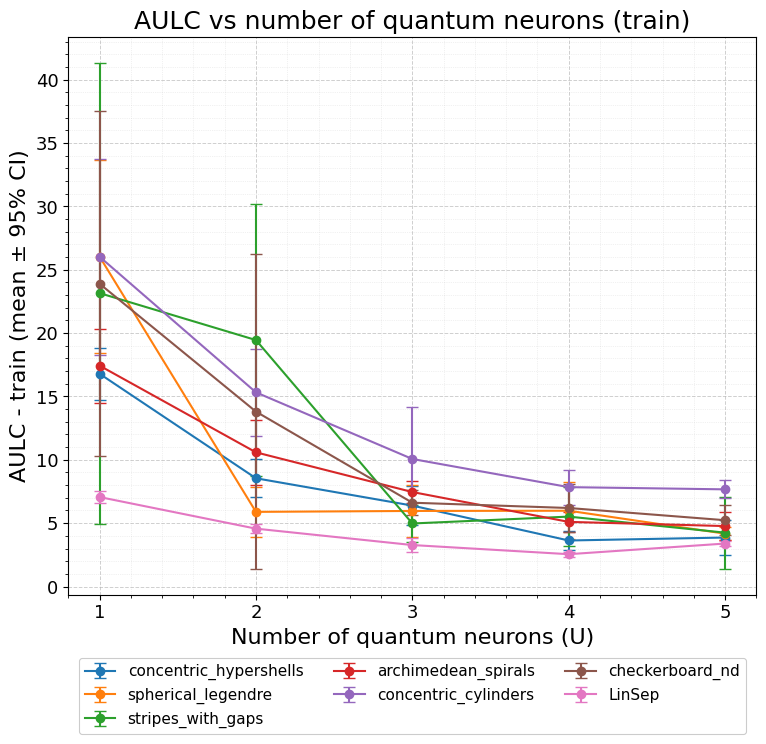

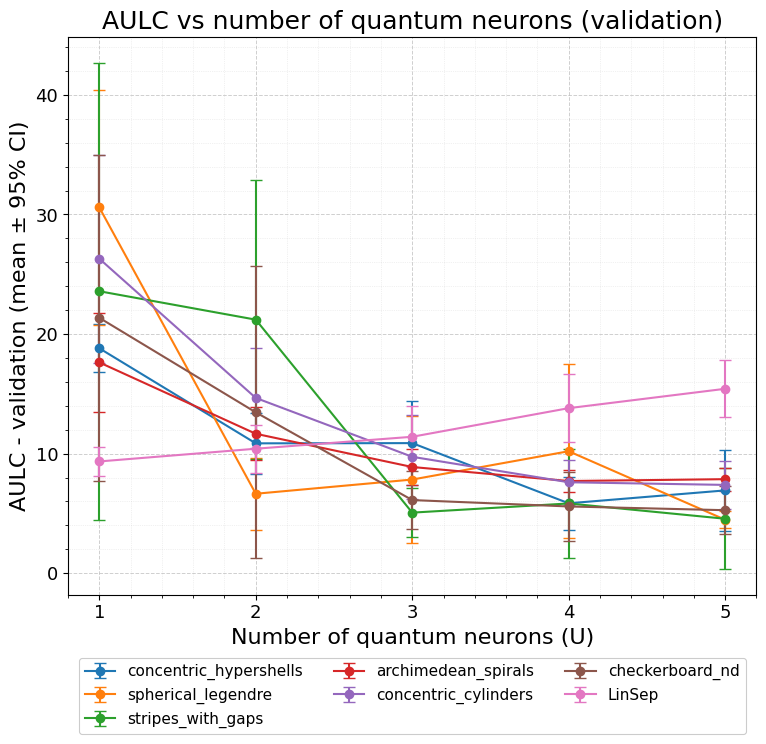

In [ ]:
from matplotlib.ticker import AutoMinorLocator

results = {
    "concentric_hypershells": {
        "train_mean": np.array([16.7923, 8.5441, 6.3865, 3.6324, 3.8662]),
        "train_ci":   np.array([2.0483, 1.5098, 1.5290, 0.7763, 1.4099]),
        "val_mean":   np.array([18.8078, 10.8594, 10.8775, 5.8457, 6.9235]),
        "val_ci":     np.array([2.0135, 2.5428, 3.4955, 2.2230, 3.4035]),
    },
    "spherical_legendre": {
        "train_mean": np.array([26.0413, 5.8924, 5.9643, 5.9820, 4.1708]),
        "train_ci":   np.array([7.5937, 1.9921, 2.0344, 2.2539, 0.5256]),
        "val_mean":   np.array([30.5822, 6.6443, 7.8316, 10.1988, 4.4732]),
        "val_ci":     np.array([9.8233, 3.0120, 5.3177, 7.2797, 0.7188]),
    },
    "stripes_with_gaps": {
        "train_mean": np.array([23.1577, 19.4526, 4.9752, 5.5184, 4.2502]),
        "train_ci":   np.array([18.1994, 10.7520, 1.4620, 2.3503, 2.8364]),
        "val_mean":   np.array([23.5783, 21.2015, 5.0654, 5.8319, 4.5538]),
        "val_ci":     np.array([19.1236, 11.6372, 2.0459, 4.5927, 4.2178]),
    },
    "archimedean_spirals": {
        "train_mean": np.array([17.4334, 10.5909, 7.4576, 5.1011, 4.7709]),
        "train_ci":   np.array([2.9294, 2.5599, 0.8830, 0.7595, 1.1379]),
        "val_mean":   np.array([17.6264, 11.6593, 8.8802, 7.7081, 7.8636]),
        "val_ci":     np.array([4.1489, 2.1997, 1.4877, 0.9089, 0.9539]),
    },
    "concentric_cylinders": {
        "train_mean": np.array([26.0302, 15.3243, 10.0659, 7.8436, 7.6691]),
        "train_ci":   np.array([7.7198, 3.4146, 4.1230, 1.3760, 0.7190]),
        "val_mean":   np.array([26.2980, 14.6559, 9.7339, 7.6044, 7.3842]),
        "val_ci":     np.array([8.6859, 4.1970, 3.5160, 1.8703, 1.9929]),
    },
    "checkerboard_nd": {
        "train_mean": np.array([23.8984, 13.8050,6.6153, 6.1971, 5.2333 ]),
        "train_ci":   np.array([13.6344,12.4371,1.0053, 1.9046,  1.1837  ]),
        "val_mean":   np.array([21.3560,13.4512,6.1157, 5.5816,  5.2690  ]),
        "val_ci":     np.array([13.6155,12.2205, 2.4472,2.8543,  1.9872 ]),
    },
    "LinSep": {
        "train_mean": np.array([7.0616, 4.5669,3.2736, 2.5511, 3.3918 ]),
        "train_ci":   np.array([0.4539, 0.3688, 0.5867, 0.2091, 0.2321  ]),
        "val_mean":   np.array([ 9.3453, 10.4093, 11.4082, 13.8010, 15.4197  ]),
        "val_ci":     np.array([1.2041, 1.9889,2.5326, 2.8209, 2.3851 ]),
    },
}


import numpy as np
import matplotlib.pyplot as plt

# Rebuild results dict from the printed outputs


labels = np.array([1, 2, 3, 4, 5])

# 1) TRAIN
# plt.figure(figsize=(6, 6))  # (width, height)
TITLE_FS = 18
LABEL_FS = 16
TICK_FS  = 13
LEGEND_FS = 11

# --- TRAIN ---
fig, ax = plt.subplots(figsize=(8, 8))
for ds_name in results.keys():
    m = results[ds_name]["train_mean"]
    ci = results[ds_name]["train_ci"]
    ax.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)

ax.set_xlabel("Number of quantum neurons (U)", fontsize=LABEL_FS)
ax.set_ylabel("AULC - train (mean ± 95% CI)", fontsize=LABEL_FS)
ax.set_title("AULC vs number of quantum neurons (train)", fontsize=TITLE_FS)
ax.set_xticks(labels)
ax.tick_params(axis="both", labelsize=TICK_FS)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", axis="both", linestyle="--", linewidth=0.7, alpha=0.6)
ax.grid(True, which="minor", axis="both", linestyle=":",  linewidth=0.5, alpha=0.35)
ax.set_axisbelow(True) 

leg = ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),  # bližšie pod os (skús -0.04 až -0.08)
    ncol=3,
    fontsize=LEGEND_FS,
    frameon=True
)
leg.get_frame().set_linewidth(0.8)
leg.get_frame().set_alpha(1.0)

fig.tight_layout(rect=[0, 0.05, 1, 1])  # len malý priestor dole
plt.show()

# --- VAL ---
fig, ax = plt.subplots(figsize=(8,8))
for ds_name in results.keys():
    m = results[ds_name]["val_mean"]
    ci = results[ds_name]["val_ci"]
    ax.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)

ax.set_xlabel("Number of quantum neurons (U)", fontsize=LABEL_FS)
ax.set_ylabel("AULC - validation (mean ± 95% CI)", fontsize=LABEL_FS)
ax.set_title("AULC vs number of quantum neurons (validation)", fontsize=TITLE_FS)
ax.set_xticks(labels)
ax.tick_params(axis="both", labelsize=TICK_FS)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", axis="both", linestyle="--", linewidth=0.7, alpha=0.6)
ax.grid(True, which="minor", axis="both", linestyle=":",  linewidth=0.5, alpha=0.35)
ax.set_axisbelow(True) 

leg = ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=LEGEND_FS,
    frameon=True
)
leg.get_frame().set_linewidth(0.8)
leg.get_frame().set_alpha(1.0)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


# Test - pridavanie MLP

In [ ]:
datasety = {
    "make_mini_madelon": make_mini_madelon,
    # "make_concentric_cylinders" : make_concentric_cylinders, # N=5
    "make_checkerboard_nd": make_checkerboard_nd, # N=5, N=3 nakoniec
    # # "make_concentric_hypershells": make_concentric_hypershells, # N=7 nakoniec (bolo N=6)
    # "make_spherical_legendre" : make_spherical_legendre, # N=8
    # "make_stripes_with_gaps" : make_stripes_with_gaps, # N=8, N=5 nakoniec
    # "make_spirals_nd_full2" : make_spirals_nd_full2, # N=8
}

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


def aulc_sum(vals):
    # rovnaká logika ako u teba: "AULC (unnormalized) = suma lossov cez epochy"
    return float(np.sum(np.asarray(vals, dtype=np.float64)))

def mean_ci95(values):
    v = np.asarray(values, dtype=np.float64)
    n = v.size
    m = v.mean()
    s = v.std(ddof=1) if n > 1 else 0.0
    # 95% CI pre priemer: t_{0.975, df=n-1}
    # pre n=5 => df=4 => ~2.776
    tcrit = 2.776 if n == 5 else 1.96
    half = tcrit * (s / np.sqrt(n)) if n > 1 else 0.0
    return m, half

def run_one_fold(X_np, y_np, tr_idx, va_idx, mlp_hidden, device):
    # ===== hyperparametre presne ako v tvojom tréningu =====
    START_LR = 1e-2
    END_LR   = 1e-3
    DECAY_EVERY = 2
    DECAY_GAMMA = 0.7

    BATCH_SIZE = 32
    EPOCHS_NORMAL = 10
    EPOCHS_CACHED = 40
    EPOCHS_TOTAL = EPOCHS_NORMAL + EPOCHS_CACHED

    TRAIN_NOISE = 0.01

    SPSA_ITERS = 0
    SPSA_C = 0.02
    Q_DROP = 0.15

    # ===== split =====
    X_tr_np, y_tr_np = X_np[tr_idx], y_np[tr_idx]
    X_va_np, y_va_np = X_np[va_idx], y_np[va_idx]

    # ===== scaler =====
    scaler = StandardScaler()
    X_tr_np = (scaler.fit_transform(X_tr_np).astype(np.float32) * np.sqrt(2)).astype(np.float32)
    X_va_np = (scaler.transform(X_va_np).astype(np.float32)     * np.sqrt(2)).astype(np.float32)

    X_tr = torch.from_numpy(X_tr_np).to(device=device, dtype=torch.float32)
    y_tr = torch.from_numpy(y_tr_np.astype(np.int64)).to(device=device, dtype=torch.long)
    X_va = torch.from_numpy(X_va_np).to(device=device, dtype=torch.float32)
    y_va = torch.from_numpy(y_va_np.astype(np.int64)).to(device=device, dtype=torch.long)

    input_dim = X_tr.shape[1]
    num_classes = int(np.max(y_np) + 1)

    # ===== model: q_depth fix=2, MLP meníš cez mlp_hidden =====
    model = HybridQMLP(
        input_dim=input_dim,
        q_units=2,          # fix
        q_depth=2,          # fix
        num_classes=num_classes,
        mlp_hidden=mlp_hidden,
        seed=3,
        shots=3000,
        simulate_sampling=True,
        readout_error=0.01,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=START_LR)

    # ===== dataloadery =====
    train_loader = DataLoader(
        TensorDataset(X_tr, y_tr),
        batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
        pin_memory=False, num_workers=0
    )
    val_loader = DataLoader(
        TensorDataset(X_va, y_va),
        batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
        pin_memory=False, num_workers=0
    )

    cache_ready = False
    cached_train_loader = None
    cached_val_loader = None

    train_loss_hist = []
    eval_loss_hist = []

    for epoch in range(1, EPOCHS_TOTAL + 1):
        # LR decay (rovnako)
        if DECAY_EVERY > 0 and epoch > 1 and ((epoch - 1) % DECAY_EVERY == 0):
            new_lr = get_optimizer_lr(optimizer) * DECAY_GAMMA
            if END_LR is not None:
                new_lr = max(float(END_LR), float(new_lr))
            set_optimizer_lr_(optimizer, new_lr)

        cached_mode = (epoch > EPOCHS_NORMAL)

        if cached_mode and (not cache_ready):
            feats_tr = build_E_cache(model, X_tr, batch_size=256)  # CPU
            feats_va = build_E_cache(model, X_va, batch_size=256)  # CPU

            y_tr_cpu = y_tr.detach().cpu()
            y_va_cpu = y_va.detach().cpu()

            cached_train_loader = DataLoader(
                CachedFeatsDataset(feats_tr, y_tr_cpu),
                batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                pin_memory=False, num_workers=0
            )
            cached_val_loader = DataLoader(
                CachedFeatsDataset(feats_va, y_va_cpu),
                batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                pin_memory=False, num_workers=0
            )

            for p in model.q.parameters():
                p.requires_grad_(False)

            cache_ready = True

        model.train()
        running_loss = 0.0
        running_n = 0

        if not cached_mode:
            for xb, yb in train_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                if TRAIN_NOISE > 0.0:
                    xb = xb + torch.randn_like(xb) * TRAIN_NOISE

                base_loss, _ = train_step(
                    model, optimizer, xb, yb,
                    spsa_iters=SPSA_ITERS,
                    spsa_c=SPSA_C,
                    q_grad_drop_p=Q_DROP,
                )

                running_loss += float(base_loss.item()) * yb.numel()
                running_n += yb.numel()

            train_loss = running_loss / max(running_n, 1)
            eval_loss, _ = eval_epoch(model, val_loader, device)

        else:
            assert cached_train_loader is not None and cached_val_loader is not None

            for feats, yb in cached_train_loader:
                feats = feats.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                logits = model.mlp(feats)
                base_loss = F.cross_entropy(logits, yb)
                loss = base_loss + mlp_l1_l2_penalty(model, l1=1e-6, l2=1e-4)
                loss.backward()
                optimizer.step()

                running_loss += float(base_loss.item()) * yb.numel()
                running_n += yb.numel()

            train_loss = running_loss / max(running_n, 1)
            eval_loss, _ = eval_epoch_cached(model, cached_val_loader, device)

        train_loss_hist.append(float(train_loss))
        eval_loss_hist.append(float(eval_loss))

    aulc_train = aulc_sum(train_loss_hist)
    aulc_val   = aulc_sum(eval_loss_hist)

    # cleanup (bez zmeny logiky)
    del model, optimizer, train_loader, val_loader, cached_train_loader, cached_val_loader
    if device == "cuda":
        torch.cuda.empty_cache()

    return aulc_train, aulc_val



if __name__ == "__main__":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("device:", device)

    # nastavenia testu
    mlp_list = [
        (16,),
        (32,),
        (64,),
        (128,),
        (192,),
        (256,)
    ]
    labels = ["-".join(map(str, h)) for h in mlp_list]

    results = {}

    for ds_name, ds_fn in datasety.items():
        X_np, y_np = ds_fn()
        y_np = y_np.astype(np.int64)

        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
        splits = list(cv.split(X_np, y_np))

        train_mean, train_ci = [], []
        val_mean, val_ci = [], []

        for mlp_hidden in mlp_list:
            fold_train = []
            fold_val = []

            for tr_idx, va_idx in splits:
                atr, ava = run_one_fold(
                    X_np, y_np, tr_idx, va_idx,
                    mlp_hidden=mlp_hidden,
                    device=device
                )
                fold_train.append(atr)
                fold_val.append(ava)

            m_tr, h_tr = mean_ci95(fold_train)
            m_va, h_va = mean_ci95(fold_val)

            train_mean.append(m_tr); train_ci.append(h_tr)
            val_mean.append(m_va);   val_ci.append(h_va)

            print(f"mlp={mlp_hidden}: train {m_tr:.4f} ± {h_tr:.4f} | val {m_va:.4f} ± {h_va:.4f}")

        results[ds_name] = {
            "train_mean": np.asarray(train_mean, dtype=np.float64),
            "train_ci":   np.asarray(train_ci,   dtype=np.float64),
            "val_mean":   np.asarray(val_mean,   dtype=np.float64),
            "val_ci":     np.asarray(val_ci,     dtype=np.float64),
        }

    # --- 3) grafy: len zmeň popisky osi
    plt.figure()
    for ds_name in datasety.keys():
        m = results[ds_name]["train_mean"]
        ci = results[ds_name]["train_ci"]
        plt.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)
    plt.xlabel("mlp_hidden")
    plt.ylabel("AULC train (sum of epoch losses)")
    plt.title("AULC train (5-fold CV) + 95% CI")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

    plt.figure()
    for ds_name in datasety.keys():
        m = results[ds_name]["val_mean"]
        ci = results[ds_name]["val_ci"]
        plt.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)
    plt.xlabel("mlp_hidden")
    plt.ylabel("AULC val (sum of epoch losses)")
    plt.title("AULC val (5-fold CV) + 95% CI")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()



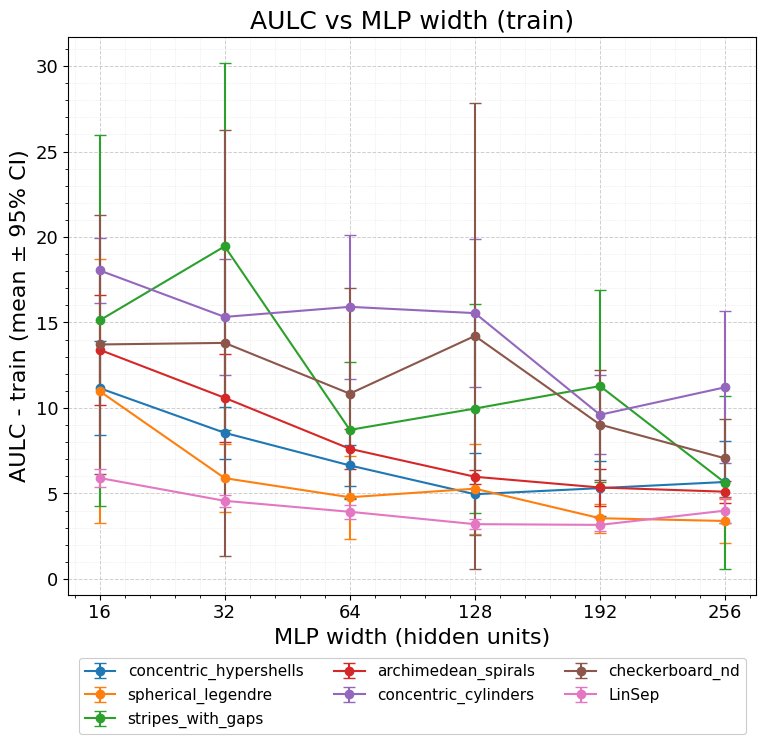

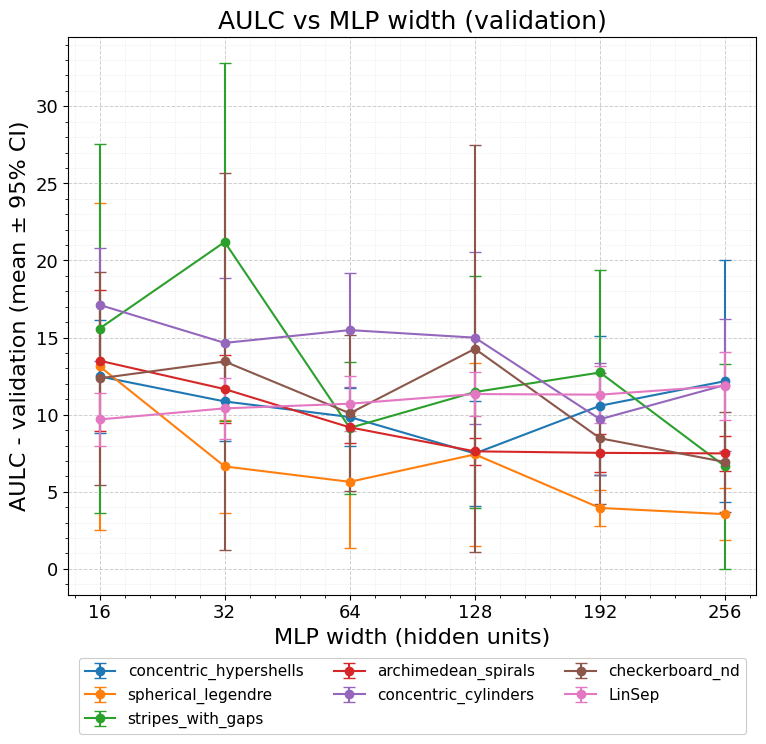

In [23]:
results = {
    "concentric_hypershells": {
        "train_mean": np.array([11.15852507,  8.54405273,  6.63715958,  4.95246478,  5.30892102,  5.66815867], dtype=np.float64),
        "train_ci":   np.array([ 2.73655268,  1.50983133,  1.18445927,  2.40427974,  1.61535668,  2.42023481], dtype=np.float64),
        "val_mean":   np.array([12.48093   , 10.85937847,  9.84863801,  7.48657231, 10.57854102, 12.17678297], dtype=np.float64),
        "val_ci":     np.array([ 3.68598912,  2.54277365,  1.8947708 ,  3.41877875,  4.49720401,  7.85661625], dtype=np.float64),
    },
    "spherical_legendre": {
        "train_mean": np.array([10.98593253,  5.89241976,  4.77524775,  5.27746429,  3.54814294,  3.38726921], dtype=np.float64),
        "train_ci":   np.array([ 7.7007955 ,  1.9920596 ,  2.42628016,  2.64089963,  0.85211445,  1.31261266], dtype=np.float64),
        "val_mean":   np.array([13.1353808 ,  6.64427057,  5.64538561,  7.4246237 ,  3.95255797,  3.5492289 ], dtype=np.float64),
        "val_ci":     np.array([10.61371802,  3.01199604,  4.28101971,  5.95783213,  1.18469379,  1.7019081 ], dtype=np.float64),
    },
    "stripes_with_gaps": {
        "train_mean": np.array([15.11792259, 19.45263056,  8.71681055,  9.96378885, 11.27978998,  5.62012329], dtype=np.float64),
        "train_ci":   np.array([10.86897142, 10.75198077,  3.97311616,  6.10158161,  5.62484228,  5.05274788], dtype=np.float64),
        "val_mean":   np.array([15.58752488, 21.20152532,  9.14231402, 11.46903235, 12.7364997 ,  6.64325857], dtype=np.float64),
        "val_ci":     np.array([11.94340451, 11.63715965,  4.28463063,  7.52409384,  6.63867218,  6.66337388], dtype=np.float64),
    },
    "archimedean_spirals": {
        "train_mean": np.array([13.40499111, 10.59085899,  7.6106128 ,  5.97417888,  5.3458211 ,  5.09988278], dtype=np.float64),
        "train_ci":   np.array([ 3.22239742,  2.55994009,  1.16320427,  0.40171793,  1.06027937,  0.63603845], dtype=np.float64),
        "val_mean":   np.array([13.50110483, 11.65925272,  9.17881073,  7.62296341,  7.52376676,  7.48949782], dtype=np.float64),
        "val_ci":     np.array([ 4.57552097,  2.19970273,  1.04109495,  0.85749259,  1.25566977,  1.12020419], dtype=np.float64),
    },
    "concentric_cylinders": {
        "train_mean": np.array([18.04525367, 15.32426666, 15.9140133 , 15.54630518,  9.60048007, 11.20873144], dtype=np.float64),
        "train_ci":   np.array([ 1.88970567,  3.41455341,  4.22203124,  4.31841357,  2.31352149,  4.44191408], dtype=np.float64),
        "val_mean":   np.array([17.11991556, 14.65593488, 15.48593792, 14.99575341,  9.70713924, 11.92737212], dtype=np.float64),
        "val_ci":     np.array([ 3.66698011,  4.19697372,  3.69512384,  5.5698768 ,  3.64084515,  4.26280613], dtype=np.float64),
    },
    "checkerboard_nd": {
        "train_mean": np.array([13.71269832, 13.80503026, 10.83429658, 14.21189336,  9.02544852,  7.05004382], dtype=np.float64),
        "train_ci":   np.array([ 7.56761967, 12.4370751 ,  6.16467059, 13.6299037 ,  3.2162995 ,  2.28522467], dtype=np.float64),
        "val_mean":   np.array([12.35765098, 13.45117631, 10.09012857, 14.27345518,  8.46959733,  6.93040603], dtype=np.float64),
        "val_ci":     np.array([ 6.92467453, 12.22053953,  5.05069704, 13.20869846,  4.26309921,  3.23565792], dtype=np.float64),
    },    
    "LinSep": {
        "train_mean": np.array([5.9025, 4.5669, 3.9251, 3.2018, 3.1589, 3.9918], dtype=np.float64),
        "train_ci":   np.array([0.5437, 0.3688, 0.3993, 0.2992, 0.3756, 0.7150], dtype=np.float64),
        "val_mean":   np.array([ 9.6911, 10.4093, 10.7122, 11.3380, 11.2993, 11.8716], dtype=np.float64),
        "val_ci":     np.array([ 1.7189,  1.9889,  1.7730,  1.4354,  1.8353, 2.2197], dtype=np.float64),
    }
}



import numpy as np
import matplotlib.pyplot as plt


# ak chceš mať premennú "result" (singular)
result = results

# ====== labels pre x-os (musia mať rovnakú dĺžku ako mean/ci = 6) ======
mlp_list = [(16,), (32,), (64,), (128,), (192,), (256,)]
labels = ["-".join(map(str, h)) for h in mlp_list]

# len aby si mohol iterovať ako v pôvodnom kóde
datasety = {name: None for name in results.keys()}

# ====== GRAFY ======

# 1) TRAIN
TITLE_FS = 18
LABEL_FS = 16
TICK_FS  = 13
LEGEND_FS = 11

# --- TRAIN ---
fig, ax = plt.subplots(figsize=(8, 8))
for ds_name in results.keys():
    m = results[ds_name]["train_mean"]
    ci = results[ds_name]["train_ci"]
    ax.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)

ax.set_xlabel("MLP width (hidden units)", fontsize=LABEL_FS)
ax.set_ylabel("AULC - train (mean ± 95% CI)", fontsize=LABEL_FS)
ax.set_title("AULC vs MLP width (train)", fontsize=TITLE_FS)
ax.set_xticks(labels)
ax.tick_params(axis="both", labelsize=TICK_FS)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", axis="both", linestyle="--", linewidth=0.7, alpha=0.6)
ax.grid(True, which="minor", axis="both", linestyle=":",  linewidth=0.5, alpha=0.35)
ax.set_axisbelow(True) 

leg = ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),  # bližšie pod os (skús -0.04 až -0.08)
    ncol=3,
    fontsize=LEGEND_FS,
    frameon=True
)
leg.get_frame().set_linewidth(0.8)
leg.get_frame().set_alpha(1.0)

fig.tight_layout(rect=[0, 0.05, 1, 1])  # len malý priestor dole
plt.show()

# --- VAL ---
fig, ax = plt.subplots(figsize=(8,8))
for ds_name in results.keys():
    m = results[ds_name]["val_mean"]
    ci = results[ds_name]["val_ci"]
    ax.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)

ax.set_xlabel("MLP width (hidden units)", fontsize=LABEL_FS)
ax.set_ylabel("AULC - validation (mean ± 95% CI)", fontsize=LABEL_FS)
ax.set_title("AULC vs MLP width (validation)", fontsize=TITLE_FS)
ax.set_xticks(labels)
ax.tick_params(axis="both", labelsize=TICK_FS)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", axis="both", linestyle="--", linewidth=0.7, alpha=0.6)
ax.grid(True, which="minor", axis="both", linestyle=":",  linewidth=0.5, alpha=0.35)
ax.set_axisbelow(True) 

leg = ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=LEGEND_FS,
    frameon=True
)
leg.get_frame().set_linewidth(0.8)
leg.get_frame().set_alpha(1.0)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


# Test - pridavanie U, pevne kodovanie (Ry) a dekodovanie (X baza)

model

In [ ]:
import math
import itertools
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchquantum as tq
import torchquantum.functional as tqf


# ----------------- helper: indexy pre <Zi> a <ZiZj> -----------------
def build_z_and_zz_indices(n_qubits: int, device) -> Tuple[torch.Tensor, torch.Tensor, int]:
    pairs = list(itertools.combinations(range(n_qubits), 2))
    if len(pairs) == 0:
        pair_i = torch.empty(0, device=device, dtype=torch.long)
        pair_j = torch.empty(0, device=device, dtype=torch.long)
    else:
        pair_i = torch.tensor([p[0] for p in pairs], device=device, dtype=torch.long)
        pair_j = torch.tensor([p[1] for p in pairs], device=device, dtype=torch.long)
    T = n_qubits + len(pairs)
    return pair_i, pair_j, T


# ----------------- analytické eigény pre Z a ZZ -----------------
def build_z_eigs(n_qubits: int, device):
    dim = 1 << n_qubits
    idx = torch.arange(dim, device=device, dtype=torch.long).unsqueeze(1)          # (2^N,1)
    bitpos = torch.arange(n_qubits, device=device, dtype=torch.long).unsqueeze(0) # (1,N)
    bits = ((idx >> bitpos) & 1).float()                                          # (2^N,N)
    z_eigs = 1.0 - 2.0 * bits                                                     # (2^N,N)
    return z_eigs

def probs_from_qdev(qdev: tq.QuantumDevice) -> torch.Tensor:
    st = qdev.states
    if st.dim() > 2:
        st = st.reshape(st.shape[0], -1)  # (bsz, 2^N)
    probs = (st.abs() ** 2).real
    return probs


def expvals_z_and_zz_from_probs(probs: torch.Tensor,
                               z_eigs: torch.Tensor,
                               zz_eigs: Optional[torch.Tensor]):
    # analyticky z pravdepodobností (diferencovateľné)
    expZ = probs @ z_eigs  # (bsz, N)
    if zz_eigs is not None and zz_eigs.numel() > 0:
        expZZ = probs @ zz_eigs  # (bsz, num_pairs)
        return torch.cat([expZ, expZZ], dim=1)
    return expZ


@torch.no_grad()
def expvals_z_and_zz_from_counts(probs: torch.Tensor,
                                n_qubits: int,
                                pair_i: torch.Tensor,
                                pair_j: torch.Tensor,
                                shots: int,
                                readout_p: float = 0.01) -> torch.Tensor:
    """
    Vypočíta expvaly zo shotov (implicitne z counts), s voliteľným readout bit-flip errorom.
    Všetko na GPU, plne vektorové.

    probs: (bsz, 2^N)
    return: (bsz, T) kde T = N + N*(N-1)//2
    """
    # (bsz, shots) vzorkované bitstringy ako integer indexy 0..2^N-1
    idx = torch.multinomial(probs, num_samples=shots, replacement=True)  # long

    if readout_p is not None and readout_p > 0.0:
        # vygeneruj flip masku (bsz, shots) ako bitset cez jednu rand alokáciu
        # flips: (bsz, shots, N) bool
        flips = (torch.rand((idx.shape[0], idx.shape[1], n_qubits), device=idx.device) < readout_p)
        bitpos = torch.arange(n_qubits, device=idx.device, dtype=torch.long)  # (N,)
        mask = (flips.to(torch.long) << bitpos).sum(dim=-1)  # (bsz, shots)
        idx = idx ^ mask

    bitpos = torch.arange(n_qubits, device=idx.device, dtype=torch.long)  # (N,)
    bits = ((idx.unsqueeze(-1) >> bitpos) & 1).to(torch.bool)  # (bsz, shots, N)

    dtype = probs.dtype
    expZ = 1.0 - 2.0 * bits.to(dtype).mean(dim=1)  # (bsz, N)

    if pair_i.numel() > 0:
        xor_ij = bits[..., pair_i] ^ bits[..., pair_j]  # (bsz, shots, num_pairs)
        expZZ = 1.0 - 2.0 * xor_ij.to(dtype).mean(dim=1)  # (bsz, num_pairs)
        return torch.cat([expZ, expZZ], dim=1)

    return expZ



def expvals_z_and_zz_analytical(qdev: tq.QuantumDevice,
                               z_eigs: torch.Tensor,
                               zz_eigs: Optional[torch.Tensor]):
    st = qdev.states
    if st.dim() > 2:
        st = st.reshape(st.shape[0], -1)              # (bsz, 2^N)
    probs = (st.abs() ** 2).real                      # (bsz, 2^N)
    expZ = probs @ z_eigs                             # (bsz, N)
    if zz_eigs is not None and zz_eigs.numel() > 0:
        expZZ = probs @ zz_eigs                       # (bsz, num_pairs)
        return torch.cat([expZ, expZZ], dim=1)        # (bsz, T)
    return expZ


# ----------------- 1) reuploading ansatz -----------------
# ----------------- 1) reuploading ansatz (CHANGED: iba RY(z_i), trainujú sa len entanglery; na konci X-báza cez H) -----------------
class ReuploadingAnsatz(tq.QuantumModule):
    def __init__(self, n_qubits: int, depth: int):
        super().__init__()
        self.n_qubits = int(n_qubits)
        self.depth = int(depth)

        N = self.n_qubits
        p = 0

        if N == 2:
            pairs_even = [(0, 1)]
            pairs_odd  = [(0, 1)]
        else:
            pairs_even = [(i, i + 1) for i in range(0, N - 1, 2)]
            pairs_odd  = [(i, i + 1) for i in range(1, N - 1, 2)]

        # iba trainable entanglery (RZZ)
        rzz_layers = [[] for _ in range(depth)]  # [(q1,q2,pidx), ...]
        for d in range(depth):
            use_pairs = pairs_even if (d % 2) == 0 else pairs_odd
            for (i, j) in use_pairs:
                rzz_layers[d].append((i, j, p))
                p += 1

        self.P = int(p)
        self.rzz_layers = rzz_layers

    @staticmethod
    def _expand_param_per_sample(theta_u: torch.Tensor, B: int):
        U = theta_u.numel()
        return theta_u.unsqueeze(0).expand(B, U).reshape(B * U)

    @tq.static_support
    def forward(self, qdev: tq.QuantumDevice, x_flat: torch.Tensor, theta_U: torch.Tensor):
        """
        x_flat:  (B*U, N)  -> tu už máš Z = x*w + b
        theta_U: (U, P)    -> iba entangler parametre
        """
        BU, N = x_flat.shape
        U = theta_U.shape[0]
        B = BU // U
        device = x_flat.device
        dtype = x_flat.dtype

        # ---- DATA ENCODING: iba RY(z_i) na každom qubite (každá vrstva reuploaduje) ----
        for d in range(self.depth):
            for q in range(N):
                tqf.ry(qdev, wires=q, params=x_flat[:, q])

            # ---- trainable entanglery (RZZ) ----
            rzz = self.rzz_layers[d]
            if len(rzz) > 0:
                for (q1, q2, pidx) in rzz:
                    th = theta_U[:, pidx]                 # (U,)
                    th_bu = self._expand_param_per_sample(th, B)  # (BU,)
                    tqf.rzz(qdev, wires=[q1, q2], params=th_bu)

        # ---- MERANIE V X BÁZE: aplikuj H na každý qubit a potom meriaš Z (tvoje expvaly) ----
        H = torch.tensor([[1.0, 1.0], [1.0, -1.0]], device=device, dtype=dtype) / math.sqrt(2.0)
        H_bu = H.unsqueeze(0).expand(BU, 2, 2)  # (BU,2,2)

        for q in range(N):
            tqf.qubitunitaryfast(qdev, wires=q, params=H_bu)


# ----------------- 3) QuantumLayer: autograd pre in_w/in_b, PSR pre params_U -----------------
class QuantumLayerTQ(nn.Module):
    def __init__(self, in_dim: int, units: int, depth: int, seed: int = 0,
                 shots: Optional[int] = None, readout_error: float = 0.01,
                 simulate_sampling: bool = False):
        super().__init__()
        torch.manual_seed(seed)

        self.in_dim = int(in_dim)
        self.n_qubits = self.in_dim
        self.units = int(units)
        self.depth = int(depth)
        self.shots = shots
        self.readout_error = float(readout_error)
        self.simulate_sampling = bool(simulate_sampling)



        # per-neuron affine na vstup (U,N)
        self.in_w = nn.Parameter(torch.randn(self.units, self.in_dim) * 0.05 + 1.0)
        self.in_b = nn.Parameter(torch.zeros(self.units, self.in_dim))

        self.ansatz = ReuploadingAnsatz(self.n_qubits, self.depth)
        self.P = self.ansatz.P

        # θ pre každý neurón: (U,P)
        self.params_U = nn.Parameter(self._init_theta(self.units, self.P, self.n_qubits))

        # measurement caches
        self.register_buffer("pair_i", torch.empty(0, dtype=torch.long), persistent=False)
        self.register_buffer("pair_j", torch.empty(0, dtype=torch.long), persistent=False)
        self.register_buffer("z_eigs", torch.empty(0), persistent=False)
        self.register_buffer("zz_eigs", torch.empty(0), persistent=False)
        self.T = None

        # reuse QuantumDevice
        self.qdev: Optional[tq.QuantumDevice] = None
        self._qdev_devstr: Optional[str] = None

    def _init_theta(self, U: int, P: int, N: int):
        # iba RZZ parametre
        rzz_sigma = 1.0 / math.sqrt(N)
        theta = torch.randn(U, P) * rzz_sigma
        return theta


    def _ensure_measure_cache(self, device):
        if self.z_eigs.numel() == 0 or self.z_eigs.device != device:
            self.z_eigs = build_z_eigs(self.n_qubits, device=device)
            pair_i, pair_j, T = build_z_and_zz_indices(self.n_qubits, device=device)
            self.pair_i, self.pair_j, self.T = pair_i, pair_j, T
            if pair_i.numel() > 0:
                self.zz_eigs = self.z_eigs[:, pair_i] * self.z_eigs[:, pair_j]  # (2^N, num_pairs)
            else:
                self.zz_eigs = torch.empty(0, device=device)

    def _ensure_qdev(self, x: torch.Tensor):
        devstr = "cuda" if x.is_cuda else "cpu"
        if self.qdev is None or self._qdev_devstr != devstr:
            self.qdev = tq.QuantumDevice(n_wires=self.n_qubits, device=devstr)
            self._qdev_devstr = devstr

    def forward_analytic_from_xflat(self, x_flat: torch.Tensor, B: int, theta_U: torch.Tensor):
        self._ensure_measure_cache(x_flat.device)
        self._ensure_qdev(x_flat)

        BU = x_flat.shape[0]
        U = theta_U.shape[0]

        assert self.qdev is not None
        self.qdev.reset_states(BU)
        self.ansatz(self.qdev, x_flat, theta_U)

        probs = probs_from_qdev(self.qdev)  # (BU, 2^N)

        shots = self.shots
        if shots is not None and shots <= 0:
            shots = None

        if shots is None:
            # ideálne (analytické) expvaly
            e_flat = expvals_z_and_zz_from_probs(probs, self.z_eigs, self.zz_eigs)  # (BU,T) alebo (BU,N)
            return e_flat.view(B, U, self.T)
        
        # --- simulate sampling: bez multinomial, len gaussian shot-noise okolo mean ---
        if self.simulate_sampling:
            e_mean = expvals_z_and_zz_from_probs(probs, self.z_eigs, self.zz_eigs)  # (BU,T)
            # zahrň priemer readout erroru (rovnako ako v ST vetve nižšie)
            p = self.readout_error
            if p > 0.0:
                a = 1.0 - 2.0 * p
                a2 = a * a
                e_mean = e_mean.clone()
                e_mean[:, :self.n_qubits] *= a
                if self.pair_i.numel() > 0:
                    e_mean[:, self.n_qubits:] *= a2

            shots_f = float(shots)
            sigma = torch.sqrt(torch.clamp(1.0 - e_mean * e_mean, min=0.0) / shots_f)
            e_sim = e_mean + torch.randn_like(e_mean) * sigma

            if torch.is_grad_enabled():
                e_flat = e_mean + (e_sim - e_mean).detach()
            else:
                e_flat = e_sim

            return e_flat.view(B, U, self.T)


        # --- shots/counts path + readout error ---
        e_shot = expvals_z_and_zz_from_counts(
            probs=probs,
            n_qubits=self.n_qubits,
            pair_i=self.pair_i,
            pair_j=self.pair_j,
            shots=int(shots),
            readout_p=self.readout_error,
        )  # (BU, T)

        # ak sme v tréningu (grad enabled), zachovaj autograd cez analytiku (ST estimator),
        # ale forward hodnota bude zo shotov (counts)
        if torch.is_grad_enabled():
            e_ideal = expvals_z_and_zz_from_probs(probs, self.z_eigs, self.zz_eigs)  # (BU,T)

            # aby backward zodpovedal priemeru readout erroru:
            p = self.readout_error
            if p > 0.0:
                a = 1.0 - 2.0 * p
                a2 = a * a
                e_ideal = e_ideal.clone()
                e_ideal[:, :self.n_qubits] *= a
                if self.pair_i.numel() > 0:
                    e_ideal[:, self.n_qubits:] *= a2

            e_flat = e_ideal + (e_shot - e_ideal).detach()
        else:
            e_flat = e_shot

        return e_flat.view(B, U, self.T)


    def forward_analytic(self, x: torch.Tensor, theta_override: Optional[torch.Tensor] = None):
        """
        x: (B,N)
        theta_override: (U,P) – keď dáš detach, autograd nepôjde do params_U (PSR to doráta)
        return E: (B,U,T)
        """
        B, N = x.shape
        assert N == self.in_dim
        U = self.units
        BU = B * U

        Z = x[:, None, :] * self.in_w[None, :, :] + self.in_b[None, :, :]  # (B,U,N)
        x_flat = Z.reshape(BU, N)

        theta_U = theta_override if theta_override is not None else self.params_U
        return self.forward_analytic_from_xflat(x_flat, B, theta_U)


# ----------------- 4) hybrid MLP -----------------
class HybridQMLP(nn.Module):
    def __init__(self, input_dim: int, q_units: int, q_depth: int, num_classes: int,
                 mlp_hidden=(32,), seed: int = 0,
                 shots: Optional[int] = None, readout_error: float = 0.01,
                 simulate_sampling: bool = False):
        super().__init__()
        self.q = QuantumLayerTQ(in_dim=input_dim, units=q_units, depth=q_depth, seed=seed,
                                shots=shots, readout_error=readout_error, simulate_sampling=simulate_sampling)


        N = input_dim
        T = N + (N * (N - 1)) // 2
        in_feats = q_units * T

        layers = []
        prev = in_feats
        for h in mlp_hidden:
            # layers += [nn.Linear(prev, int(h)), nn.ReLU()]
            layers += [nn.Linear(prev, int(h)), nn.ReLU(), nn.Dropout(p=0.1)]

            prev = int(h)
        layers += [nn.Linear(prev, int(num_classes))]
        self.mlp = nn.Sequential(*layers)

    def forward(self, x, E_override=None):
        if E_override is None:
            E = self.q.forward_analytic(x)
        else:
            E = E_override
        feats = E.reshape(x.size(0), -1)
        return self.mlp(feats), E


# ===================== SPSA (BATCHED): 1 veľký quantum forward pre všetky iterácie naraz =====================
@torch.no_grad()
def spsa_grad_qparams_and_inwb_batched(
    model: "HybridQMLP",
    x: torch.Tensor,
    y: torch.Tensor,
    iters: int,
    c: float = 0.02,
    gamma: float = 0.0,   # ak chceš "rôzne c" per iter: napr. gamma=0.101 (Robbins-Monro style)
):
    """
    SPSA gradient pre params_U + in_w + in_b, ale zbatched:
    - vygeneruje K perturbácií (delta_k)
    - spraví JEDEN veľký forward pre všetky (+) aj (-) naraz  -> 2K variantov
    - per iter: diff_k = mean_b[(L+ - L-)/(2*c_k)]
    - gradient: g = mean_k[ diff_k * delta_k ]  (pre ±1 platí 1/delta = delta)

    Návrat: (grad_theta(U,P), grad_w(U,N), grad_b(U,N))
    """
    K = int(iters)
    assert K > 0

    q = model.q
    B, N = x.shape
    U, P = q.params_U.shape

    theta0 = q.params_U.detach()
    w0 = q.in_w.detach()
    b0 = q.in_b.detach()

    D_theta = theta0.numel()
    D_w = w0.numel()
    D_b = b0.numel()
    D = D_theta + D_w + D_b

    dev = theta0.device
    dtype = theta0.dtype

    v0 = torch.cat([theta0.reshape(-1), w0.reshape(-1), b0.reshape(-1)]).to(dev, dtype)

    # deltas: (K, D) v {-1, +1}
    deltas = torch.empty((K, D), device=dev, dtype=dtype).bernoulli_(0.5)
    deltas = deltas * 2.0 - 1.0

    # c_k (K,)
    if gamma and gamma != 0.0:
        k = torch.arange(1, K + 1, device=dev, dtype=dtype)
        c_vec = c / (k ** gamma)
    else:
        c_vec = torch.full((K,), float(c), device=dev, dtype=dtype)

    # v_plus/v_minus: (K, D)
    v_plus  = v0.unsqueeze(0) + c_vec.unsqueeze(1) * deltas
    v_minus = v0.unsqueeze(0) - c_vec.unsqueeze(1) * deltas

    # stack (+ potom -): (2K, D)
    v_pm = torch.cat([v_plus, v_minus], dim=0)

    # unpack -> theta_pm: (2K, U, P), w_pm/b_pm: (2K, U, N)
    off = 0
    theta_pm = v_pm[:, off:off + D_theta].view(2 * K, U, P); off += D_theta
    w_pm     = v_pm[:, off:off + D_w].view(2 * K, U, N);     off += D_w
    b_pm     = v_pm[:, off:off + D_b].view(2 * K, U, N)

    # sprav "mega-unit" dim: U_ext = (2K)*U
    U_ext = 2 * K * U
    theta_ext = theta_pm.reshape(U_ext, P)   # (U_ext, P)
    w_ext     = w_pm.reshape(U_ext, N)       # (U_ext, N)
    b_ext     = b_pm.reshape(U_ext, N)       # (U_ext, N)

    # Z_ext: (B, U_ext, N) a flatten pre quantum: (B*U_ext, N)
    Z_ext = x[:, None, :] * w_ext[None, :, :] + b_ext[None, :, :]
    xflat_ext = Z_ext.reshape(B * U_ext, N)

    # JEDEN veľký quantum forward: (B, U_ext, T)
    E_ext = q.forward_analytic_from_xflat(xflat_ext, B, theta_ext)  # (B, U_ext, T)

    # reshapy: (B, 2K, U, T) -> MLP potrebuje (batch, U*T)
    E_ext = E_ext.view(B, 2 * K, U, q.T)
    feats = E_ext.reshape(B * (2 * K), -1)          # (B*2K, U*T)
    logits = model.mlp(feats)                       # (B*2K, C)

    y_pm = y[:, None].expand(B, 2 * K).reshape(-1)  # (B*2K,)
    losses = F.cross_entropy(logits, y_pm, reduction="none").view(B, 2 * K)  # (B,2K)

    loss_plus  = losses[:, :K]      # (B,K)
    loss_minus = losses[:, K:]      # (B,K)

    # diff[b,k] = (L+ - L-)/(2*c_k)
    diff = (loss_plus - loss_minus) / (2.0 * c_vec.unsqueeze(0))  # (B,K)
    diff_mean = diff.mean(dim=0)                                   # (K,)

    # g_k = diff_mean[k] * delta_k  ; g = mean_k g_k
    g = (diff_mean.unsqueeze(1) * deltas).mean(dim=0)              # (D,)

    # unpack gradient
    off = 0
    g_theta = g[off:off + D_theta].view(U, P); off += D_theta
    g_w     = g[off:off + D_w].view(U, N);     off += D_w
    g_b     = g[off:off + D_b].view(U, N)

    return g_theta, g_w, g_b


# ----------------- 5) PSR gradient pre params_U (NEZNIŽUJEME počet forwardov) -----------------
@torch.no_grad()
def psr_grad_paramsU_slow(q_layer: QuantumLayerTQ,
                          x: torch.Tensor,
                          delta_E: torch.Tensor,
                          shift: float = math.pi / 2):
    """
    delta_E: (B,U,T) = dL/dE
    return grads: (U,P)
    Počet forwardov: 2*U*P (presne ako tvoja pomalšia verzia).
    Zrýchlenie je z recyklácie qdev + cache + reuse x_flat.
    """
    base = q_layer.params_U.detach()
    U, P = base.shape
    grads = torch.zeros_like(base)

    # reuse x_flat (PSR nepotrebuje grad cez in_w/in_b)
    B, N = x.shape
    Z = x[:, None, :] * q_layer.in_w[None, :, :] + q_layer.in_b[None, :, :]  # (B,U,N)
    x_flat = Z.reshape(B * U, N).detach()

    for u in range(U):
        for p in range(P):
            th_plus = base.clone()
            th_minus = base.clone()
            th_plus[u, p] += shift
            th_minus[u, p] -= shift

            E_plus = q_layer.forward_analytic_from_xflat(x_flat, B, th_plus)   # (B,U,T)
            E_minus = q_layer.forward_analytic_from_xflat(x_flat, B, th_minus)

            dE = 0.5 * (E_plus - E_minus)  # (B,U,T)
            grads[u, p] = (delta_E * dE).sum()

    return grads

# ===================== NOVÉ: PSR pre in_w a in_b (gradient cez vstupné uhly z = x*w + b) =====================
@torch.no_grad()
def psr_grad_in_wb_batched(q_layer: QuantumLayerTQ,
                           x: torch.Tensor,
                           delta_E: torch.Tensor,
                           shift: float = math.pi / 2):
    """
    Vypočíta gradienty pre in_w (U,N) a in_b (U,N) iba pomocou PSR.
    delta_E: (B,U,T) = dL/dE z klasickej časti (MLP).
    Návrat:
      grad_w: (U,N)
      grad_b: (U,N)
    """
    base_theta = q_layer.params_U.detach()
    B, N = x.shape
    U, P = base_theta.shape
    T = q_layer.T

    # základné vstupné uhly pre každý "unit": Z = x*w + b
    Z = (x[:, None, :] * q_layer.in_w[None, :, :] + q_layer.in_b[None, :, :]).detach()  # (B,U,N)

    # pre každý qubit n: vyrobíme (+shift) a (-shift) verziu => K = 2N variantov na unit
    K = 2 * N
    dev = Z.device
    dtype = Z.dtype

    # shift_mat: (K,N), kde riadok 2n má +shift v stĺpci n, riadok 2n+1 má -shift v stĺpci n
    shift_mat = torch.zeros((K, N), device=dev, dtype=dtype)
    idx = torch.arange(N, device=dev)
    shift_mat[2 * idx, idx] = shift
    shift_mat[2 * idx + 1, idx] = -shift

    # rozšír Z na (B,U,K,N) a pridaj shift
    Z_ext = Z.unsqueeze(2) + shift_mat.view(1, 1, K, N)                              # (B,U,K,N)
    x_flat_ext = Z_ext.reshape(B * (U * K), N)                                       # (B*U*K, N)

    # theta_ext: (U*K, P) – každému variantu prislúcha rovnaké theta ako jeho pôvodnému unit-u
    theta_ext = base_theta.repeat_interleave(K, dim=0).contiguous()                  # (U*K, P)

    # 1 veľký forward: (B, U*K, T) -> (B, U, K, T)
    E_ext = q_layer.forward_analytic_from_xflat(x_flat_ext, B, theta_ext)            # (B, U*K, T)
    E_ext = E_ext.view(B, U, K, T)                                                   # (B,U,K,T)

    # dE/dz_n = 0.5*(E(z+)-E(z-)) pre každý n
    E_plus  = E_ext[:, :, 0::2, :]                                                   # (B,U,N,T)
    E_minus = E_ext[:, :, 1::2, :]                                                   # (B,U,N,T)
    dE_dz = 0.5 * (E_plus - E_minus)                                                 # (B,U,N,T)

    # g_z[b,u,n] = sum_t delta_E[b,u,t] * dE_dz[b,u,n,t]
    g_z = torch.einsum("but,bunt->bun", delta_E, dE_dz)                              # (B,U,N)

    # dL/db[u,n] = sum_b g_z[b,u,n]
    grad_b = g_z.sum(dim=0)                                                          # (U,N)

    # dL/dw[u,n] = sum_b x[b,n] * g_z[b,u,n]
    grad_w = torch.einsum("bn,bun->un", x, g_z)                                      # (U,N)

    return grad_w, grad_b


def apply_grad_dropout_(g: torch.Tensor, drop_p: float, scale: bool = True) -> torch.Tensor:
    """
    In-place maskovanie gradientu.
    g: tensor grad
    drop_p: pravdepodobnosť vynulovania prvku (0..1)
    scale: ak True, tak zvyšok škáluje 1/(1-drop_p) (inverted dropout)
    """
    if drop_p is None or drop_p <= 0.0:
        return g
    keep_p = 1.0 - float(drop_p)
    if keep_p <= 0.0:
        g.zero_()
        return g
    # maska v {0,1} s P(1)=keep_p
    mask = (torch.rand_like(g) < keep_p).to(g.dtype)
    if scale:
        mask = mask / keep_p
    g.mul_(mask)
    return g


def mlp_l1_l2_penalty(model: nn.Module, l1: float = 0.0, l2: float = 0.0) -> torch.Tensor:
    if (l1 is None or l1 == 0.0) and (l2 is None or l2 == 0.0):
        return torch.tensor(0.0, device=next(model.parameters()).device)

    l1 = float(l1 or 0.0)
    l2 = float(l2 or 0.0)

    p_l1 = 0.0
    p_l2 = 0.0
    for p in model.mlp.parameters():
        if not p.requires_grad:
            continue
        if l1 != 0.0:
            p_l1 = p_l1 + p.abs().sum()
        if l2 != 0.0:
            p_l2 = p_l2 + (p * p).sum()

    return l1 * p_l1 + l2 * p_l2



def train_step(model: HybridQMLP,
               optimizer: torch.optim.Optimizer,
               x: torch.Tensor,
               y: torch.Tensor,
               spsa_iters: int = 0,
               spsa_c: float = 0.02,
               q_grad_drop_p: float = 0.0,   
               q_grad_drop_scale: bool = True):
    optimizer.zero_grad(set_to_none=True)

    with torch.no_grad():
        E = model.q.forward_analytic(x)  # (B,U,T)

    use_spsa = (spsa_iters is not None and int(spsa_iters) > 0)

    E_leaf = E.detach().requires_grad_(not use_spsa)
    logits, _ = model(x, E_override=E_leaf)
    # loss = F.cross_entropy(logits, y)
    # loss.backward()
    base_loss = F.cross_entropy(logits, y)
    loss = base_loss + mlp_l1_l2_penalty(model, l1=1e-6, l2=1e-4)
    loss.backward()


    if use_spsa:
        with torch.no_grad():
            g_theta, g_w, g_b = spsa_grad_qparams_and_inwb_batched(
                model=model,
                x=x,
                y=y,
                iters=int(spsa_iters),
                c=float(spsa_c),
                gamma=0.0,
            )
            # --- NOVÉ: gradient-dropout ---
            apply_grad_dropout_(g_theta, q_grad_drop_p, scale=q_grad_drop_scale)
            apply_grad_dropout_(g_w,     q_grad_drop_p, scale=q_grad_drop_scale)
            apply_grad_dropout_(g_b,     q_grad_drop_p, scale=q_grad_drop_scale)

            model.q.params_U.grad = g_theta
            model.q.in_w.grad = g_w
            model.q.in_b.grad = g_b
    else:
        delta_E = E_leaf.grad.detach()
        with torch.no_grad():
            g_theta = psr_grad_paramsU_batched(model.q, x, delta_E)
            g_w, g_b = psr_grad_in_wb_batched(model.q, x, delta_E)

            # --- NOVÉ: gradient-dropout ---
            apply_grad_dropout_(g_theta, q_grad_drop_p, scale=q_grad_drop_scale)
            apply_grad_dropout_(g_w,     q_grad_drop_p, scale=q_grad_drop_scale)
            apply_grad_dropout_(g_b,     q_grad_drop_p, scale=q_grad_drop_scale)

            model.q.params_U.grad = g_theta
            model.q.in_w.grad = g_w
            model.q.in_b.grad = g_b

    optimizer.step()
    return base_loss.detach(), logits.detach()
    # return loss.detach(), logits.detach()



@torch.no_grad()
def eval_epoch(model: HybridQMLP, loader: DataLoader, device: str):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        E = model.q.forward_analytic(xb, theta_override=model.q.params_U.detach())
        logits, _ = model(xb, E_override=E)

        loss = F.cross_entropy(logits, yb, reduction="sum")
        pred = logits.argmax(dim=1)
        total_correct += (pred == yb).sum().item()
        total_loss += loss.item()
        total_n += yb.numel()

    return total_loss / max(total_n, 1), total_correct / max(total_n, 1)

@torch.no_grad()
def psr_grad_paramsU_batched(q_layer: QuantumLayerTQ,
                            x: torch.Tensor,
                            delta_E: torch.Tensor,
                            shift: float = math.pi / 2):
    """
    delta_E: (B,U,T) = dL/dE (z base forwardu)
    return grads: (U,P)
    """
    base = q_layer.params_U.detach()
    B, N = x.shape
    U, P = base.shape
    K = 2 * P  # plus/minus pre každý parameter

    # x -> Z (B,U,N), potom replikuj U-dim na U*K (B, U*K, N)
    Z = (x[:, None, :] * q_layer.in_w[None, :, :] + q_layer.in_b[None, :, :]).detach()
    Z_ext = Z.repeat_interleave(K, dim=1)                 # (B, U*K, N)
    x_flat_ext = Z_ext.reshape(B * U * K, N)              # (B*U*K, N)

    # theta_ext: (U*K, P) = base skopírované K-krát na každý u, s jedným posunom
    theta_ext = base.repeat_interleave(K, dim=0).clone()  # (U*K, P)

    dev = base.device
    u_idx = torch.arange(U, device=dev).repeat_interleave(P)  # (U*P,)
    p_idx = torch.arange(P, device=dev).repeat(U)             # (U*P,)
    r_plus = u_idx * K + 2 * p_idx
    r_minus = r_plus + 1

    theta_ext[r_plus,  p_idx] += shift
    theta_ext[r_minus, p_idx] -= shift

    # 1 veľký forward: (B, U*K, T)
    E_ext = q_layer.forward_analytic_from_xflat(x_flat_ext, B, theta_ext)

    # usporiadaj na (B, U, P, 2, T) -> dE/dtheta = 0.5*(+ - -)
    E_ext = E_ext.view(B, U, P, 2, q_layer.T)
    dE = 0.5 * (E_ext[..., 0, :] - E_ext[..., 1, :])      # (B, U, P, T)

    # grads[u,p] = sum_{b,t} delta_E[b,u,t] * dE[b,u,p,t]
    grads = torch.einsum("but,bupt->up", delta_E, dE)
    return grads



def set_optimizer_lr_(opt: torch.optim.Optimizer, lr: float):
    for pg in opt.param_groups:
        pg["lr"] = float(lr)

def get_optimizer_lr(opt: torch.optim.Optimizer) -> float:
    return float(opt.param_groups[0]["lr"])



@torch.no_grad()
def build_E_cache(model: HybridQMLP, X: torch.Tensor, batch_size: int = 256):
    """
    Vypočíta E pre všetky X po batchoch (kvôli pamäti).
    Vracia:
      feats: (N, U*T) float32/float...
    """
    model.eval()
    device = X.device

    feats_list = []
    for i in range(0, X.size(0), batch_size):
        xb = X[i:i+batch_size].to(device, non_blocking=True)
        E = model.q.forward_analytic(xb, theta_override=model.q.params_U.detach())  # (B,U,T)
        feats = E.reshape(E.size(0), -1)  # (B, U*T)
        feats_list.append(feats.detach().cpu())
    feats_all = torch.cat(feats_list, dim=0)
    return feats_all


class CachedFeatsDataset(torch.utils.data.Dataset):
    def __init__(self, feats: torch.Tensor, y: torch.Tensor):
        self.feats = feats
        self.y = y

    def __len__(self):
        return self.feats.size(0)

    def __getitem__(self, idx):
        return self.feats[idx], self.y[idx]


def train_step_mlp_only(model: HybridQMLP,
                        optimizer: torch.optim.Optimizer,
                        feats: torch.Tensor,
                        y: torch.Tensor):
    """
    feats: (B, U*T) už cached
    """
    optimizer.zero_grad(set_to_none=True)
    logits = model.mlp(feats)
    # loss = F.cross_entropy(logits, y)
    # loss.backward()
    base_loss = F.cross_entropy(logits, yb)
    loss = base_loss + mlp_l1_l2_penalty(model, l1=1e-6, l2=1e-4)
    loss.backward()
    optimizer.step()
    return base_loss.detach(), logits.detach()
    # return loss.detach(), logits.detach()


@torch.no_grad()
def eval_epoch_cached(model: HybridQMLP, loader: DataLoader, device: str):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    for feats, yb in loader:
        feats = feats.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model.mlp(feats)
        loss = F.cross_entropy(logits, yb, reduction="sum")
        pred = logits.argmax(dim=1)

        total_correct += (pred == yb).sum().item()
        total_loss += loss.item()
        total_n += yb.numel()

    return total_loss / max(total_n, 1), total_correct / max(total_n, 1)


def aulc_unnormalized(vals):
    # unnormalized AULC = suma hodnôt cez epochy (bez delenia počtom epoch)
    return float(sum(vals))



from torch.utils.data import random_split



if __name__ == "__main__":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    # X_np, y_np = make_checkerboard_data_random_flip(squares=6, flip_k=2)
    # X_np, y_np, XY = make_checkerboard_nd(n_per_class=1500, dim=5, squares=3, jitter=0.02, seed=0, return_XY=True) # no, toto asi favorit kamo 
        
    # X_np, y_np  = make_spirals_nd_full(d=3, turns=3, gap_scale=5, radial_noise=0.00, noise=0.01)
    # X_np, y_np  = make_spirals_nd_full(d=3, turns=2, radial_noise=0.0, noise=0.0)
    # X_np, y_np = make_spirals_nd_full(d=3, turns=4, radial_noise=0.0, noise=0.0, seed=0)

    
    # X_np, y_np = make_spirals_nd_full(d=3, turns=5, radial_noise=0.0, noise=0.0, seed=0, gap_scale=1, phase_step=0.2, band_gap=0.1)
    
    # X_np, y_np  = make_spirals_nd_full(d=3, turns=4, radial_noise=0.02, noise=0.01)
    # X_np, y_np  = make_spirals_nd_full(d=3, turns=3, radial_noise=0.02, noise=0.01) # asi favorit no 
    
    # X_np, y_np  = make_spirals_nd_full(d=5, turns=3, radial_noise=0.02, noise=0.01) # akoze mozno aj toto, aj ked 2QPU to da celkom (8,9)
    # X_np, y_np  = make_spirals_nd_full(d=5, turns=4, radial_noise=0.02, noise=0.01)
    # X_np, y_np  = make_spirals_nd_full(d=5, turns=3.5, radial_noise=0.02, noise=0.01)
    
    # X_np, y_np  = make_spirals_nd_full(d=7, turns=4, radial_noise=0.01, noise=0.01)
    # X_np, y_np  = make_spirals_nd_full(d=9, turns=4, radial_noise=0.01, noise=0.01) # asi toto 5QPU da 9, 2 QPU da tiez 9  
    # X_np, y_np  = make_spirals_nd_full(d=10, turns=4.5, radial_noise=0.01, noise=0.01)


    # X_np, y_np  = make_spirals_nd_full2(d=4, extra_dims=3, turns=3.5, radial_noise=0.01, noise=0.01) # 1QPU 25, 5QOU - 11
    # X_np, y_np  = make_spirals_nd_full2(d=4, extra_dims=4, turns=3, radial_noise=0.01, noise=0.01) 

    

    # X_np, y_np = make_stripes(d=4)
    # X_np, y_np = make_stripes(d=5)
    # X_np, y_np = make_stripes(d=8, freq=10)
    
    # X_np, y_np  = make_stripes_with_gaps(d=4)
    # X_np, y_np  = make_stripes_with_gaps(d=8, freq=7)

    # X_np,y_np = make_spherical_legendre(random_state=42, d=8, degree=8, gap_s=0.02)
    # X_np, y_np, meta = make_concentric_hypershells(n_samples=5000, d=5, n_shells=5, box=1.0 ,noise=0.01,seed=0,return_meta=True,)
    # X_np, y_np, meta = make_concentric_hypershells(n_samples=5000, d=7, n_shells=5, box=1.0 ,noise=0.01,seed=0,return_meta=True,)
    # X_np, y_np, meta = make_concentric_hypershells(n_samples=5000, d=7, n_shells=6, box=1.0 ,noise=0.01,seed=0,return_meta=True,)

    # X_np, y_np = make_concentric_hypershells(n_samples=5000, d=10, n_shells=5, box=1.0 ,noise=0.01,seed=0, return_meta=False)
    # X_np, y_np = make_concentric_cylinders(n_samples=5000, d=5, n_shells=8, seed=0)
    # X_np, y_np = make_concentric_cylinders(n_samples=5000, d=5, n_shells=7, seed=0)

    # X_np, y_np = make_concentric_hypershells(n_samples=5000, d=5, n_shells=6, box=1.0 ,noise=0.01,seed=0,return_meta=False)
    # X_np, y_np  = make_stripes_with_gaps(d=8, freq=7)
    # X_np, y_np  = make_spirals_nd_full2(d=4, extra_dims=4, turns=3, radial_noise=0.01, noise=0.01)
    # X_np, y_np = make_checkerboard_nd(n_per_class=1500, dim=5, squares=3, jitter=0.02, seed=0, return_XY=False)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=5, squares=3, jitter=0.02, seed=0, return_XY=False)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=3, jitter=0.02, seed=0, return_XY=False) # NIE
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=5, squares=3, jitter=0.01, seed=0, return_XY=False) # barz lahke na 1QPU
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=5, squares=4, jitter=0.01, seed=0, return_XY=False)  # NIE
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=2, jitter=0.01, seed=0, return_XY=False) # NIE
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=4, squares=4, jitter=0.01, seed=0, return_XY=False) # NIE
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=3, jitter=0.01, seed=123, gap_frac=0.1, return_XY=False) # 1 QPU 30, 2QPU 3, fakt
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=4, jitter=0.01, seed=0, gap_frac=0.07, return_XY=False) # 5QPU to nevie, ostatne to vedia 
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=3, jitter=0.01, seed=0, gap_frac=0.05, return_XY=False) # 5QPU to nevie
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=5, squares=3, jitter=0.04, seed=0, gap_frac=0.1, return_XY=False) # lahke pre 1PU 
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=5, squares=4, jitter=0.04, seed=0, gap_frac=0.1, return_XY=False) # dopici zalezi na rozdeleni dat, ale lahke pre 1QPU 
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=5, squares=5, jitter=0.02, seed=0, gap_frac=0.07, return_XY=False) # dzive velmi
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=2, jitter=0.02, seed=0, gap_frac=0.1, return_XY=False) # lahke
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=3, jitter=0.02, seed=0, gap_frac=0.1, return_XY=False) # # dopici zalezi na rozdeleni dat, ale lahke pre 1QPU 

    # X_np, y_np = make_stripes_with_gaps(d=5, freq=10) # asi favorit toto 
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=5, squares=3, jitter=0.02, seed=0, return_XY=False) # Lahke 
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=5, squares=3, jitter=0.02, seed=0, return_XY=False, gap_frac=0.1)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=3, jitter=0.02, seed=0, return_XY=False, gap_frac=0.1, noise=0.01) # lahke 
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=4, jitter=0.01, seed=0, return_XY=False, gap_frac=0.05, noise=0.01)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=7, squares=3, jitter=0.01, seed=0, return_XY=False, gap_frac=0.05, noise=0.01)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=8, squares=2, jitter=0.01, seed=0, return_XY=False, gap_frac=0.05, noise=0.01)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=7, squares=2, jitter=0.01, seed=0, return_XY=False, gap_frac=0.05, noise=0.01)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=2, jitter=0.01, seed=0, return_XY=False, gap_frac=0.05, noise=0.01)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=6, squares=3, jitter=0.01, seed=0, return_XY=False, gap_frac=0.05, noise=0.01)
    # # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=2, squares=6, jitter=0.01, seed=0, return_XY=False, gap_frac=0.05, noise=0.01)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=3, squares=5, jitter=0.01, seed=0, return_XY=False, gap_frac=0.05, noise=0.01)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=3, squares=4, jitter=0.01, seed=0, return_XY=False, gap_frac=0.1, noise=0.01)
    # X_np, y_np = make_checkerboard_nd(squares=6, jitter=0.01, gap_frac=0.05)
    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=3, squares=3, jitter=0.01, seed=0, return_XY=False, gap_frac=0.05, noise=0.01)

    # X_np, y_np = make_checkerboard_nd(n_per_class=2500, dim=5, squares=3, jitter=0.02, seed=0, return_XY=False, gap_frac=0.1, noise=0.01) # lahke 
    X_np, y_np = make_concentric_hypershells()
    
    


    


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(device)
    print(X_np.shape)

    # ===== 80/20 split + scaler FIT na train a TRANSFORM na val =====
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    X_tr_np, X_va_np, y_tr_np, y_va_np = train_test_split(
        X_np, y_np, test_size=0.2, 
        random_state=42,  # 1QPU= 33,     3QPU=
        # random_state=123, # 1QPU= ,   3QPU= 
        # random_state=582, # 1QPU= ,   3QPU= 
        # random_state=3210,  # 1QPU= , 3QPU=
        # random_state=91816, # 1QPU= , 3QPU=
        # random_state=42,
        stratify=y_np
    )

    scaler = StandardScaler()
    X_tr_np = scaler.fit_transform(X_tr_np).astype(np.float32) * np.sqrt(2)
    X_va_np = scaler.transform(X_va_np).astype(np.float32)* np.sqrt(2)

    # potom tvoj pôvodný scale do uhlov
    # X_tr_np = X_tr_np * (0.5 * np.pi)
    # X_va_np = X_va_np * (0.5 * np.pi)

    X_tr = torch.from_numpy(X_tr_np).to(device=device, dtype=torch.float32)
    y_tr = torch.from_numpy(y_tr_np).to(device=device, dtype=torch.long)
    X_va = torch.from_numpy(X_va_np).to(device=device, dtype=torch.float32)
    y_va = torch.from_numpy(y_va_np).to(device=device, dtype=torch.long)

    input_dim = X_tr.shape[1]
    num_classes = int(max(y_tr.max().item(), y_va.max().item()) + 1)

    SPSA_ITERS = 0
    SPSA_C = 0.02
    Q_DROP = 0.15

    model = HybridQMLP(
        input_dim=input_dim,
        # q_units=5,
        # q_units=4,
        # q_units=3,
        # q_units=2,
        q_units=1, 

        q_depth=2,
        num_classes=num_classes,
        mlp_hidden=(32,),
        # seed=3,
        seed=0,
        shots=3000,
        # shots=None,
        simulate_sampling=True,
        readout_error=0.01,
        
    ).to(device)

    START_LR = 1e-2
    END_LR   = 1e-3
    DECAY_EVERY = 2
    DECAY_GAMMA = 0.7
    BATCH_SIZE = 32

    EPOCHS_NORMAL = 10
    EPOCHS_CACHED = 40
    EPOCHS_TOTAL = EPOCHS_NORMAL + EPOCHS_CACHED

    TRAIN_NOISE = 0.01

    # ===== 2 loadery: train a val =====
    ds_tr = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                              pin_memory=False, num_workers=0)

    ds_va = TensorDataset(X_va, y_va)
    val_loader = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                            pin_memory=False, num_workers=0)

    # optimizer = torch.optim.Adam(model.parameters(), lr=START_LR, weight_decay=1e-3)
    optimizer = torch.optim.Adam(model.parameters(), lr=START_LR)

    # ===== cached veci (train aj val) =====
    cache_ready = False
    cached_train_loader = None
    cached_val_loader = None

    train_loss_hist = []
    eval_loss_hist = []

    for epoch in range(1, EPOCHS_TOTAL + 1):
        if DECAY_EVERY > 0 and epoch > 1 and ((epoch - 1) % DECAY_EVERY == 0):
            new_lr = get_optimizer_lr(optimizer) * DECAY_GAMMA
            if END_LR is not None:
                new_lr = max(float(END_LR), float(new_lr))
            set_optimizer_lr_(optimizer, new_lr)

        cached_mode = (epoch > EPOCHS_NORMAL)

        if cached_mode and (not cache_ready):
            feats_tr = build_E_cache(model, X_tr, batch_size=256)  # CPU
            feats_va = build_E_cache(model, X_va, batch_size=256)  # CPU

            y_tr_cpu = y_tr.detach().cpu()
            y_va_cpu = y_va.detach().cpu()

            cached_train_loader = DataLoader(
                CachedFeatsDataset(feats_tr, y_tr_cpu),
                batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                pin_memory=False, num_workers=0,
            )
            cached_val_loader = DataLoader(
                CachedFeatsDataset(feats_va, y_va_cpu),
                batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                pin_memory=False, num_workers=0,
            )

            for p in model.q.parameters():
                p.requires_grad_(False)

            cache_ready = True

        model.train()
        running_loss = 0.0
        running_correct = 0
        running_n = 0

        if not cached_mode:
            for xb, yb in train_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                if TRAIN_NOISE > 0.0:
                    xb = xb + torch.randn_like(xb) * TRAIN_NOISE


                loss, logits = train_step(
                    model, optimizer, xb, yb,
                    spsa_iters=SPSA_ITERS,
                    spsa_c=SPSA_C,
                    q_grad_drop_p=Q_DROP,
                )

                pred = logits.argmax(dim=1)
                running_correct += (pred == yb).sum().item()
                running_loss += float(loss.item()) * yb.numel()
                running_n += yb.numel()

            train_loss = running_loss / max(running_n, 1)
            train_acc = running_correct / max(running_n, 1)

            eval_loss, eval_acc = eval_epoch(model, val_loader, device)

        else:
            assert cached_train_loader is not None and cached_val_loader is not None

            for feats, yb in cached_train_loader:
                feats = feats.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                logits = model.mlp(feats)
                # loss = F.cross_entropy(logits, yb)
                base_loss = F.cross_entropy(logits, yb)
                loss = base_loss + mlp_l1_l2_penalty(model, l1=1e-6, l2=1e-4)
                loss.backward()
                optimizer.step()

                pred = logits.argmax(dim=1)
                running_correct += (pred == yb).sum().item()
                running_loss += float(base_loss.item()) * yb.numel()
                running_n += yb.numel()

            train_loss = running_loss / max(running_n, 1)
            train_acc = running_correct / max(running_n, 1)

            eval_loss, eval_acc = eval_epoch_cached(model, cached_val_loader, device)

        print(
            f"epoch {epoch:02d} | "
            f"{'CACHED' if cached_mode else 'NORMAL'} | "
            f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
            f"eval loss {eval_loss:.4f} acc {eval_acc:.4f}"
        )
        train_loss_hist.append(float(train_loss))
        eval_loss_hist.append(float(eval_loss))

    print("AULC train loss (unnormalized):", aulc_unnormalized(train_loss_hist))
    print("AULC eval  loss (unnormalized):", aulc_unnormalized(eval_loss_hist))


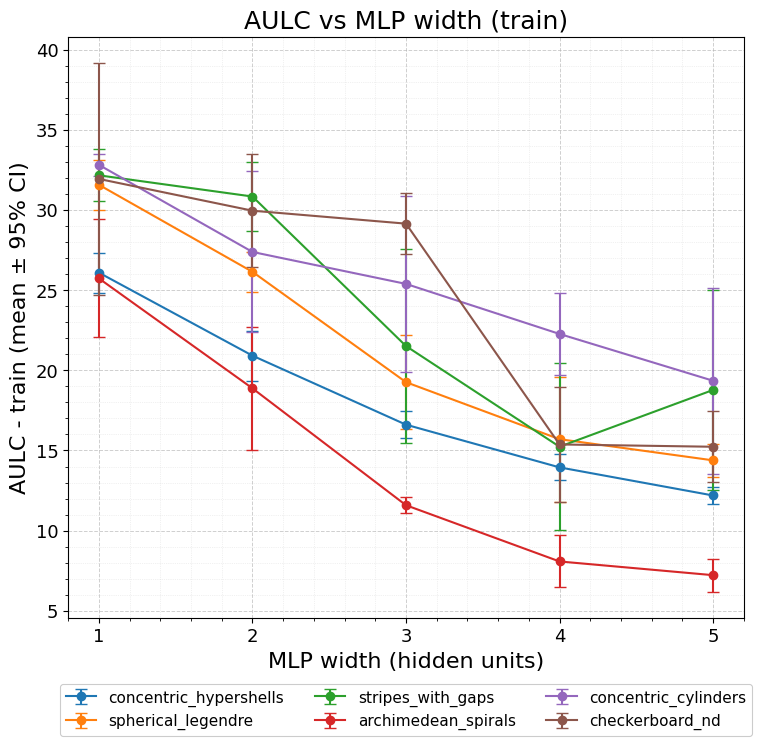

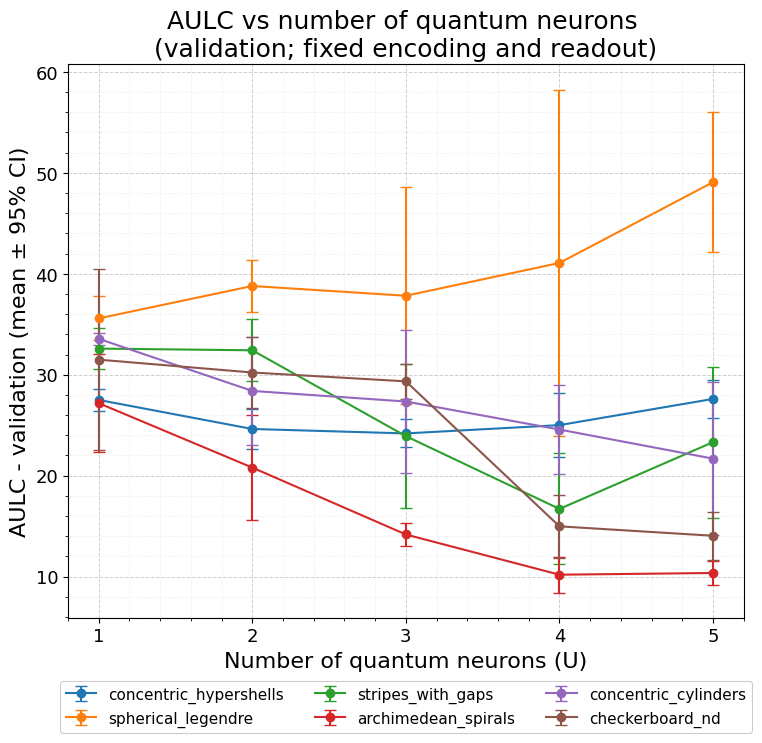

In [26]:
results = {
    "concentric_hypershells": {
        "train_mean": np.array([26.08502951, 20.91052928, 16.60814661, 13.94604458, 12.19410643], dtype=np.float64),
        "train_ci":   np.array([1.2573877 , 1.55968406, 0.84748617, 0.80894956, 0.54776333], dtype=np.float64),
        "val_mean":   np.array([27.50100719, 24.62557489, 24.18525548, 25.00741829, 27.60230176], dtype=np.float64),
        "val_ci":     np.array([1.08239229, 2.01916264, 1.38924457, 3.13437271, 1.85535957], dtype=np.float64),
    },
    "spherical_legendre": {
        "train_mean": np.array([31.56245014, 26.13834068, 19.25793103, 15.70367507, 14.38424366], dtype=np.float64),
        "train_ci":   np.array([1.55511452, 1.23448964, 2.93091323, 3.89233665, 1.02839026], dtype=np.float64),
        "val_mean":   np.array([35.58115116, 38.78952453, 37.82451091, 41.07212844, 49.0745528 ], dtype=np.float64),
        "val_ci":     np.array([ 2.16890156,  2.59039501, 10.76346952, 17.17860128,  6.92569996], dtype=np.float64),
    },
    "stripes_with_gaps": {
        "train_mean": np.array([32.15575779, 30.83305917, 21.51015226, 15.23452813, 18.77173693], dtype=np.float64),
        "train_ci":   np.array([1.61142756, 2.1652561 , 6.07052003, 5.21952518, 6.25652501], dtype=np.float64),
        "val_mean":   np.array([32.58764936, 32.42023145, 23.91596917, 16.70559304, 23.31931964], dtype=np.float64),
        "val_ci":     np.array([2.00806682, 3.07875763, 7.13062664, 5.50424085, 7.47008901], dtype=np.float64),
    },
    "archimedean_spirals": {
        "train_mean": np.array([25.7246454 , 18.87215215, 11.5856969 ,  8.08003097,  7.22534875], dtype=np.float64),
        "train_ci":   np.array([3.678873  , 3.8192351 , 0.49825113, 1.62211132, 1.02257553], dtype=np.float64),
        "val_mean":   np.array([27.1808472 , 20.80087298, 14.17312279, 10.1898323 , 10.3593829 ], dtype=np.float64),
        "val_ci":     np.array([4.83882983, 5.18431364, 1.17983368, 1.77373649, 1.18074965], dtype=np.float64),
    },
    "concentric_cylinders": {
        "train_mean": np.array([32.80491893, 27.37718072, 25.3855367 , 22.26587574, 19.34802679], dtype=np.float64),
        "train_ci":   np.array([ 0.70560722,  5.02042173,  5.49697402,  2.54163827,  5.79790222], dtype=np.float64),
        "val_mean":   np.array([33.55520108, 28.39456282, 27.34730509, 24.56960164, 21.6877868 ], dtype=np.float64),
        "val_ci":     np.array([ 0.60490137,  5.38716317,  7.122908  ,  4.43931496,  7.5790458 ], dtype=np.float64),
    },
    "checkerboard_nd": {
        "train_mean": np.array([31.9303636 , 29.95010733, 29.14272813, 15.37545429, 15.23154491], dtype=np.float64),
        "train_ci":   np.array([7.21472198, 3.51871051, 1.90847105, 3.59978475, 2.22096615], dtype=np.float64),
        "val_mean":   np.array([31.49389307, 30.22019178, 29.34377265, 14.98082193, 14.04683091], dtype=np.float64),
        "val_ci":     np.array([8.95335989, 3.48864739, 1.74628921, 3.08839703, 2.3667404 ], dtype=np.float64),
    },
      
}

# concentric_hypershells, spherical_legendre, stripes_with_gaps, archimedean_spirals, concentric_cylinders, checkerboard_nd, LinSep

# ak chceš "result" premennú
result = results

# ====== q_units na x-osi ======
q_units_list = [1, 2, 3, 4, 5]
labels = [str(u) for u in q_units_list]

# datasety iba kvôli iterácii v grafoch (nemusíš mať reálne funkcie)
datasety = {name: None for name in results.keys()}

# ====== GRAFY ======

# 1) TRAIN
TITLE_FS = 18
LABEL_FS = 16
TICK_FS  = 13
LEGEND_FS = 11

# --- TRAIN ---
fig, ax = plt.subplots(figsize=(8, 8))
for ds_name in results.keys():
    m = results[ds_name]["train_mean"]
    ci = results[ds_name]["train_ci"]
    ax.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)

ax.set_xlabel("MLP width (hidden units)", fontsize=LABEL_FS)
ax.set_ylabel("AULC - train (mean ± 95% CI)", fontsize=LABEL_FS)
ax.set_title("AULC vs MLP width (train)", fontsize=TITLE_FS)
ax.set_xticks(labels)
ax.tick_params(axis="both", labelsize=TICK_FS)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", axis="both", linestyle="--", linewidth=0.7, alpha=0.6)
ax.grid(True, which="minor", axis="both", linestyle=":",  linewidth=0.5, alpha=0.35)
ax.set_axisbelow(True) 

leg = ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),  # bližšie pod os (skús -0.04 až -0.08)
    ncol=3,
    fontsize=LEGEND_FS,
    frameon=True
)
leg.get_frame().set_linewidth(0.8)
leg.get_frame().set_alpha(1.0)

fig.tight_layout(rect=[0, 0.05, 1, 1])  # len malý priestor dole
plt.show()

# --- VAL ---
fig, ax = plt.subplots(figsize=(8,8))
for ds_name in results.keys():
    m = results[ds_name]["val_mean"]
    ci = results[ds_name]["val_ci"]
    ax.errorbar(labels, m, yerr=ci, marker="o", capsize=4, label=ds_name)

ax.set_xlabel("Number of quantum neurons (U)", fontsize=LABEL_FS)
ax.set_ylabel("AULC - validation (mean ± 95% CI)", fontsize=LABEL_FS)
ax.set_title("AULC vs number of quantum neurons \n(validation; fixed encoding and readout)", fontsize=TITLE_FS)
ax.set_xticks(labels)
ax.tick_params(axis="both", labelsize=TICK_FS)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which="major", axis="both", linestyle="--", linewidth=0.7, alpha=0.6)
ax.grid(True, which="minor", axis="both", linestyle=":",  linewidth=0.5, alpha=0.35)
ax.set_axisbelow(True) 

leg = ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=LEGEND_FS,
    frameon=True
)
leg.get_frame().set_linewidth(0.8)
leg.get_frame().set_alpha(1.0)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [ ]:
# pip install pandas scikit-learn openpyxl xlrd>=2.0.1 fastparquet openml seaborn

def MNIST_digits(n_components=10):
    X, y = load_digits(return_X_y=True)
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    # X, _, y, _ = train_test_split(X, y, train_size=5000, random_state=0, stratify=y)
    print(X.shape)
    return X, y

def MNIST_fashion(n_components=10): # trva ale dlhsie kus 
    (x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.fashion_mnist.load_data()
    X = np.concatenate([x_tr, x_te], axis=0).astype("float32") / 255.0
    X = X.reshape(X.shape[0], -1)  # (70000, 784)
    y = np.concatenate([y_tr, y_te], axis=0).astype("int32")  # (70000,)
    
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    print(X.shape)
    X, _, y, _ = train_test_split(X, y, train_size=5000, random_state=0, stratify=y)
    return X,y

def breast_cancer(n_components=None):
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name="target")  # 0 = malignant, 1 = benign
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    print("Shape X:", X.shape)
    return X, y

def letter_recognition(n_components=None): # vela tried fest dopice (od A-Z )
    ds = fetch_openml(name="letter", version=1, as_frame=True)
    X = ds.data.to_numpy()
    y = LabelEncoder().fit_transform(ds.target.to_numpy())
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    print(X.shape)
    return X, y

def load_breast_cancer_wisconsin_original():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
    cols = [
        "id",
        "clump_thickness",
        "uniformity_cell_size",
        "uniformity_cell_shape",
        "marginal_adhesion",
        "single_epithelial_cell_size",
        "bare_nuclei",
        "bland_chromatin",
        "normal_nucleoli",
        "mitoses",
        "class",
    ]
    df = pd.read_csv(url, header=None, names=cols, na_values=["?"]).dropna()
    df["class"] = df["class"].astype(int).map({2: 0, 4: 1})  # benign/malignant
    X = df.drop(columns=["id", "class"]).astype(np.float32).to_numpy()
    y = df["class"].to_numpy(np.int32)
    return X, y

def breast_w(): # Breast Cancer Wisconsin (Original) – 9 featurov
    ds = fetch_openml(name="breast-w", version=1, as_frame=True)
    X = ds.data.astype(np.float32)                     # (699, 9)
    y = (ds.target.astype(str) == "malignant").astype(np.int64)  # {0,1}
    X = SimpleImputer(strategy="median").fit_transform(X)
    return X,y

def aids_prediction(n_components=None):
    aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
    X = aids_clinical_trials_group_study_175.data.features 
    y = aids_clinical_trials_group_study_175.data.targets 
    # print(aids_clinical_trials_group_study_175.metadata) 
    # print(aids_clinical_trials_group_study_175.variables) 
    if n_components is not None:
        pca = PCA(n_components=n_components, svd_solver="full")
        X = pca.fit_transform(X)
    return X, y

def differentiated_thyroid_cancer_recurrence():
    ds = fetch_ucirepo(id=915)

    X = ds.data.features.copy()
    y = ds.data.targets.copy()

    # 1) Features: všetky string/categorical -> čísla (one-hot)
    X = pd.get_dummies(X, dummy_na=False)  # všetko bude int/uint (0/1) + pôvodné numerické stĺpce

    # 2) Targety: "no/yes" -> 0/1, ostatné stringy -> label-encoding
    y = y.replace({"no": 0, "yes": 1, "No": 0, "Yes": 1, "NO": 0, "YES": 1}).copy()
    for col in y.columns:
        if y[col].dtype == "object":
            y[col] = pd.factorize(y[col])[0]  # 0..K-1

    # ak je len jeden target stĺpec, sprav z neho 1D vektor
    if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
        y = y.iloc[:, 0]
    return X,y

def taiwan_credit_scoring():
    taiwan = fetch_openml(name='default-of-credit-card-clients', version=1, as_frame=True, parser='auto')
    X, y = taiwan.data, taiwan.target
    return X,y


# X,y = MNIST_digits(n_components=15)X
# X,y = breast_cancer(n_components=15) #aj (8,8) da 100
# X,y = breast_w()
# X,y = load_breast_cancer_wisconsin_original()
# X,y = letter_recognition() # 16 featur, a 20K vzoriek no, 30 tried
# X,y = aids_prediction(n_components=17)
# X,y = differentiated_thyroid_cancer_recurrence() # da aj (8,8) na 99
# X,y = taiwan_credit_scoring()

(1797, 15)
Shape X: (569, 15)
(20000, 16)


# SAVE / LOAD / TEST kod

In [113]:
# ====== SAVE / LOAD / TEST ======
# potrebujes: pip install joblib

import torch
import torch.nn.functional as F
import joblib
from torch.utils.data import TensorDataset, DataLoader

SAVE_PATH = "/root/torchquantum/baa/BREAST_model.pt"


@torch.no_grad()
def eval_on_loader(model, loader, device: str):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        # deterministicke eval (rovnako ako v tvojom eval_epoch)
        E = model.q.forward_analytic(xb, theta_override=model.q.params_U.detach())
        logits, _ = model(xb, E_override=E)

        loss = F.cross_entropy(logits, yb, reduction="sum")
        pred = logits.argmax(dim=1)

        total_loss += float(loss.item())
        total_correct += int((pred == yb).sum().item())
        total_n += int(yb.numel())

    return total_loss / max(total_n, 1), total_correct / max(total_n, 1)


def save_checkpoint(path: str, model, optimizer, scaler, cfg: dict, epoch: int):
    ckpt = {
        "epoch": int(epoch),
        "cfg": cfg,
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
    }
    torch.save(ckpt, path)
    joblib.dump(scaler, path + ".scaler.joblib")


def load_checkpoint(path: str, device: str):
    ckpt = torch.load(path, map_location=device)
    cfg = ckpt["cfg"]

    model = HybridQMLP(
        input_dim=cfg["input_dim"],
        q_units=cfg["q_units"],
        q_depth=cfg["q_depth"],
        num_classes=cfg["num_classes"],
        mlp_hidden=cfg["mlp_hidden"],
        seed=cfg["seed"],
        shots=cfg["shots"],
        readout_error=cfg["readout_error"],
        simulate_sampling=cfg["simulate_sampling"],
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.get("lr_for_reload", 1e-3))
    # bezpecny load (ak by TorchQuantum robil missing/unexpected keys, spadne do strict=False)
    try:
        model.load_state_dict(ckpt["model_state"], strict=True)
    except RuntimeError:
        model.load_state_dict(ckpt["model_state"], strict=False)

    optimizer.load_state_dict(ckpt["optim_state"])
    scaler = joblib.load(path + ".scaler.joblib")
    start_epoch = int(ckpt["epoch"]) + 1

    return model, optimizer, scaler, start_epoch


def load_checkpoint(path: str, device: str):
    ckpt = torch.load(path, map_location=device)
    cfg = ckpt["cfg"]

    sd = ckpt["model_state"]

    # 1) zahod TorchQuantum qdev buffre
    sd = {k: v for k, v in sd.items() if not k.startswith("q.qdev.")}

    # 2) ak cfg nesedí, nastav q_units (a input_dim) podľa checkpointu
    if "q.in_w" in sd:
        cfg["q_units"] = int(sd["q.in_w"].shape[0])
        cfg["input_dim"] = int(sd["q.in_w"].shape[1])

    model = HybridQMLP(
        input_dim=cfg["input_dim"],
        q_units=cfg["q_units"],
        q_depth=cfg["q_depth"],
        num_classes=cfg["num_classes"],
        mlp_hidden=cfg["mlp_hidden"],
        seed=cfg["seed"],
        shots=cfg["shots"],
        readout_error=cfg["readout_error"],
        simulate_sampling=cfg["simulate_sampling"],
    ).to(device)

    # 3) načítaj iba tie parametre, ktoré existujú a majú rovnaký shape
    msd = model.state_dict()
    sd_ok = {k: v for k, v in sd.items() if k in msd and msd[k].shape == v.shape}
    model.load_state_dict(sd_ok, strict=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.get("lr_for_reload", 1e-3))
    try:
        optimizer.load_state_dict(ckpt["optim_state"])
    except Exception:
        pass  # ak by sa optimizer state nezhodoval, ignoruj

    scaler = joblib.load(path + ".scaler.joblib")
    start_epoch = int(ckpt["epoch"]) + 1
    return model, optimizer, scaler, start_epoch


# Ulozenie

In [110]:
# ====== 1) AKO TO ULOZIT (daj na koniec tvojho treningu) ======
# sem daj presne tie hodnoty, s akymi si model vytvoril


cfg = {
    "input_dim": int(input_dim),
    "q_units": int(1),                 # u teba q_units=1
    "q_depth": int(2),                 # u teba q_depth=2
    "num_classes": int(num_classes),
    "mlp_hidden": (32,),
    "seed": int(0),
    "shots": 3000,                     # u teba shots=3000
    "readout_error": 0.01,
    "simulate_sampling": True,
    "lr_for_reload": 1e-3,             # lubovolne; aj tak sa prepise optim_state
}

SAVE_PATH = "/root/torchquantum/baa/SPIRALS_model.pt"

# uloz po poslednej epoche (epoch mas v loope)
save_checkpoint(SAVE_PATH, model, optimizer, scaler, cfg, epoch=EPOCHS_TOTAL)
print("SAVED:", SAVE_PATH)


SAVED: /root/torchquantum/baa/SPIRALS_model.pt


# Nacitanie

In [114]:
# ====== 2) AKO NACITAT A OTESTOVAT NA TEST DATACH ======
# predpoklad: mas test data ako numpy: X_te_np, y_te_np
# a chces rovnaku normalizaciu ako pri treningu: scaler * sqrt(2)

# SAVE_PATH = "/root/torchquantum/git_priecinok/MNIST_model.pt"
# SAVE_PATH = "/root/torchquantum/baa/BREAST_model.pt"
# SAVE_PATH = "/root/torchquantum/baa/LETTER_model.pt"
SAVE_PATH = "/root/torchquantum/baa/SPIRALS_model.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

model2, optimizer2, scaler2, start_epoch = load_checkpoint(SAVE_PATH, device=device)
print("LOADED, start_epoch =", start_epoch)


X_te_np = scaler2.transform(X_va_np).astype("float32") * (2.0 ** 0.5)
X_te = torch.from_numpy(X_va_np).to(device=device, dtype=torch.float32)
y_te = torch.from_numpy(y_va_np).to(device=device, dtype=torch.long)

test_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=128, shuffle=False)
# test_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=1, shuffle=False)

test_loss, test_acc = eval_on_loader(model2, test_loader, device=device)
# test_loss, test_acc = eval_on_loader(model, test_loader, device=device)
print(f"TEST: loss={test_loss:.4f} acc={test_acc:.4f}")


LOADED, start_epoch = 51
TEST: loss=0.0674 acc=0.9870


/tmp/ipykernel_3771/1647074310.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


# Nacitanie modelu spolu so preprocesovanymi datasetmi 

In [125]:
def load_letter_model(model_path="/root/torchquantum/baa/LETTER_model.pt"):
    X_np,y_np = letter_recognition(n_components=15)
    y_np = np.array(y_np)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # =============  Nacitanie modelu =============
    model, optimizer, scaler, start_epoch = load_checkpoint(model_path, device=device)
    
    # =============  Nacitanie datasetu =============
    X_np, _, y_np, _ = train_test_split(X_np, y_np, train_size=6000, random_state=42,stratify=y_np) 
    X_tr_np, X_te_np, y_tr_np, y_te_np = train_test_split(X_np, y_np, test_size=0.2, random_state=42,stratify=y_np)
    _, X_te_np, _, y_te_np = train_test_split(X_te_np, y_te_np, test_size=50, random_state=42,stratify=y_te_np) # zoberieme 50 nahodnych vzoriek
    # =============  Preprocesing datasetu =============
    X_te_np = scaler.transform(X_te_np).astype("float32") * (2.0 ** 0.5)
    X_te = torch.from_numpy(X_te_np).to(device=device, dtype=torch.float32)
    y_te = torch.from_numpy(y_te_np).to(device=device, dtype=torch.long)
    # =============  Test na simulatore =============
    test_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=128, shuffle=False)
    test_loss, test_acc = eval_on_loader(model, test_loader, device=device)
    print(f"TEST: loss={test_loss:.4f} acc={test_acc:.4f}")
    return  model, X_tr, y_tr, X_te, y_te

def load_BREAST_model(model_path="/root/torchquantum/baa/BREAST_model.pt"):
    X_np, y_np = breast_cancer(n_components=20)
    y_np = np.array(y_np)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # =============  Nacitanie modelu =============
    model, optimizer, scaler, start_epoch = load_checkpoint(model_path, device=device)
    
    # =============  Nacitanie datasetu =============
    X_tr_np, X_te_np, y_tr_np, y_te_np = train_test_split(X_np, y_np, test_size=0.2, random_state=42,stratify=y_np)
    # _, X_te_np, _, y_te_np = train_test_split(X_te_np, y_te_np, test_size=50, random_state=42,stratify=y_te_np) # zoberieme 50 nahodnych vzoriek

    X_te_np, y_te_np = X_te_np[:50], y_te_np[:50]
    # =============  Preprocesing datasetu =============
    X_te_np = scaler.transform(X_te_np).astype("float32") * (2.0 ** 0.5)
    X_te = torch.from_numpy(X_te_np).to(device=device, dtype=torch.float32)
    y_te = torch.from_numpy(y_te_np).to(device=device, dtype=torch.long)
    # =============  Test na simulatore =============
    test_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=128, shuffle=False)
    test_loss, test_acc = eval_on_loader(model, test_loader, device=device)
    print(f"TEST: loss={test_loss:.4f} acc={test_acc:.4f}")
    return  model, X_tr, y_tr, X_te, y_te

def load_MNIST_model(model_path="/root/torchquantum/baa/MNIST_model.pt"):
    X_np,y_np = MNIST_digits(n_components=15)
    y_np = np.array(y_np)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # =============  Nacitanie modelu =============
    model, optimizer, scaler, start_epoch = load_checkpoint(model_path, device=device)
    
    # =============  Nacitanie datasetu =============
    X_tr_np, X_te_np, y_tr_np, y_te_np = train_test_split(X_np, y_np, test_size=0.2, random_state=42,stratify=y_np)
    _, X_te_np, _, y_te_np = train_test_split(X_te_np, y_te_np, test_size=50, random_state=0,stratify=y_te_np) # zoberieme 50 nahodnych vzoriek
    # =============  Preprocesing datasetu =============
    X_te_np = scaler.transform(X_te_np).astype("float32") * (2.0 ** 0.5)
    X_te = torch.from_numpy(X_te_np).to(device=device, dtype=torch.float32)
    y_te = torch.from_numpy(y_te_np).to(device=device, dtype=torch.long)
    # =============  Test na simulatore =============
    test_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=128, shuffle=False)
    test_loss, test_acc = eval_on_loader(model, test_loader, device=device)
    print(f"TEST: loss={test_loss:.4f} acc={test_acc:.4f}")
    return  model, X_tr, y_tr, X_te, y_te

def load_CANCER_model(model_path="/root/torchquantum/baa/CANCER_model.pt"):
    X_np,y_np = differentiated_thyroid_cancer_recurrence(n_components=5)
    y_np = np.array(y_np)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # =============  Nacitanie modelu =============
    model, optimizer, scaler, start_epoch = load_checkpoint(model_path, device=device)
    
    # =============  Nacitanie datasetu =============
    X_tr_np, X_te_np, y_tr_np, y_te_np = train_test_split(X_np, y_np, test_size=0.2, random_state=42,stratify=y_np)
    _, X_te_np, _, y_te_np = train_test_split(X_te_np, y_te_np, test_size=50, random_state=0,stratify=y_te_np) # zoberieme 50 nahodnych vzoriek
    # =============  Preprocesing datasetu =============
    X_te_np = scaler.transform(X_te_np).astype("float32") * (2.0 ** 0.5)
    X_te = torch.from_numpy(X_te_np).to(device=device, dtype=torch.float32)
    y_te = torch.from_numpy(y_te_np).to(device=device, dtype=torch.long)
    # =============  Test na simulatore =============
    test_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=128, shuffle=False)
    test_loss, test_acc = eval_on_loader(model, test_loader, device=device)
    print(f"TEST: loss={test_loss:.4f} acc={test_acc:.4f}")
    return  model, X_tr, y_tr, X_te, y_te

def load_SPIRALS_model(model_path="/root/torchquantum/baa/SPIRALS_model.pt"):
    X_np,y_np = make_spirals_nd_full2()
    y_np = np.array(y_np)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # =============  Nacitanie modelu =============
    model, optimizer, scaler, start_epoch = load_checkpoint(model_path, device=device)
    
    # =============  Nacitanie datasetu =============
    X_tr_np, X_te_np, y_tr_np, y_te_np = train_test_split(X_np, y_np, test_size=0.2, random_state=42,stratify=y_np)
    _, X_te_np, _, y_te_np = train_test_split(X_te_np, y_te_np, test_size=50, random_state=0,stratify=y_te_np) # zoberieme 50 nahodnych vzoriek
    # =============  Preprocesing datasetu =============
    X_te_np = scaler.transform(X_te_np).astype("float32") * (2.0 ** 0.5)
    X_te = torch.from_numpy(X_te_np).to(device=device, dtype=torch.float32)
    y_te = torch.from_numpy(y_te_np).to(device=device, dtype=torch.long)
    # =============  Test na simulatore =============
    test_loader = DataLoader(TensorDataset(X_te, y_te), batch_size=128, shuffle=False)
    test_loss, test_acc = eval_on_loader(model, test_loader, device=device)
    print(f"TEST: loss={test_loss:.4f} acc={test_acc:.4f}")
    return  model, X_tr, y_tr, X_te, y_te




# model, X_tr, y_tr, X_te, y_te = load_letter_model()
# model, X_tr, y_tr, X_te, y_te = load_BREAST_model()
# model, X_tr, y_tr, X_te, y_te = load_MNIST_model()
# model, X_tr, y_tr, X_te, y_te = load_CANCER_model()
model, X_tr, y_tr, X_te, y_te = load_SPIRALS_model()

TEST: loss=0.0315 acc=1.0000


/tmp/ipykernel_3771/1647074310.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


# Qiskit

In [89]:
X_np, y_np = breast_cancer(n_components=20)
device = "cuda" if torch.cuda.is_available() else "cpu"
y_np = np.array(y_np)

# X_np, _, y_np, _ = train_test_split(
#     X_np, y_np, train_size=6000, 
#     random_state=42,
#     stratify=y_np
# )

X_tr_np, X_va_np, y_tr_np, y_va_np = train_test_split(
    X_np, y_np, test_size=0.2, 
    random_state=42,
    stratify=y_np
)

_, X_va_np, _, y_va_np = train_test_split(
    X_va_np, y_va_np, test_size=50, 
    random_state=42,
    stratify=y_va_np
)

print(X_tr_np.shape)

scaler = StandardScaler()
X_tr_np = scaler.fit_transform(X_tr_np).astype(np.float32) * np.sqrt(2)
X_va_np = scaler.transform(X_va_np).astype(np.float32)* np.sqrt(2)


X_tr = torch.from_numpy(X_tr_np).to(device=device, dtype=torch.float32)
y_tr = torch.from_numpy(y_tr_np).to(device=device, dtype=torch.long)
X_va = torch.from_numpy(X_va_np).to(device=device, dtype=torch.float32)
y_va = torch.from_numpy(y_va_np).to(device=device, dtype=torch.long)

Shape X: (569, 20)
(455, 20)


# Spustacie a citacie funkcie z realneho QPU 

In [128]:
from qiskit.transpiler.passmanager import PassManager
from qiskit_ibm_runtime.transpiler.passes import FoldRzzAngle

# Pozn.: vyžaduje qiskit>=2.x a qiskit-ibm-runtime (V2 primitives).
import os
os.environ["QISKIT_PARALLEL"] = "FALSE"
os.environ["QISKIT_NUM_PROCS"] = "1"

import math
import itertools
from typing import Callable, Optional, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn.functional as F

from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit import QuantumCircuit

def insert_barrier_after_layer(qc: QuantumCircuit, k: int) -> QuantumCircuit:
    """
    Vloží bariéru po k-tej vrstve (k=0 nič, k=1 po prvej vrstve, ...),
    vrstvy podľa DAG layering (ako “logická hĺbka”).
    """
    dag = circuit_to_dag(qc)
    layers = list(dag.layers())

    new = QuantumCircuit(*qc.qregs, *qc.cregs)

    for i, layer in enumerate(layers):
        sub = dag_to_circuit(layer["graph"])
        new.compose(sub, inplace=True)
        if i + 1 == k:
            new.barrier(*new.qubits)

    return new


# ----------------------------- utils -----------------------------

def _as_numpy_2d(X) -> np.ndarray:
    if isinstance(X, torch.Tensor):
        X = X.detach().cpu().numpy()
    X = np.asarray(X)
    if X.ndim == 1:
        X = X[None, :]
    return X.astype(np.float64, copy=False)

def _device_of_model(model) -> torch.device:
    return next(model.parameters()).device

def _pair_indices(n_qubits: int) -> Tuple[np.ndarray, np.ndarray]:
    pairs = list(itertools.combinations(range(n_qubits), 2))
    if not pairs:
        return np.empty((0,), dtype=np.int64), np.empty((0,), dtype=np.int64)
    return (
        np.asarray([i for i, _ in pairs], dtype=np.int64),
        np.asarray([j for _, j in pairs], dtype=np.int64),
    )

def _expvals_z_zz_from_counts_dict(counts, n_qubits, pair_i, pair_j) -> np.ndarray:
    keys = [k.replace(" ", "").zfill(n_qubits) for k in counts.keys()]
    w = np.asarray(list(counts.values()), dtype=np.float64)
    shots = float(w.sum())

    # MSB mapping: qubit0 = keys[j][0]
    bits = np.empty((len(keys), n_qubits), dtype=np.int8)
    for r, k in enumerate(keys):
        bits[r] = np.fromiter((1 if c == "1" else 0 for c in k), dtype=np.int8, count=n_qubits)

    mean_bits = (w[:, None] * bits).sum(axis=0) / shots
    expZ = 1.0 - 2.0 * mean_bits

    if pair_i.size == 0:
        return expZ

    xor = (bits[:, pair_i] ^ bits[:, pair_j]).astype(np.int8)
    mean_xor = (w[:, None] * xor).sum(axis=0) / shots
    expZZ = 1.0 - 2.0 * mean_xor
    return np.concatenate([expZ, expZZ], axis=0)


# ---------------------- circuit: presne tvoj ansatz ----------------------

def _build_reuploading_circuit_for_unit(
    x_angles: np.ndarray,         # (N,) už po affine: z = x*w + b
    theta_u: np.ndarray,          # (P,)
    model,
) -> QuantumCircuit:
    """
    Presná sekvencia brán podľa tvojho TorchQuantum ansatzu:
      pre každú vrstvu d a qubit q:
        Rx(c) -> Rz(x) -> Rx(b) -> Rz(a - pi/2)
      potom Rzz podľa parity vrstvy
      na konci tail:
        Rz(th_rz) -> Rx(th_rx)
    """
    qlayer = model.q
    ans = qlayer.ansatz
    N = int(qlayer.n_qubits)
    depth = int(qlayer.depth)

    enc_a = ans.enc_a_idx.detach().cpu().numpy()  # (depth,N)
    enc_b = ans.enc_b_idx.detach().cpu().numpy()
    enc_c = ans.enc_c_idx.detach().cpu().numpy()

    qc = QuantumCircuit(N)
    half_pi = 0.5 * math.pi

    for d in range(depth):
        for q in range(N):
            a = float(theta_u[int(enc_a[d, q])])
            b = float(theta_u[int(enc_b[d, q])])
            c = float(theta_u[int(enc_c[d, q])])
            xq = float(x_angles[q])

            qc.rx(c, q)
            qc.rz(xq, q)                 # data reupload
            qc.rx(b, q)
            qc.rz(a - half_pi, q)

        # RZZ layer (presne podľa ans.rzz_layers)
                
        for (q1, q2, pidx) in ans.rzz_layers[d]:
            qc.rzz(float(theta_u[int(pidx)]), int(q1), int(q2))
        

    # tail: Rz -> Rx (lebo u_tail = Rx @ Rz)
    for (q, pidx_rz, pidx_rx) in ans.tail:
        qc.rz(float(theta_u[int(pidx_rz)]), int(q))
        qc.rx(float(theta_u[int(pidx_rx)]), int(q))

    qc.measure_all()
    return qc


def _build_circuits_for_X(
    model,
    X: np.ndarray,                          # (B,N) už po preprocess_fn
) -> Tuple[list, int, int, int]:
    """
    Vráti zoznam obvodov v poradí:
      idx = b*U + u
    aby sa to dalo neskôr reshape-núť na (B,U,T).
    """
    qlayer = model.q
    N = int(qlayer.n_qubits)
    U = int(qlayer.units)

    in_w = qlayer.in_w.detach().cpu().numpy().astype(np.float64)      # (U,N)
    in_b = qlayer.in_b.detach().cpu().numpy().astype(np.float64)      # (U,N)
    theta = qlayer.params_U.detach().cpu().numpy().astype(np.float64) # (U,P)

    B = int(X.shape[0])
    circuits = []
    for b in range(B):
        x = X[b]  # (N,)
        for u in range(U):
            z = x * in_w[u] + in_b[u]  # (N,) – rovnaké ako v forward_analytic
            qc = _build_reuploading_circuit_for_unit(z, theta[u], model)
            circuits.append(qc)

    return circuits, B, U, N


# ----------------------------- API 1: submit job -----------------------------

def submit_ibm_job_id(
    model,
    X_val,
    *,
    backend_name: str = "ibm_fez",
    shots: Optional[int] = None,
    service: Optional[QiskitRuntimeService] = None,
    preprocess_fn: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    use_fractional_gates: bool = True,
    job_tags: Optional[list[str]] = None
) -> str:
    """
    - predspracuje X (cez preprocess_fn ak je dané)
    - vytvorí obvody (1 obvod na 1 vzorku a 1 unit)
    - transpile na optimization_level=3
    - spustí ako SamplerV2 v jednom jobe
    - vráti job_id
    """
    X = _as_numpy_2d(X_val)
    if preprocess_fn is not None:
        X = preprocess_fn(X)

    if service is None:
        service = QiskitRuntimeService(
        token="NvAzDwpBT_XoDFwJU1OuMNDcgFn_5FCpfIcJzuOs78lg",
        instance="crn:v1:bluemix:public:quantum-computing:us-east:a/fcaefdb046ea47e78c094ace331c4230:d96e1fb8-4e69-4872-88bd-7ea3269fcd59::",   # odporúčané
        channel="ibm_quantum_platform",
    )
    

    backend = service.backend(backend_name, use_fractional_gates=True)

    circuits, B, U, N = _build_circuits_for_X(model, X)

    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, translation_method="translator")
    
    # isa_circuits = pm.run(circuits, num_processes=1) 
    post_pm = PassManager([
        FoldRzzAngle(),
        # Optimize1qGatesDecomposition(target=backend.target),  # voliteľné, ale často pomôže
    ])
    # isa_circuits = post_pm.run(isa_circuits)
    isa_circuits = post_pm.run(circuits)
    isa_circuits = pm.run(isa_circuits, num_processes=1) 
    # return isa_circuits
    
    ks = (3, 5, 9, 11)     # vlož bariéry po vrstvách 3,5,9,11 (v pôvodnom isa_circuit)
    new_isa_circuits = []
    for c in isa_circuits:
        qc = c
        added = 0
        for k in ks:
            qc = insert_barrier_after_layer(qc, k=k)
        new_isa_circuits.append(qc)
    isa_circuits = new_isa_circuits


    sampler = Sampler(mode=backend)
    if job_tags:
        sampler.options.environment.job_tags = job_tags
    job = sampler.run(isa_circuits, shots=(int(shots) if shots is not None else None))
    return job.job_id()


# ---------------------- API 2: job_id -> expvals -> predikcia + porovnanie ----------------------
def _expvals_z_zz_from_counts_dict_M3(counts, n_qubits, pair_i, pair_j, m3_cal=None, m3_use_job_layout: bool = True) -> np.ndarray:
    keys = [k.replace(" ", "").zfill(n_qubits) for k in counts.keys()]
    w = np.asarray(list(counts.values()), dtype=np.float64)
    shots = float(w.sum())

    bits = np.empty((len(keys), n_qubits), dtype=np.int8)
    for r, k in enumerate(keys):
        bits[r] = np.fromiter((1 if c == "1" else 0 for c in k), dtype=np.int8, count=n_qubits)

    # bez mitigácie
    if m3_cal is None:
        mean_bits = (w[:, None] * bits).sum(axis=0) / shots
        expZ = 1.0 - 2.0 * mean_bits
        if pair_i.size == 0:
            return expZ
        xor = (bits[:, pair_i] ^ bits[:, pair_j]).astype(np.int8)
        mean_xor = (w[:, None] * xor).sum(axis=0) / shots
        expZZ = 1.0 - 2.0 * mean_xor
        return np.concatenate([expZ, expZZ], axis=0)

    cal = np.asarray(m3_cal, dtype=np.float64)
    if cal.shape[0] < n_qubits or cal.shape[1] < 2:
        raise ValueError(f"m3_cal musí mať aspoň tvar (n_qubits,2). Má: {cal.shape}")

    p01 = np.clip(cal[:n_qubits, 0], 0.0, 0.499)  # P(0|1)
    p10 = np.clip(cal[:n_qubits, 1], 0.0, 0.499)  # P(1|0)
    den = 1.0 - p01 - p10

    invC = [None] * n_qubits
    for i in range(n_qubits):
        if den[i] > 1e-8:
            invC[i] = (1.0 / den[i]) * np.array([[1.0 - p01[i], -p01[i]],
                                                 [-p10[i],      1.0 - p10[i]]], dtype=np.float64)

    # <Z>
    mean_bits = (w[:, None] * bits).sum(axis=0) / shots
    expZ = np.empty((n_qubits,), dtype=np.float64)
    for i in range(n_qubits):
        if invC[i] is None:
            expZ[i] = 1.0 - 2.0 * mean_bits[i]
            continue
        meas_vec = np.array([1.0 - mean_bits[i], mean_bits[i]], dtype=np.float64)  # [P0,P1]
        true_vec = invC[i] @ meas_vec
        true_vec = np.clip(true_vec, 0.0, 1.0)
        s = true_vec.sum()
        if s > 0:
            true_vec /= s
        expZ[i] = true_vec[0] - true_vec[1]

    if pair_i.size == 0:
        return expZ

    # <ZZ> (pairwise)
    bi = bits[:, pair_i].astype(np.float64)
    bj = bits[:, pair_j].astype(np.float64)
    ww = w[:, None]

    p11 = (ww * (bi * bj)).sum(axis=0) / shots
    p10m = (ww * (bi * (1.0 - bj))).sum(axis=0) / shots
    p01m = (ww * ((1.0 - bi) * bj)).sum(axis=0) / shots
    p00 = 1.0 - p11 - p10m - p01m

    expZZ = np.empty((pair_i.size,), dtype=np.float64)
    for k in range(pair_i.size):
        i = int(pair_i[k]); j = int(pair_j[k])

        if invC[i] is None or invC[j] is None:
            expZZ[k] = p00[k] + p11[k] - p01m[k] - p10m[k]
            continue

        meas4 = np.array([p00[k], p01m[k], p10m[k], p11[k]], dtype=np.float64)  # [00,01,10,11]
        inv_pair = np.kron(invC[i], invC[j])
        true4 = inv_pair @ meas4
        true4 = np.clip(true4, 0.0, 1.0)
        s = true4.sum()
        if s > 0:
            true4 /= s
        expZZ[k] = true4[0] + true4[3] - true4[1] - true4[2]
    return np.concatenate([expZ, expZZ], axis=0)


@torch.no_grad()
def predict_from_ibm_job(
    model,
    X_val,
    job_id: str,
    *,
    y_val=None,
    service: Optional[QiskitRuntimeService] = None,
    preprocess_fn: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    readout_flip_p_for_comparison: float = 0.0,
    m3_cal = None,
    m3_use_job_layout: bool = True,
) -> Dict[str, Any]:
    """
    - zoberie job_id, vytiahne counts
    - spočíta expvaly presne podľa tvojich definícií <Zi> a <ZiZj>
    - preženie to MLP časťou modelu -> predikcia triedy
    - porovná so simulatorom (TorchQuantum forward v modeli):
        * pred_hw vs pred_sim
        * loss_hw vs loss_sim (ak dáš y_val)
        * E_hw vs E_sim (po prvkoch + agregované metriky)
    """
    X = _as_numpy_2d(X_val)
    if preprocess_fn is not None:
        X = preprocess_fn(X)

    if service is None:
         service = QiskitRuntimeService(
        token="NvAzDwpBT_XoDFwJU1OuMNDcgFn_5FCpfIcJzuOs78lg",
        instance="crn:v1:bluemix:public:quantum-computing:us-east:a/fcaefdb046ea47e78c094ace331c4230:d96e1fb8-4e69-4872-88bd-7ea3269fcd59::",   # odporúčané
        channel="ibm_quantum_platform",
    )

    runtime_job = service.job(job_id)
    qlayer = model.q
    N = int(qlayer.n_qubits)
    U = int(qlayer.units)

    # --- M3: premapovanie kalibrácie podľa layoutu (virtual -> physical) zo job.inputs ---
    m3_cal_used = None
    if m3_cal is not None:
        m3_cal_used = np.asarray(m3_cal, dtype=np.float64)

        if m3_use_job_layout:
            phys_map = None
            try:
                inputs = runtime_job.inputs() if callable(runtime_job.inputs) else runtime_job.inputs
                pubs = inputs.get("pubs") if isinstance(inputs, dict) else None
                if pubs is None and isinstance(inputs, dict):
                    pubs = inputs.get("circuits")

                circ0 = None
                if pubs:
                    p0 = pubs[0]
                    if isinstance(p0, (list, tuple)) and len(p0) > 0:
                        circ0 = p0[0]
                    elif isinstance(p0, dict):
                        circ0 = p0.get("circuit") or p0.get("qc")
                    else:
                        circ0 = getattr(p0, "circuit", None)

                if circ0 is not None:
                    layout = getattr(circ0, "layout", None)
                    if layout is not None and hasattr(layout, "final_index_layout"):
                        try:
                            phys_map = list(layout.final_index_layout(filter_ancillas=True))
                        except TypeError:
                            phys_map = list(layout.final_index_layout())

                # phys_map[i] = fyzický qubit pre virtuálny i
                if phys_map is not None and len(phys_map) >= N:
                    m3_cal_used = m3_cal_used[np.asarray(phys_map[:N], dtype=int), :]
            except Exception:
                print("No M3 used")
                pass

    result = runtime_job.result()  # PrimitiveResult, 1 PubResult per circuit

    qlayer = model.q
    N = int(qlayer.n_qubits)
    U = int(qlayer.units)
    pair_i, pair_j = _pair_indices(N)
    T = N + (N * (N - 1)) // 2

    B = int(X.shape[0])
    expected_num_pubs = B * U
    if len(result) != expected_num_pubs:
        raise RuntimeError(f"Počet PUB výsledkov ({len(result)}) != B*U ({expected_num_pubs}).")

    # Hardware expvals: (B,U,T)
    E_hw = np.empty((B, U, T), dtype=np.float64)

    for b in range(B):
        for u in range(U):
            idx = b * U + u
            pub = result[idx]
            # štandardne je register "meas" pri measure_all()
            counts = pub.data.meas.get_counts()
            # e = _expvals_z_zz_from_counts_dict(counts, N, pair_i, pair_j)
            # e = _expvals_z_zz_from_counts_dict(counts, N, pair_i, pair_j, m3_cal=M3_CAL)
            if m3_cal is None:
                e = _expvals_z_zz_from_counts_dict(counts, N, pair_i, pair_j)
            else:
                e = _expvals_z_zz_from_counts_dict_M3(counts, N, pair_i, pair_j, m3_cal=m3_cal_used)



            # voliteľne: ak chceš "rovnaký readout flip model" ako v simulátore,
            # tak (v priemere) škáluje: Z -> (1-2p)Z a ZZ -> (1-2p)^2 ZZ
            p = float(readout_flip_p_for_comparison or 0.0)
            if p > 0.0:
                a = 1.0 - 2.0 * p
                e = e.copy()
                e[:N] *= a
                if T > N:
                    e[N:] *= (a * a)

            E_hw[b, u, :] = e

    # Predikcia na HW
    dev = _device_of_model(model)
    X_t = torch.tensor(X, dtype=torch.float32, device=dev)
    E_hw_t = torch.tensor(E_hw, dtype=torch.float32, device=dev)
    logits_hw, _ = model(X_t, E_override=E_hw_t)
    pred_hw = logits_hw.argmax(dim=1).detach().cpu().numpy()

    out: Dict[str, Any] = {
        "job_id": job_id,
        "E_hw": E_hw,            # (B,U,T)
        "pred_hw": pred_hw,      # (B,)
    }

    # loss_hw (ak y_val)
    if y_val is not None:
        y = y_val.detach().cpu().numpy() if isinstance(y_val, torch.Tensor) else np.asarray(y_val)
        y = y.reshape(-1)
        y_t = torch.tensor(y, dtype=torch.long, device=dev)
        out["loss_hw"] = float(F.cross_entropy(logits_hw, y_t).item())

    # Simulator porovnanie (presne tvoja TorchQuantum cesta v modeli)
    model.eval()
    E_sim_t = model.q.forward_analytic(X_t, theta_override=model.q.params_U.detach())
    logits_sim, _ = model(X_t, E_override=E_sim_t)
    pred_sim = logits_sim.argmax(dim=1).detach().cpu().numpy()
    E_sim = E_sim_t.detach().cpu().numpy()

    out.update({
        "E_sim": E_sim,
        "pred_sim": pred_sim,
        "E_abs_mae": float(np.mean(np.abs(E_hw - E_sim))),
        "E_abs_max": float(np.max(np.abs(E_hw - E_sim))),
    })

    if y_val is not None:
        out["loss_sim"] = float(F.cross_entropy(logits_sim, y_t).item())
        out["pred_match_rate"] = float(np.mean((pred_hw == pred_sim).astype(np.float64)))


    return out


# Spustenie na realnom hardwery

In [ ]:

# ----------------------------- usage -----------------------------
if __name__ == "__main__":
    # xkuruc
    # service = QiskitRuntimeService(token="NvAzDwpBT_XoDFwJU1OuMNDcgFn_5FCpfIcJzuOs78lg", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/fcaefdb046ea47e78c094ace331c4230:d96e1fb8-4e69-4872-88bd-7ea3269fcd59::", channel="ibm_quantum_platform", )
    # mamka
    # service = QiskitRuntimeService(token="NQmyfnQ65Ph57QlFTqZtR3GVL5o7hfFsRcTj_kdO_o6P", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/ece7545919a143938c32addce65996b9:eab6f41e-eb11-4463-8ac7-98722a4d5e3c::", channel="ibm_quantum_platform", )

    #padre
    service = QiskitRuntimeService(token="FKW0Ub8kcUosCQJ-5L5oZfMqPMNOHYQSIArR4lk3aLbA", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/99d32eb53fe3497ab59c5f5913009b9a:9a6ab587-cfde-482c-9977-9bf83288ac28::", channel="ibm_quantum_platform", )
    
    # job_id = submit_ibm_job_id(model2, X_va_np[:50], shots=3000, backend_name="ibm_fez", job_tags=["fez", "qmlp", "ds-breast", "batch-50", "b01", "r03" ])
    # res = predict_from_ibm_job(model2, X_va_np[:50], job_id, y_val=y_va_np[:50])
    # print(res["job_id"], res["loss_hw"], res["loss_sim"], res["pred_hw"][:50], res["pred_sim"][:50])

    job_id = submit_ibm_job_id(model, X_te, shots=3000, backend_name="ibm_fez", job_tags=["fez", "qmlp", "ds-spirals", "batch-50", "b01", "r02" ], service=service)
    res = predict_from_ibm_job(model, X_te, job_id, y_val=y_te, service=service)
    print(res["job_id"], res["loss_hw"], res["loss_sim"], res["pred_hw"], res["pred_sim"])
    pass

# "fez" = spustene na IBM_fez QPU  (https://quantum.cloud.ibm.com/computers?tab=systems&system=ibm_fez)
# "qmlp" = kvantovy obvod pre model QMLP
# "ds-breast" = Kvantovy obvod je spusteny so vzorkami pre dataset BREAST
# "batch-50" = obsahuje 50 vzoriek = 50 kvantovych obvodov 
# "b01" = prvy batch po 50 vzoriek zo X_test
# "r01" = je to prvy repeat
# job_tags=["fez", "qmlp", "ds-breast", "batch-50", "b01", "r01" ]



qiskit_runtime_service._discover_account:WARNING:2026-02-27 20:12:27,752: Loading account with the given token. A saved account will not be used.


KeyboardInterrupt: 

In [133]:
service = QiskitRuntimeService(token="FKW0Ub8kcUosCQJ-5L5oZfMqPMNOHYQSIArR4lk3aLbA", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/99d32eb53fe3497ab59c5f5913009b9a:9a6ab587-cfde-482c-9977-9bf83288ac28::", channel="ibm_quantum_platform", )

job_id = submit_ibm_job_id(model, X_te, shots=3000, backend_name="ibm_fez", job_tags=["fez", "qmlp", "ds-spirals", "batch-50", "b01", "r03" ], service=service)
job_id = submit_ibm_job_id(model, X_te, shots=3000, backend_name="ibm_fez", job_tags=["fez", "qmlp", "ds-spirals", "batch-50", "b01", "r04" ], service=service)
job_id = submit_ibm_job_id(model, X_te, shots=3000, backend_name="ibm_fez", job_tags=["fez", "qmlp", "ds-spirals", "batch-50", "b01", "r05" ], service=service)


qiskit_runtime_service._discover_account:WARNING:2026-02-27 20:21:18,755: Loading account with the given token. A saved account will not be used.


In [132]:
import numpy as np

def print_job_report_from_id(
    job_id: str,
    model,
    service,
    x_val,
    y_val=None,
    *,
    preprocess_fn=None,
    readout_flip_p_for_comparison: float = 0.0,
    first_k: int = 50,
    wrong_k: int = 50,
) -> dict:
    """
    Spraví predict_from_ibm_job(...) z job_id a vytlačí report.
    Vstupy: job_id, model, service, x_val, y_val.
    """
    res = predict_from_ibm_job(
        model,
        x_val,
        job_id,
        y_val=y_val,
        service=service,
        preprocess_fn=preprocess_fn,
        readout_flip_p_for_comparison=readout_flip_p_for_comparison,
    )

    pred_hw = np.asarray(res["pred_hw"])
    pred_sim = np.asarray(res["pred_sim"])
    match_hw_sim = float(np.mean(pred_hw == pred_sim))

    y = None
    acc_hw = acc_sim = float("nan")
    diff_idx = diff_idx_sim = np.array([], dtype=np.int64)

    if y_val is not None:
        if hasattr(y_val, "detach"):  # torch tensor
            y_val_np = y_val.detach().cpu().numpy()
        else:
            y_val_np = np.asarray(y_val)
        y = y_val_np.reshape(-1)[: len(pred_hw)]

        acc_hw = float(np.mean(pred_hw == y))
        acc_sim = float(np.mean(pred_sim == y))
        diff_idx = np.flatnonzero(pred_hw != y)
        diff_idx_sim = np.flatnonzero(pred_sim != y)

    print(
        f"""
JOB: {res.get('job_id', job_id)}

LOSS:
  hw : {res.get('loss_hw', float('nan')):.6f}
  sim: {res.get('loss_sim', float('nan')):.6f}

ACCURACY:
  hw : {acc_hw*100:.2f}%  ({(len(y)-len(diff_idx)) if y is not None else 'NA'}/{len(y) if y is not None else 'NA'})
  sim: {acc_sim*100:.2f}%  ({(len(y)-len(diff_idx_sim)) if y is not None else 'NA'}/{len(y) if y is not None else 'NA'})

PRED MATCH (hw vs sim): {match_hw_sim*100:.2f}%

E DIFF:
  mae : {res.get('E_abs_mae', float('nan')):.6g}
  max : {res.get('E_abs_max', float('nan')):.6g}

FIRST {first_k}:
  y   : {y[:first_k] if y is not None else 'NA'}
  hw  : {pred_hw[:first_k]}
  sim : {pred_sim[:first_k]}

WRONG (hw vs y)  idx: {diff_idx[:wrong_k] if y is not None else 'NA'}
WRONG (sim vs y) idx: {diff_idx_sim[:wrong_k] if y is not None else 'NA'}
"""
    )

    return {
        "res": res,
        "acc_hw": acc_hw,
        "acc_sim": acc_sim,
        "match_hw_sim": match_hw_sim,
        "diff_idx": diff_idx,
        "diff_idx_sim": diff_idx_sim,
        "y": y,
    }



service = QiskitRuntimeService(
        token="NvAzDwpBT_XoDFwJU1OuMNDcgFn_5FCpfIcJzuOs78lg",
        instance="crn:v1:bluemix:public:quantum-computing:us-east:a/fcaefdb046ea47e78c094ace331c4230:d96e1fb8-4e69-4872-88bd-7ea3269fcd59::",
        channel="ibm_quantum_platform",
    )

# mamka
service = QiskitRuntimeService(token="NQmyfnQ65Ph57QlFTqZtR3GVL5o7hfFsRcTj_kdO_o6P", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/ece7545919a143938c32addce65996b9:eab6f41e-eb11-4463-8ac7-98722a4d5e3c::", channel="ibm_quantum_platform", )

# job_id = "d6gl3vpkeb2s73bdj7o0"
# m = print_job_report_from_id(job_id, model2, service, X_va_np[:50], y_val=y_va_np[:50])
m = print_job_report_from_id(job_id, model, service, X_te, y_val=y_te)





qiskit_runtime_service._discover_account:WARNING:2026-02-27 20:16:05,413: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service._discover_account:WARNING:2026-02-27 20:16:07,394: Loading account with the given token. A saved account will not be used.



JOB: d6gvlhf3o3rs73cac96g

LOSS:
  hw : 0.048161
  sim: 0.035893

ACCURACY:
  hw : 98.00%  (49/50)
  sim: 98.00%  (49/50)

PRED MATCH (hw vs sim): 100.00%

E DIFF:
  mae : 0.0293138
  max : 0.169734

FIRST 50:
  y   : [0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1
 0 0 0 1 1 0 1 0 1 0 1 1 0]
  hw  : [0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 0 0 1 1 0 1 0 1 0 1 1 0]
  sim : [0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 0 0 1 1 0 1 0 1 0 1 1 0]

WRONG (hw vs y)  idx: [27]
WRONG (sim vs y) idx: [27]



# Vyhodnotenie jobu

In [136]:
import math
import numpy as np
import torch
from qiskit_ibm_runtime import QiskitRuntimeService

# --- 95% CI pre priemer (t-interval; malé n) ---
_TCRIT_95 = {
    2: 12.706, 3: 4.303, 4: 3.182, 5: 2.776, 6: 2.571,
    7: 2.447, 8: 2.365, 9: 2.306, 10: 2.262,
}

service = QiskitRuntimeService(
        token="NvAzDwpBT_XoDFwJU1OuMNDcgFn_5FCpfIcJzuOs78lg",
        instance="crn:v1:bluemix:public:quantum-computing:us-east:a/fcaefdb046ea47e78c094ace331c4230:d96e1fb8-4e69-4872-88bd-7ea3269fcd59::",
        channel="ibm_quantum_platform",
    )

# # mamka
# service = QiskitRuntimeService(token="NQmyfnQ65Ph57QlFTqZtR3GVL5o7hfFsRcTj_kdO_o6P", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/ece7545919a143938c32addce65996b9:eab6f41e-eb11-4463-8ac7-98722a4d5e3c::", channel="ibm_quantum_platform", )


def mean_ci95(x: np.ndarray):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = int(x.size)
    mu = float(np.mean(x)) if n else float("nan")
    if n < 2:
        return mu, (float("nan"), float("nan")), n
    s = float(np.std(x, ddof=1))
    tcrit = _TCRIT_95.get(n, 1.96)  # fallback ~ normal
    half = tcrit * s / math.sqrt(n)
    return mu, (mu - half, mu + half), n

def _as_np_1d(y):
    if y is None:
        return None
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()
    y = np.asarray(y).reshape(-1)
    return y

def _is_done(job):
    try:
        return str(job.status()).upper().endswith("DONE")
    except Exception:
        return False

def eval_batch(model,X_50,y_50,*,
    service: QiskitRuntimeService,preprocess_fn=None,
    base_tags=("ds-breast", "batch-50", "b01"),repeats=("r01", "r02", "r03", "r04", "r05"),per_repeat_limit=20,readout_flip_p_for_comparison=0.0, m3_cal=None):
    """
    Nájde joby podľa tagov (pre každý repeat vyberie najnovší DONE job),
    vyhodnotí HW aj SIM accuracy + loss, a spraví 95% CI cez 5 behov.
    """
    y_np = _as_np_1d(y_50)
    rows = []

    for r in repeats:
        tags = list(base_tags) + [r]
        jobs = service.jobs(job_tags=tags, limit=per_repeat_limit)  # newest-first

        job = next((j for j in jobs if _is_done(j)), None) or (jobs[0] if jobs else None)
        if job is None:
            rows.append({
                "repeat": r, "job_id": None,
                "acc_hw": np.nan, "loss_hw": np.nan,
                "acc_sim": np.nan, "loss_sim": np.nan,
            })
            continue

        job_id = job.job_id()

        res = predict_from_ibm_job(
            model,
            X_50,
            job_id,
            y_val=y_50,
            service=service,
            preprocess_fn=preprocess_fn,
            readout_flip_p_for_comparison=readout_flip_p_for_comparison,
            m3_cal=m3_cal,
        )

        pred_hw = np.asarray(res["pred_hw"])
        pred_sim = np.asarray(res["pred_sim"])
        y_use = y_np[: len(pred_hw)]

        acc_hw = float(np.mean(pred_hw == y_use))
        acc_sim = float(np.mean(pred_sim == y_use))

        loss_hw = float(res.get("loss_hw", np.nan))
        loss_sim = float(res.get("loss_sim", np.nan))

        rows.append({
            "repeat": r, "job_id": job_id,
            "acc_hw": acc_hw, "loss_hw": loss_hw,
            "acc_sim": acc_sim, "loss_sim": loss_sim,
        })

    # HW agregácie
    accs_hw = np.array([r["acc_hw"] for r in rows], dtype=float)
    losses_hw = np.array([r["loss_hw"] for r in rows], dtype=float)
    acc_hw_mu, acc_hw_ci, n_acc_hw = mean_ci95(accs_hw)
    loss_hw_mu, loss_hw_ci, n_loss_hw = mean_ci95(losses_hw)

    # SIM agregácie
    accs_sim = np.array([r["acc_sim"] for r in rows], dtype=float)
    losses_sim = np.array([r["loss_sim"] for r in rows], dtype=float)
    acc_sim_mu, acc_sim_ci, n_acc_sim = mean_ci95(accs_sim)
    loss_sim_mu, loss_sim_ci, n_loss_sim = mean_ci95(losses_sim)

    # --- print report ---
    print("FOUND JOBS:")
    for r in rows:
        print(
            f"  {r['repeat']}: {r['job_id']}  "
            f"HW acc={r['acc_hw']:.4f} loss={r['loss_hw']:.6f} | "
            f"SIM acc={r['acc_sim']:.4f} loss={r['loss_sim']:.6f}"
        )

    print("\nSUMMARY (HW over repeats):")
    print(f"  accuracy mean = {acc_hw_mu*100:.2f}%   95% CI = [{acc_hw_ci[0]*100:.2f}%, {acc_hw_ci[1]*100:.2f}%]   n={n_acc_hw}")
    print(f"  loss     mean = {loss_hw_mu:.6f}  95% CI = [{loss_hw_ci[0]:.6f}, {loss_hw_ci[1]:.6f}]  n={n_loss_hw}")

    print("\nSUMMARY (SIM over repeats):")
    print(f"  accuracy mean = {acc_sim_mu*100:.2f}%   95% CI = [{acc_sim_ci[0]*100:.2f}%, {acc_sim_ci[1]*100:.2f}%]   n={n_acc_sim}")
    print(f"  loss     mean = {loss_sim_mu:.6f}  95% CI = [{loss_sim_ci[0]:.6f}, {loss_sim_ci[1]:.6f}]  n={n_loss_sim}")

    return {
        "rows": rows,
        "hw": {
            "accuracy": {"mean": acc_hw_mu, "ci95": acc_hw_ci, "n": n_acc_hw},
            "loss": {"mean": loss_hw_mu, "ci95": loss_hw_ci, "n": n_loss_hw},
        },
        "sim": {
            "accuracy": {"mean": acc_sim_mu, "ci95": acc_sim_ci, "n": n_acc_sim},
            "loss": {"mean": loss_sim_mu, "ci95": loss_sim_ci, "n": n_loss_sim},
        },
    }


def eval_batch(model, X_50, y_50, *,
    services,
    preprocess_fn=None,
    base_tags=("ds-breast", "batch-50", "b01"),
    repeats=("r01", "r02", "r03", "r04", "r05"),
    per_repeat_limit=20,
    readout_flip_p_for_comparison=0.0,
    m3_cal=None,
):
    y_np = _as_np_1d(y_50)
    rows = []

    for r in repeats:
        tags = list(base_tags) + [r]

        picked_job = None
        picked_service = None
        for svc in services:
            jobs = svc.jobs(job_tags=tags, limit=per_repeat_limit)
            job = next((j for j in jobs if _is_done(j)), None) or (jobs[0] if jobs else None)
            if job is not None:
                picked_job = job
                picked_service = svc
                break

        if picked_job is None:
            rows.append({
                "repeat": r, "job_id": None,
                "acc_hw": np.nan, "loss_hw": np.nan,
                "acc_sim": np.nan, "loss_sim": np.nan,
            })
            continue

        job_id = picked_job.job_id()

        res = predict_from_ibm_job(
            model,
            X_50,
            job_id,
            y_val=y_50,
            service=picked_service,
            preprocess_fn=preprocess_fn,
            readout_flip_p_for_comparison=readout_flip_p_for_comparison,
            m3_cal=m3_cal,
        )

        pred_hw = np.asarray(res["pred_hw"])
        pred_sim = np.asarray(res["pred_sim"])
        y_use = y_np[: len(pred_hw)]

        acc_hw = float(np.mean(pred_hw == y_use))
        acc_sim = float(np.mean(pred_sim == y_use))

        loss_hw = float(res.get("loss_hw", np.nan))
        loss_sim = float(res.get("loss_sim", np.nan))

        rows.append({
            "repeat": r, "job_id": job_id,
            "acc_hw": acc_hw, "loss_hw": loss_hw,
            "acc_sim": acc_sim, "loss_sim": loss_sim,
        })

    # HW agregácie
    accs_hw = np.array([r["acc_hw"] for r in rows], dtype=float)
    losses_hw = np.array([r["loss_hw"] for r in rows], dtype=float)
    acc_hw_mu, acc_hw_ci, n_acc_hw = mean_ci95(accs_hw)
    loss_hw_mu, loss_hw_ci, n_loss_hw = mean_ci95(losses_hw)

    # SIM agregácie
    accs_sim = np.array([r["acc_sim"] for r in rows], dtype=float)
    losses_sim = np.array([r["loss_sim"] for r in rows], dtype=float)
    acc_sim_mu, acc_sim_ci, n_acc_sim = mean_ci95(accs_sim)
    loss_sim_mu, loss_sim_ci, n_loss_sim = mean_ci95(losses_sim)

    # CI -> ± (polovičná šírka okolo mean)
    acc_hw_pm  = 0.5 * (acc_hw_ci[1]  - acc_hw_ci[0])
    loss_hw_pm = 0.5 * (loss_hw_ci[1] - loss_hw_ci[0])
    acc_sim_pm  = 0.5 * (acc_sim_ci[1]  - acc_sim_ci[0])
    loss_sim_pm = 0.5 * (loss_sim_ci[1] - loss_sim_ci[0])

    print("FOUND JOBS:")
    for rr in rows:
        print(
            f"  {rr['repeat']}: {rr['job_id']}  "
            f"HW acc={rr['acc_hw']:.4f} loss={rr['loss_hw']:.6f} | "
            f"SIM acc={rr['acc_sim']:.4f} loss={rr['loss_sim']:.6f}"
        )

    print("\nSUMMARY (HW over repeats):")
    print(f"  accuracy = {acc_hw_mu*100:.2f}% ± {acc_hw_pm*100:.2f}%   (95% CI), n={n_acc_hw}")
    print(f"  loss     = {loss_hw_mu:.6f} ± {loss_hw_pm:.6f}   (95% CI), n={n_loss_hw}")

    print("\nSUMMARY (SIM over repeats):")
    print(f"  accuracy = {acc_sim_mu*100:.2f}% ± {acc_sim_pm*100:.2f}%   (95% CI), n={n_acc_sim}")
    print(f"  loss     = {loss_sim_mu:.6f} ± {loss_sim_pm:.6f}   (95% CI), n={n_loss_sim}")

    return {
        "rows": rows,
        "hw": {
            "accuracy": {"mean": acc_hw_mu, "ci95": acc_hw_ci, "pm95": acc_hw_pm, "n": n_acc_hw},
            "loss": {"mean": loss_hw_mu, "ci95": loss_hw_ci, "pm95": loss_hw_pm, "n": n_loss_hw},
        },
        "sim": {
            "accuracy": {"mean": acc_sim_mu, "ci95": acc_sim_ci, "pm95": acc_sim_pm, "n": n_acc_sim},
            "loss": {"mean": loss_sim_mu, "ci95": loss_sim_ci, "pm95": loss_sim_pm, "n": n_loss_sim},
        },
    }


 
service_xkuruc = QiskitRuntimeService(token="NvAzDwpBT_XoDFwJU1OuMNDcgFn_5FCpfIcJzuOs78lg", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/fcaefdb046ea47e78c094ace331c4230:d96e1fb8-4e69-4872-88bd-7ea3269fcd59::", channel="ibm_quantum_platform", )
service_mamka = QiskitRuntimeService(token="NQmyfnQ65Ph57QlFTqZtR3GVL5o7hfFsRcTj_kdO_o6P", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/ece7545919a143938c32addce65996b9:eab6f41e-eb11-4463-8ac7-98722a4d5e3c::", channel="ibm_quantum_platform", )
service_padre = QiskitRuntimeService(token="FKW0Ub8kcUosCQJ-5L5oZfMqPMNOHYQSIArR4lk3aLbA", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/99d32eb53fe3497ab59c5f5913009b9a:9a6ab587-cfde-482c-9977-9bf83288ac28::", channel="ibm_quantum_platform", )
services= [service_xkuruc,service_mamka,service_padre ]
out = eval_batch(model, X_te, y_te, services=services, base_tags=("ds-spirals", "batch-50", "b01"))

# out = eval_batch(model, X_te, y_te, service=service, base_tags=("ds-breast", "batch-50", "b01"))
# out = eval_batch(model, X_te, y_te, service=service, base_tags=("ds-letter", "batch-50", "b01"))
# out = eval_batch(model, X_te, y_te, service=service, base_tags=("ds-mnist", "batch-50", "b01"))
# out = eval_batch(model, X_te, y_te, service=service, base_tags=("ds-mnist", "batch-50", "b01"), m3_cal = M3_CAL)

# out = eval_batch(model, X_te, y_te, service=service, base_tags=("ds-cancer", "batch-50", "b01"))
# out = eval_batch(model, X_te, y_te, service=service, base_tags=("ds-cancer", "batch-50", "b01"), m3_cal = M3_CAL)


qiskit_runtime_service._discover_account:WARNING:2026-02-27 20:57:46,729: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service._discover_account:WARNING:2026-02-27 20:57:49,664: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service._discover_account:WARNING:2026-02-27 20:57:56,273: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service._discover_account:WARNING:2026-02-27 20:58:00,327: Loading account with the given token. A saved account will not be used.


FOUND JOBS:
  r01: d6gviuathhns7391gb90  HW acc=0.9800 loss=0.055304 | SIM acc=0.9800 loss=0.030759
  r02: d6gvlhf3o3rs73cac96g  HW acc=0.9800 loss=0.048161 | SIM acc=0.9800 loss=0.032683
  r03: d6gvpl1keb2s73be0eq0  HW acc=0.9800 loss=0.053813 | SIM acc=0.9800 loss=0.034380
  r04: d6gvpmn3o3rs73cacek0  HW acc=0.9800 loss=0.047917 | SIM acc=1.0000 loss=0.025073
  r05: d6gvpo9keb2s73be0f00  HW acc=1.0000 loss=0.041225 | SIM acc=0.9800 loss=0.033258

SUMMARY (HW over repeats):
  accuracy = 98.40% ± 1.11%   (95% CI), n=5
  loss     = 0.049284 ± 0.006935   (95% CI), n=5

SUMMARY (SIM over repeats):
  accuracy = 98.40% ± 1.11%   (95% CI), n=5
  loss     = 0.031231 ± 0.004573   (95% CI), n=5


In [78]:
import pandas as pd

def print_metrics_table_breast_letter(
    *,
    service,
    repeats=("r01", "r02", "r03", "r04", "r05"),
    per_repeat_limit=20,
    readout_flip_p_for_comparison=0.0,
):
    results = []

    for ds_name, loader, base_tags in [
        ("breast", load_BREAST_model, ("ds-breast", "batch-50", "b01")),
        ("letter", load_letter_model, ("ds-letter", "batch-50", "b01")),
    ]:
        model, X_tr, y_tr, X_te, y_te = loader()

        out = eval_batch(
            model,
            X_te,
            y_te,
            service=service,
            base_tags=base_tags,
            repeats=repeats,
            per_repeat_limit=per_repeat_limit,
            readout_flip_p_for_comparison=readout_flip_p_for_comparison,
        )

        results.append({
            "dataset": ds_name,

            "hw_acc_mean": out["hw"]["accuracy"]["mean"],
            "hw_acc_ci95_lo": out["hw"]["accuracy"]["ci95"][0],
            "hw_acc_ci95_hi": out["hw"]["accuracy"]["ci95"][1],
            "hw_acc_n": out["hw"]["accuracy"]["n"],

            "hw_loss_mean": out["hw"]["loss"]["mean"],
            "hw_loss_ci95_lo": out["hw"]["loss"]["ci95"][0],
            "hw_loss_ci95_hi": out["hw"]["loss"]["ci95"][1],
            "hw_loss_n": out["hw"]["loss"]["n"],

            "sim_acc_mean": out["sim"]["accuracy"]["mean"],
            "sim_acc_ci95_lo": out["sim"]["accuracy"]["ci95"][0],
            "sim_acc_ci95_hi": out["sim"]["accuracy"]["ci95"][1],
            "sim_acc_n": out["sim"]["accuracy"]["n"],

            "sim_loss_mean": out["sim"]["loss"]["mean"],
            "sim_loss_ci95_lo": out["sim"]["loss"]["ci95"][0],
            "sim_loss_ci95_hi": out["sim"]["loss"]["ci95"][1],
            "sim_loss_n": out["sim"]["loss"]["n"],
        })

    df = pd.DataFrame(results).set_index("dataset")

    # voliteľne: pekné stringové stĺpce na 1 pohľad
    df["HW acc (mean [CI], n)"] = df.apply(
        lambda r: f"{r.hw_acc_mean*100:.2f}% [{r.hw_acc_ci95_lo*100:.2f}%, {r.hw_acc_ci95_hi*100:.2f}%], n={int(r.hw_acc_n)}",
        axis=1
    )
    df["HW loss (mean [CI], n)"] = df.apply(
        lambda r: f"{r.hw_loss_mean:.6f} [{r.hw_loss_ci95_lo:.6f}, {r.hw_loss_ci95_hi:.6f}], n={int(r.hw_loss_n)}",
        axis=1
    )
    df["SIM acc (mean [CI], n)"] = df.apply(
        lambda r: f"{r.sim_acc_mean*100:.2f}% [{r.sim_acc_ci95_lo*100:.2f}%, {r.sim_acc_ci95_hi*100:.2f}%], n={int(r.sim_acc_n)}",
        axis=1
    )
    df["SIM loss (mean [CI], n)"] = df.apply(
        lambda r: f"{r.sim_loss_mean:.6f} [{r.sim_loss_ci95_lo:.6f}, {r.sim_loss_ci95_hi:.6f}], n={int(r.sim_loss_n)}",
        axis=1
    )

    # nechaj len “prehľadové” stĺpce (ak chceš aj raw čísla, tento riadok zmaž)
    df_view = df[[
        "HW acc (mean [CI], n)",
        "HW loss (mean [CI], n)",
        "SIM acc (mean [CI], n)",
        "SIM loss (mean [CI], n)",
    ]]

    display(df_view)
    return df_view

# použitie:
summary_df = print_metrics_table_breast_letter(service=service)


Shape X: (569, 20)


/tmp/ipykernel_3771/38155306.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


TEST: loss=0.1178 acc=0.9800
FOUND JOBS:
  r01: d6gl3vpkeb2s73bdj7o0  HW acc=0.9800 loss=0.108830 | SIM acc=0.9800 loss=0.114400
  r02: d6gkqau48nic73alvcq0  HW acc=0.9800 loss=0.101347 | SIM acc=0.9800 loss=0.108139
  r03: d6gljt73o3rs73c9vhh0  HW acc=0.9800 loss=0.093304 | SIM acc=0.9800 loss=0.118523
  r04: d6glk72thhns73913leg  HW acc=0.9800 loss=0.102726 | SIM acc=0.9800 loss=0.113298
  r05: d6glke648nic73am0asg  HW acc=0.9800 loss=0.086084 | SIM acc=0.9800 loss=0.120779

SUMMARY (HW over repeats):
  accuracy mean = 98.00%   95% CI = [98.00%, 98.00%]   n=5
  loss     mean = 0.098458  95% CI = [0.087462, 0.109455]  n=5

SUMMARY (SIM over repeats):
  accuracy mean = 98.00%   95% CI = [98.00%, 98.00%]   n=5
  loss     mean = 0.115028  95% CI = [0.108941, 0.121114]  n=5
(20000, 15)
TEST: loss=0.4436 acc=0.8600


/tmp/ipykernel_3771/38155306.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


FOUND JOBS:
  r01: d6gnltpkeb2s73bdm8lg  HW acc=0.8600 loss=0.438469 | SIM acc=0.8600 loss=0.444522
  r02: d6gno6v3o3rs73ca23l0  HW acc=0.8600 loss=0.450707 | SIM acc=0.8600 loss=0.434666
  r03: d6gno9f3o3rs73ca23o0  HW acc=0.8600 loss=0.443396 | SIM acc=0.8600 loss=0.438174
  r04: d6gnocn3o3rs73ca23rg  HW acc=0.8600 loss=0.441081 | SIM acc=0.8600 loss=0.433611
  r05: d6gnofithhns739167ug  HW acc=0.8600 loss=0.447881 | SIM acc=0.8600 loss=0.427861

SUMMARY (HW over repeats):
  accuracy mean = 86.00%   95% CI = [86.00%, 86.00%]   n=5
  loss     mean = 0.444307  95% CI = [0.438129, 0.450485]  n=5

SUMMARY (SIM over repeats):
  accuracy mean = 86.00%   95% CI = [86.00%, 86.00%]   n=5
  loss     mean = 0.435767  95% CI = [0.428144, 0.443390]  n=5


,"HW acc (mean [CI], n)","HW loss (mean [CI], n)","SIM acc (mean [CI], n)","SIM loss (mean [CI], n)"
dataset,,,,
breast,"98.00% [98.00%, 98.00%], n=5","0.098458 [0.087462, 0.109455], n=5","98.00% [98.00%, 98.00%], n=5","0.115028 [0.108941, 0.121114], n=5"
letter,"86.00% [86.00%, 86.00%], n=5","0.444307 [0.438129, 0.450485], n=5","86.00% [86.00%, 86.00%], n=5","0.435767 [0.428144, 0.443390], n=5"


In [ ]:
CAL_STR = r"""
    0.03809, 0.00171
0.02905	0.02222
0.01221	0.00879
0.05029	0.05908
0.0144	0.00366
0.05347	0.03589
0.0188	0.0166
0.03784	0.01563
0.01221	0.00391
0.01636	0.01001
0.0083	0.00659
0.11548	0.07129
0.03003	0.01392
0.01563	0.01074
0.00854	0.00366
0.03125	0.0144
0.01245	0.00415
0.0188	0.01001
0.00903	0.00464
0.01636	0.00366
0.02197	0.00781
0.01758	0.00391
0.01538	0.00269
0.01001	0.00146
0.01831	0.01245
0.02661	0.01465
0.02319	0.00977
0.03369	0.01001
0.00854	0.00488
0.01904	0.01807
0.01074	0.01611
0.01709	0.0188
0.03833	0.02905
0.02246	0.00757
0.01172	0.0105
0.04248	0.03394
0.01611	0.02441
0.01196	0.00757
0.01416	0.00952
0.01807	0.01343
0.02881	0.01929
0.1189	0.06519
0.01123	0.00928
0.11914	0.12964
0.00635	0.00342
0.05078	0.05322
0.00903	0.00635
0.03345	0.03296
0.00757	0.00732
0.04468	0.03369
0.00659	0.00464
0.09399	0.12598
0.02002	0.00977
0.1499	0.1189
0.01733	0.00391
0.14136	0.07349
0.01733	0.00952
0.01636	0.00366
0.02026	0.00317
0.01685	0.00684
0.05811	0.04028
0.08301	0.03491
0.03613	0.02637
0.05103	0.02808
0.0083	4.883E-4
0.08521	0.08447
0.00684	0.01025
0.13354	0.17749
0.0166	0.00488
0.04614	0.01758
0.00586	0.00342
0.02026	0.00781
0.15405	0.83545
0.07349	0.04468
0.01392	0.00464
0.0166	0.00684
0.03809	0.02832
0.02637	0.03369
0.02881	0.02441
0.01514	0.00684
0.01245	0.00684
0.04932	0.03101
0.01465	0.00757
0.22852	0.24609
0.01343	0.00391
0.01563	0.0105
0.00928	0.00562
0.11084	0.04175
0.01855	0.0061
0.02661	0.02466
0.00635	0.00195
0.06177	0.0376
0.01465	0.00122
0.03271	0.01636
0.01489	0.0293
0.02295	0.00439
0.02441	0.03198
0.0105	0.00391
0.01147	0.0061
0.04834	0.08691
0.02466	0.02783
0.07568	0.07202
0.03052	0.01196
0.02393	0.0144
0.01807	0.00977
0.0271	0.01782
0.00854	0.00439
0.01636	0.00537
0.01855	0.01099
0.021	0.00928
0.00684	0.00195
0.03442	0.02515
0.00684	0.00586
0.09204	0.07275
0.00806	0.00562
0.01172	0.0022
0.04834	0.04883
0.02832	0.02417
0.01563	0.01074
0.04004	0.00439
0.01123	0.00757
0.01685	0.01147
0.02075	0.00684
0.01123	0.00684
0.00928	0.00317
0.03418	0.02515
0.01392	0.00806
0.04443	0.03101
0.04639	0.03174
0.01563	0.01001
0.00635	0.00146
0.11475	0.09033
0.00806	0.00146
0.02612	0.00757
0.01196	0.00537
0.07349	0.04077
0.00879	0.00269
0.01099	0.00122
0.0144	0.00952
0.02173	0.00879
0.0249	0.0188
0.01099	0.00415
0.01538	0.00269
0.0127	0.00708
0.01147	0.01147
0.04517	0.04858
0.01563	0.00732
0.01489	0.00684
0.01563	2.441
0.09741	0.06836
0.01099	0.00439
0.01563	0.01123
0.01245	0.00464
0.02539	0.01782
0.00708	0.00586
0.01563	0.01538
"""
M3_CAL = np.genfromtxt(io.StringIO(CAL_STR.replace(",", " ")), dtype=np.float64)
print(M3_CAL.shape)  # (počet_qubitov, 2)



In [137]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

# --- PATCH: minimálna úprava eval_batch -> doplní F1 (mean cez repeats) a vráti ho ---
def eval_batch(model, X_50, y_50, *,
    services,
    preprocess_fn=None,
    base_tags=("ds-breast", "batch-50", "b01"),
    repeats=("r01", "r02", "r03", "r04", "r05"),
    per_repeat_limit=20,
    readout_flip_p_for_comparison=0.0,
    m3_cal=None,
):
    y_np = _as_np_1d(y_50)
    rows = []

    for r in repeats:
        tags = list(base_tags) + [r]

        picked_job = None
        picked_service = None
        for svc in services:
            jobs = svc.jobs(job_tags=tags, limit=per_repeat_limit)
            job = next((j for j in jobs if _is_done(j)), None) or (jobs[0] if jobs else None)
            if job is not None:
                picked_job = job
                picked_service = svc
                break

        if picked_job is None:
            rows.append({
                "repeat": r, "job_id": None,
                "acc_hw": np.nan, "loss_hw": np.nan, "f1_hw": np.nan,
                "acc_sim": np.nan, "loss_sim": np.nan, "f1_sim": np.nan,
            })
            continue

        job_id = picked_job.job_id()

        res = predict_from_ibm_job(
            model,
            X_50,
            job_id,
            y_val=y_50,
            service=picked_service,
            preprocess_fn=preprocess_fn,
            readout_flip_p_for_comparison=readout_flip_p_for_comparison,
            m3_cal=m3_cal,
        )

        pred_hw = np.asarray(res["pred_hw"])
        pred_sim = np.asarray(res["pred_sim"])
        y_use = y_np[:len(pred_hw)]

        acc_hw = float(np.mean(pred_hw == y_use))
        acc_sim = float(np.mean(pred_sim == y_use))

        # F1 (macro funguje aj pre binary aj multiclass)
        f1_hw = float(f1_score(y_use, pred_hw, average="macro")) if len(y_use) > 0 else np.nan
        f1_sim = float(f1_score(y_use, pred_sim, average="macro")) if len(y_use) > 0 else np.nan

        loss_hw = float(res.get("loss_hw", np.nan))
        loss_sim = float(res.get("loss_sim", np.nan))

        rows.append({
            "repeat": r, "job_id": job_id,
            "acc_hw": acc_hw, "loss_hw": loss_hw, "f1_hw": f1_hw,
            "acc_sim": acc_sim, "loss_sim": loss_sim, "f1_sim": f1_sim,
        })

    # agregácie + CI (±)
    accs_hw = np.array([r["acc_hw"] for r in rows], dtype=float)
    losses_hw = np.array([r["loss_hw"] for r in rows], dtype=float)
    f1s_hw = np.array([r["f1_hw"] for r in rows], dtype=float)

    acc_hw_mu, acc_hw_ci, n_acc_hw = mean_ci95(accs_hw)
    loss_hw_mu, loss_hw_ci, n_loss_hw = mean_ci95(losses_hw)
    acc_hw_pm  = 0.5 * (acc_hw_ci[1]  - acc_hw_ci[0])
    loss_hw_pm = 0.5 * (loss_hw_ci[1] - loss_hw_ci[0])
    f1_hw_mean = float(np.nanmean(f1s_hw)) if np.any(~np.isnan(f1s_hw)) else np.nan

    accs_sim = np.array([r["acc_sim"] for r in rows], dtype=float)
    losses_sim = np.array([r["loss_sim"] for r in rows], dtype=float)
    f1s_sim = np.array([r["f1_sim"] for r in rows], dtype=float)

    acc_sim_mu, acc_sim_ci, n_acc_sim = mean_ci95(accs_sim)
    loss_sim_mu, loss_sim_ci, n_loss_sim = mean_ci95(losses_sim)
    acc_sim_pm  = 0.5 * (acc_sim_ci[1]  - acc_sim_ci[0])
    loss_sim_pm = 0.5 * (loss_sim_ci[1] - loss_sim_ci[0])
    f1_sim_mean = float(np.nanmean(f1s_sim)) if np.any(~np.isnan(f1s_sim)) else np.nan

    return {
        "rows": rows,
        "hw": {
            "accuracy": {"mean": acc_hw_mu, "pm95": acc_hw_pm, "n": n_acc_hw},
            "loss": {"mean": loss_hw_mu, "pm95": loss_hw_pm, "n": n_loss_hw},
            "f1": {"mean": f1_hw_mean},
        },
        "sim": {
            "accuracy": {"mean": acc_sim_mu, "pm95": acc_sim_pm, "n": n_acc_sim},
            "loss": {"mean": loss_sim_mu, "pm95": loss_sim_pm, "n": n_loss_sim},
            "f1": {"mean": f1_sim_mean},
        },
    }


# --- TABUĽKA: datasety ako riadky; SIM, HW bez M3, HW s M3 ---
def make_results_table(services, m3_cal, *, repeats=("r01","r02","r03","r04","r05")):
    # uprav si tu zoznam datasetov podľa toho čo máš
    datasets = [
        ("breast",  load_BREAST_model,  ("ds-breast",  "batch-50", "b01")),
        ("letter",  load_letter_model,  ("ds-letter",  "batch-50", "b01")),
        ("mnist",   load_MNIST_model,   ("ds-mnist",   "batch-50", "b01")),
        ("cancer",  load_CANCER_model,  ("ds-cancer",  "batch-50", "b01")),
        ("spirals", load_SPIRALS_model, ("ds-spirals", "batch-50", "b01")),
    ]

    rows = []
    for ds_name, loader, base_tags in datasets:
        model, X_tr, y_tr, X_te, y_te = loader()
        neurons = int(model.q.units)

        X50 = X_te[:50]
        y50 = y_te[:50]

        out_nom3 = eval_batch(model, X50, y50, services=services, base_tags=base_tags, repeats=repeats, m3_cal=None)
        out_m3   = eval_batch(model, X50, y50, services=services, base_tags=base_tags, repeats=repeats, m3_cal=m3_cal)

        def acc_pm_str(mean, pm):  # percent
            return f"{mean*100:.2f}% ± {pm*100:.2f}%"
        def loss_pm_str(mean, pm):
            return f"{mean:.6f} ± {pm:.6f}"
        def f1_str(v):
            return f"{v:.4f}"

        rows.append({
            "dataset": ds_name,
            "neurons": neurons,

            "SIM acc (±95%)":  acc_pm_str(out_nom3["sim"]["accuracy"]["mean"], out_nom3["sim"]["accuracy"]["pm95"]),
            "SIM F1":          f1_str(out_nom3["sim"]["f1"]["mean"]),
            "SIM loss (±95%)": loss_pm_str(out_nom3["sim"]["loss"]["mean"], out_nom3["sim"]["loss"]["pm95"]),

            "HW acc (±95%)":   acc_pm_str(out_nom3["hw"]["accuracy"]["mean"], out_nom3["hw"]["accuracy"]["pm95"]),
            "HW F1":           f1_str(out_nom3["hw"]["f1"]["mean"]),
            "HW loss (±95%)":  loss_pm_str(out_nom3["hw"]["loss"]["mean"], out_nom3["hw"]["loss"]["pm95"]),

            "HW+M3 acc (±95%)":  acc_pm_str(out_m3["hw"]["accuracy"]["mean"], out_m3["hw"]["accuracy"]["pm95"]),
            "HW+M3 F1":          f1_str(out_m3["hw"]["f1"]["mean"]),
            "HW+M3 loss (±95%)": loss_pm_str(out_m3["hw"]["loss"]["mean"], out_m3["hw"]["loss"]["pm95"]),
        })

    df = pd.DataFrame(rows).set_index("dataset")
    display(df)
    return df


# --- použitie ---
services = [service_xkuruc, service_mamka, service_padre]
df = make_results_table(services, m3_cal=M3_CAL)


Shape X: (569, 20)


/tmp/ipykernel_3771/1647074310.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


TEST: loss=0.1178 acc=0.9800
(20000, 15)
TEST: loss=0.4436 acc=0.8600


/tmp/ipykernel_3771/1647074310.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


(1797, 15)


/tmp/ipykernel_3771/1647074310.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


TEST: loss=0.4000 acc=0.9200


/tmp/ipykernel_3771/1647074310.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


TEST: loss=0.2363 acc=0.9200


/tmp/ipykernel_3771/1647074310.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


TEST: loss=0.0315 acc=1.0000


,neurons,SIM acc (±95%),SIM F1,SIM loss (±95%),HW acc (±95%),HW F1,HW loss (±95%),HW+M3 acc (±95%),HW+M3 F1,HW+M3 loss (±95%)
dataset,,,,,,,,,,
breast,1,98.00% ± 0.00%,0.9780,0.115028 ± 0.006086,98.00% ± 0.00%,0.9780,0.098458 ± 0.010996,98.00% ± 0.00%,0.9780,0.105552 ± 0.011468
letter,1,86.00% ± 0.00%,0.8359,0.435767 ± 0.007623,86.00% ± 0.00%,0.8359,0.444307 ± 0.006178,86.00% ± 0.00%,0.8359,0.429380 ± 0.008270
mnist,1,93.60% ± 1.11%,0.9336,0.386496 ± 0.012503,89.20% ± 1.36%,0.8907,0.421833 ± 0.007565,91.60% ± 1.11%,0.9150,0.434714 ± 0.009049
cancer,1,92.00% ± 0.00%,0.8960,0.226967 ± 0.004189,92.00% ± 0.00%,0.8960,0.221543 ± 0.002799,92.00% ± 0.00%,0.8960,0.218409 ± 0.003068
spirals,2,99.20% ± 1.36%,0.9920,0.032192 ± 0.004182,98.40% ± 1.11%,0.9840,0.049284 ± 0.006935,100.00% ± 0.00%,1.0000,0.035766 ± 0.005665
